In [1]:
import os
import math
import ccdproc
import warnings
import radonCenter
import nmf_imaging
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap,SymLogNorm
from multiprocess import Pool
from astropy import wcs
from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.nddata import Cutout2D
from astropy import convolution as conv
from astropy.visualization import astropy_mpl_style
from astropy.utils.exceptions import AstropyWarning
from pyklip.klip import rotate as pyklipRotate
#from gpunmf import * #Comment out import nmf_imaging and use this instead if you want to use a GPU to run NMF

In [2]:
trgdir = '/Users/saikrishanth/Downloads/FILET_package/clean' #Directory with target PSF files
refdir = '/Users/saikrishanth/Downloads/FILET_package/clean' #Directory with reference PSF files

In [3]:
#Function to create algorithmic mask applied to frames. To chage properties of the mask, it is suggested to start
#with wedgeWarcsF and legWarcsF (they adjust the thickness of the central wedge and 
#the diffraction spikes respectively). The "shift" variables shift the mask left or right.
def createmask(maskshape, voff, hoff, apertureshape):
    """
    Creates the maskFR
    This is presently done by default.
    
    Args:
        maskL       : A list of parameters to make the maskFR
                      Presently, the first is width in arcseconds of the wedge
                      Presently, the second is width in arcseconds of the legs
        maskshape   : The shape to make the maskFR
        
    Attributes:
        returns the maskFR frame
     
    """
    slope = (((3.0-0.5)/2)/50)
    H = maskshape[0]
    W = maskshape[1]
    mvc = int(H/2) # mask vertical center
    mhc = int(W/2) # mask horizontal center
    
    maskFR = np.zeros(maskshape)
    avc = int ( apertureshape[0] / 2 ) # aperture Vertical center
    ahc = int ( apertureshape[1] / 2 ) # aperture Horizontal center
    maskFR[mvc-avc+1+1:mvc+avc-1,mhc-ahc+1:mhc+ahc-1] = 1
        
    wedgeWarcsF   = 1.1 # Float   ; default: 1.0 arcseconds
    legWarcsF     = 0.7 # Float   ; default: 0.2 arcseconds
    wedgeshiftI   = -2 # Integer 
    leghorzshiftI = -1 # Integer 
    legvertshiftI = -5 # Integer 
    wedgeWpix     = round(wedgeWarcsF/0.05) # default: 20 pixels
    legWpix       = round(legWarcsF/0.05) # default: 4 pixels
    halfwedgeWpix = round(wedgeWpix/2)
    mhoff = hoff - 202 - 1
    leghorzshiftI = leghorzshiftI + round(mhoff)
    legvertshiftI = legvertshiftI + round(voff)
    wedgeshiftI = wedgeshiftI + round(mhoff)
            
    # Wedge A
    wedgestartX = mhc + int(wedgeshiftI)
    wedgestartY = mvc
    wedgeX      = wedgestartX
    wedgeY      = wedgestartY
    for row in range(mvc):
        halfwidthtop = int(halfwedgeWpix+((wedgeY+row)*slope))
        for col in range(halfwidthtop):
            maskFR[wedgeY+row][wedgeX+col] = 0
            maskFR[wedgeY+row][wedgeX-col] = 0
        
    for row in range(mvc):        
        halfwidthbottom = int(halfwedgeWpix + ((wedgeY-row)*slope))
        for col in range(halfwidthbottom):
            maskFR[wedgeY-row][wedgeX+col] = 0
            maskFR[wedgeY-row][wedgeX-col] = 0
    
    # Spider legs / Diffraction spikes
    S                = int ( leghorzshiftI )
    legstartX        = mhc   
    legstartY        = mvc
    legX             = legstartX
    legY             = legstartY
    lvs              = int(legvertshiftI)
    
    for row in range ( mvc + abs ( lvs ) ) :
        legY = legY + 1
        legX = legX + 1
        for col in range ( legWpix ) :
            if W - 1 - legX + S - col + int(legWpix/2) < 610 and legY + lvs < H :
                maskFR [   legY-1 + lvs ] [ W - 1 - legX + S - col + int(legWpix/2)] = 0 # UL
            if         legX + S + col - int(legWpix/2) < 610 and legY + lvs < H : 
                maskFR [   legY-1 + lvs ] [         legX + S + col - int(legWpix/2)] = 0 # UR
            if         legX + S + col - int(legWpix/2) < 610 and - legY + lvs > - H - 1 :
                maskFR [ - legY+1 + lvs ] [         legX + S + col - int(legWpix/2)] = 0 # LR
            if W - 1 - legX + S - col + int(legWpix/2) < 610 and - legY + lvs > - H - 1 :
                maskFR [ - legY+1 + lvs ] [ W - 1 - legX + S - col + int(legWpix/2)] = 0 # LL        

    return maskFR

In [4]:
#Processes and target and reference frames. It is written to be parallelizable. Follows 
#"Post-processing of the HST STIS coronagraphic observations" by Ren et al. closely. Changes not advised. 
def prep_frames_parallel(filename):
    
    try:
        trgs = []
        trgs_err = []
        refs = []
        refs_err = []
        PAs = []
        fnames = []
        mask = []
        
        image_data_sc = []
        image_data_er = []
        image_data_dq = []
        
        if filename in trgfiles:
            path = os.path.join(trgdir, filename)
        elif filename in reffiles:
            path = os.path.join(refdir, filename)
            
        with fits.open(path) as hdul:
            exptimes = []
            CRPIX1 = hdul['SCI'].header['CRPIX1']
            CRPIX2 = hdul['SCI'].header['CRPIX2']
            NAXIS1 = hdul['SCI'].header['NAXIS1']
            NAXIS2 = hdul['SCI'].header['NAXIS2']
            CCDGAIN = hdul[0].header['CCDGAIN']
            wcsO = wcs.WCS(hdul[1].header)
            rot_angle = np.rad2deg(math.atan2(wcsO.wcs.cd[1][0], wcsO.wcs.cd[0][0]))
            wcspa = 180*np.sign(rot_angle) - rot_angle
            
            for i in range(1,len(hdul),3):
                exptimes.append(hdul[i].header['EXPTIME'])
                
            exptimes = np.array(exptimes)
            medexp = np.median(exptimes)
            
            for i in range(1,len(hdul),3):
                EXPTIME = hdul[i].header['EXPTIME']
                if EXPTIME > medexp:
                    continue
                image_data_sc.append(hdul[i].data)
                image_data_er.append(hdul[i+1].data)
                image_data_dq.append(hdul[i+2].data)
                
            CRPIX1a = np.zeros(len(image_data_dq))
            CRPIX2a = np.zeros(len(image_data_dq))
            
        for x in range(len(image_data_dq)): 
            
            #if image_data_sc[x].shape[0] != 110:
            cutframesc = Cutout2D(image_data_sc[x],(CRPIX1,CRPIX2),(110,2000),wcs=None)
            cutframeer = Cutout2D(image_data_er[x],(CRPIX1,CRPIX2),(110,2000),wcs=None)
            cutframedq = Cutout2D(image_data_dq[x],(CRPIX1,CRPIX2),(110,2000),wcs=None)
            image_data_sc[x] = cutframesc.data
            image_data_er[x] = cutframeer.data
            image_data_dq[x] = cutframedq.data
            CRPIX1a[x],CRPIX2a[x] = cutframesc.position_cutout
            
            dq01 = np.where(image_data_dq[x]==(16 or 256 or 8192),0,1)
            dq10 = np.where(image_data_dq[x]==(16 or 256 or 8192),1,0)
            medsci = scipy.ndimage.median_filter(image_data_sc[x],size=3)
            multsciadd = np.multiply(dq10,medsci)
            multscisub = np.multiply(dq01,image_data_sc[x])
            image_data_sc[x] = np.add(multscisub,multsciadd)
            mederr = scipy.ndimage.median_filter(image_data_er[x],size=3)
            multerradd = np.multiply(dq10,mederr)
            multerrsub = np.multiply(dq01,image_data_er[x])
            image_data_er[x] = np.add(multerrsub,multerradd)
                
            for i in range(len(image_data_dq[x])):
                for j in range(len(image_data_dq[x][i])):
                    vdist  = i - CRPIX2a[x]
                    hdist  = j - CRPIX1a[x]
                    radius = math.sqrt(pow(vdist, 2) + pow(hdist, 2))
                    image_data_sc[x][i][j] = image_data_sc[x][i][j]*pow(radius, 0.5)
                
            (x_cen, y_cen) = radonCenter.searchCenter(image_data_sc[x], CRPIX1a[x], CRPIX2a[x], size_window = math.floor(NAXIS2/2),size_cost=7,theta=[45, 135]) 
        
            image_data_sc[x] = image_data_sc[x]/EXPTIME
            image_data_er[x] = image_data_er[x]/EXPTIME
            
            voff = image_data_sc[x].shape[0]/2 - y_cen 
            hoff = image_data_sc[x].shape[1]/2 - x_cen 
            
            shiftimage_data_sc = scipy.ndimage.shift(image_data_sc[x], np.array([voff, hoff]))
            shiftimage_data_er = scipy.ndimage.shift(image_data_er[x], np.array([voff, hoff]))     
            
            lh = 110 #for A1.0
            lw = 600 #for A1.0
            
            hypotenuse = math.floor(math.sqrt(pow(lh, 2) + pow(lw, 2)))
        
            sc_data_2d = Cutout2D(shiftimage_data_sc, position=(shiftimage_data_sc.shape[1]/2,shiftimage_data_sc.shape[0]/2), size=(lh,lw), wcs=None)
            er_data_2d = Cutout2D(shiftimage_data_er, position=(shiftimage_data_er.shape[1]/2,shiftimage_data_er.shape[0]/2), size=(lh,lw), wcs=None)
            
            """aFR = int(hypotenuse/2 - sc_data_2d.shape[0]/2) 
            aFC = int(hypotenuse/2 - sc_data_2d.shape[1]/2) 
            bb  = 1
            aBR = aFR + bb 
            aTR = aFR - bb + sc_data_2d.shape[0] 
            aLC = aFC + bb 
            aRC = aFC - bb + sc_data_2d.shape[1]  
            
            SCIcanvas = np.zeros((hypotenuse, hypotenuse)) 
            SCIcanvas[aBR:aTR, aLC:aRC] = sc_data_2d.data[bb:-bb,bb:-bb]
            ERRcanvas = np.zeros((hypotenuse, hypotenuse)) 
            ERRcanvas[aBR:aTR,aLC:aRC] = er_data_2d.data[bb:- bb,bb:-bb]"""
        
            if filename in trgfiles:
                trgs.append(sc_data_2d.data)
                trgs_err.append(er_data_2d.data)
                PAs.append(wcspa)
                fnames.append(filename)
            elif filename in reffiles:
                refs.append(sc_data_2d.data)
                refs_err.append(er_data_2d.data)
                PAs.append(wcspa)
                fnames.append(filename)
                
    except Exception as e:
        print(e,filename)
        
    return trgs, trgs_err, refs, refs_err, PAs, fnames

In [5]:
#Names of target and reference PSF files
wa10t = ['odn304030_flt.fits',
         'odn305010_flt.fits',
         'odn304020_flt.fits',
         'odn306010_flt.fits',
         'odn303010_flt.fits',
         'odn306020_flt.fits',
         'odn304010_flt.fits',
         'odn305030_flt.fits',
         'odn301010_flt.fits',
         'odn302010_flt.fits',
         'odn306030_flt.fits',
         'odn305020_flt.fits']
wa10r = ['odn308030_flt.fits',
         'odn308020_flt.fits',
         'odn308010_flt.fits',
         'odn307010_flt.fits']
trgfiles = wa10t
reffiles = wa10r

In [6]:
ncores=8 #Set number of cores to use for pre-processing of files in parallel
n_components = 30 #Set number of NMF components to construct
maxiters = 1e4 #Set max iterations of NMF

In [7]:
%%time
#Run prep_frames_parallel in parallel with the number of cores specified. Ignores WCS warnings from astropy
warnings.simplefilter('ignore', AstropyWarning)
with Pool(ncores) as p:
    results1 = list(p.map(prep_frames_parallel, wa10t))
    results2 = list(p.map(prep_frames_parallel, wa10r))

CPU times: user 306 ms, sys: 1.55 s, total: 1.86 s
Wall time: 1min 59s


In [8]:
#Extracts data we need from results in the previous cell and stores them as arrays
trgs = []
trgs_err = []
refs = []
refs_err = []
PAts = []
PArs = []
fnames = []

for i in range(len(results1)):
    for j in range(len(results1[i][0])):
        tr = results1[i][0][j]
        trgs.append(tr)
        
for i in range(len(results1)):
    for j in range(len(results1[i][1])):
        tr = results1[i][1][j]
        trgs_err.append(tr)
        
for i in range(len(results1)):
    for j in range(len(results1[i][4])):
        tr = results1[i][4][j]
        PAts.append(tr)
        
for i in range(len(results2)):
    for j in range(len(results2[i][4])):
        tr = results2[i][4][j]
        PArs.append(tr)
        
for i in range(len(results1)):
    for j in range(len(results1[i][5])):
        tr = results1[i][5][j]
        fnames.append(tr)
        
for i in range(len(results2)):
    for j in range(len(results2[i][2])):
        tr = results2[i][2][j]
        refs.append(tr)
        
for i in range(len(results2)):
    for j in range(len(results2[i][3])):
        tr = results2[i][3][j]
        refs_err.append(tr)
        
trgs = np.array(trgs)
trgs_err = np.array(trgs_err)
refs = np.array(refs)
refs_err = np.array(refs_err)
PAts = np.array(PAts)
PArs = np.array(PArs)
mask = createmask((109,600),5,205,(109,600))

In [9]:
#Measure Euclidean distances between reference frames and target frames and selects 90 percent closest reference
#frames to use in NMF subtraction.
best = int(0.9*len(refs))
medians = []
for i in refs:
    norms = []
    for j in range(len(trgs)):
        norm = np.linalg.norm(i - trgs[j])
        norms.append(norm)
    medians.append(np.median(norms))

add = [i for i in range(len(refs))]
best10 = pd.DataFrame(data = medians)
best10['Index'] = add
best10 = best10.sort_values(by=[0])
best10 = best10[0:best]

new_refs = []
new_refs_err = []

for i in best10['Index']:
    new_refs.append(refs[i])
    new_refs_err.append(refs_err[i])

new_refs = np.array(new_refs)
new_refs_err = np.array(new_refs_err)

In [15]:
%%time
#Build NMF components
components = nmf_imaging.NMFcomponents(new_refs, ref_err = new_refs_err, mask = mask, n_components = n_components, maxiters = maxiters, oneByOne=True)

Building components one by one...
	1 of 30
Current Chi2=145.6684, Previous Chi2=15447.4196, Change=99.0570% @ niters=0
Took 0.006 minutes to reach current solution.
	2 of 30
Current Chi2=145.3659, Previous Chi2=148.0076, Change=1.7848% @ niters=0
Current Chi2=144.8247, Previous Chi2=144.8348, Change=0.0069% @ niters=20
Current Chi2=143.8418, Previous Chi2=144.1319, Change=0.2012% @ niters=40
Current Chi2=96.9990, Previous Chi2=97.0362, Change=0.0383% @ niters=60
Current Chi2=96.6260, Previous Chi2=96.6375, Change=0.0119% @ niters=80
Current Chi2=96.4407, Previous Chi2=96.4487, Change=0.0083% @ niters=100
Current Chi2=96.2995, Previous Chi2=96.3058, Change=0.0066% @ niters=120
Current Chi2=96.1864, Previous Chi2=96.1915, Change=0.0053% @ niters=140
Current Chi2=96.0947, Previous Chi2=96.0989, Change=0.0043% @ niters=160
Current Chi2=96.0197, Previous Chi2=96.0231, Change=0.0035% @ niters=180
Current Chi2=95.9582, Previous Chi2=95.9610, Change=0.0029% @ niters=200
Current Chi2=95.9067, P

Current Chi2=88.5295, Previous Chi2=88.5313, Change=0.0021% @ niters=1740
Current Chi2=88.4934, Previous Chi2=88.4952, Change=0.0020% @ niters=1760
Current Chi2=88.4583, Previous Chi2=88.4600, Change=0.0020% @ niters=1780
Current Chi2=88.4241, Previous Chi2=88.4258, Change=0.0019% @ niters=1800
Current Chi2=88.3908, Previous Chi2=88.3924, Change=0.0019% @ niters=1820
Current Chi2=88.3584, Previous Chi2=88.3600, Change=0.0018% @ niters=1840
Current Chi2=88.3272, Previous Chi2=88.3288, Change=0.0017% @ niters=1860
Current Chi2=88.2972, Previous Chi2=88.2987, Change=0.0017% @ niters=1880
Current Chi2=88.2684, Previous Chi2=88.2698, Change=0.0016% @ niters=1900
Current Chi2=88.2405, Previous Chi2=88.2419, Change=0.0016% @ niters=1920
Current Chi2=88.2136, Previous Chi2=88.2149, Change=0.0015% @ niters=1940
Current Chi2=88.1874, Previous Chi2=88.1887, Change=0.0015% @ niters=1960
Current Chi2=88.1618, Previous Chi2=88.1631, Change=0.0014% @ niters=1980
Current Chi2=88.1364, Previous Chi2=88

Current Chi2=84.2224, Previous Chi2=84.2238, Change=0.0016% @ niters=700
Current Chi2=84.1956, Previous Chi2=84.1969, Change=0.0016% @ niters=720
Current Chi2=84.1694, Previous Chi2=84.1707, Change=0.0015% @ niters=740
Current Chi2=84.1439, Previous Chi2=84.1452, Change=0.0015% @ niters=760
Current Chi2=84.1194, Previous Chi2=84.1206, Change=0.0014% @ niters=780
Current Chi2=84.0959, Previous Chi2=84.0971, Change=0.0014% @ niters=800
Current Chi2=84.0735, Previous Chi2=84.0746, Change=0.0013% @ niters=820
Current Chi2=84.0520, Previous Chi2=84.0530, Change=0.0013% @ niters=840
Current Chi2=84.0313, Previous Chi2=84.0324, Change=0.0012% @ niters=860
Current Chi2=84.0116, Previous Chi2=84.0125, Change=0.0012% @ niters=880
Current Chi2=83.9925, Previous Chi2=83.9935, Change=0.0011% @ niters=900
Current Chi2=83.9742, Previous Chi2=83.9751, Change=0.0011% @ niters=920
Current Chi2=83.9566, Previous Chi2=83.9575, Change=0.0010% @ niters=940
Took 1.470 minutes to reach current solution.
	7 of

Current Chi2=80.2125, Previous Chi2=80.2136, Change=0.0013% @ niters=200
Current Chi2=80.1926, Previous Chi2=80.1935, Change=0.0012% @ niters=220
Current Chi2=80.1741, Previous Chi2=80.1750, Change=0.0011% @ niters=240
Current Chi2=80.1570, Previous Chi2=80.1578, Change=0.0010% @ niters=260
Took 0.437 minutes to reach current solution.
	14 of 30
Current Chi2=80.6719, Previous Chi2=83.6082, Change=3.5119% @ niters=0
Current Chi2=80.0926, Previous Chi2=80.1004, Change=0.0097% @ niters=20
Current Chi2=79.9801, Previous Chi2=79.9844, Change=0.0055% @ niters=40
Current Chi2=79.9075, Previous Chi2=79.9106, Change=0.0039% @ niters=60
Current Chi2=79.8533, Previous Chi2=79.8557, Change=0.0030% @ niters=80
Current Chi2=79.8101, Previous Chi2=79.8121, Change=0.0025% @ niters=100
Current Chi2=79.7742, Previous Chi2=79.7759, Change=0.0021% @ niters=120
Current Chi2=79.7434, Previous Chi2=79.7448, Change=0.0018% @ niters=140
Current Chi2=79.7163, Previous Chi2=79.7176, Change=0.0016% @ niters=160
C

Current Chi2=74.4339, Previous Chi2=74.4356, Change=0.0022% @ niters=120
Current Chi2=74.4032, Previous Chi2=74.4046, Change=0.0019% @ niters=140
Current Chi2=74.3759, Previous Chi2=74.3772, Change=0.0017% @ niters=160
Current Chi2=74.3515, Previous Chi2=74.3527, Change=0.0016% @ niters=180
Current Chi2=74.3293, Previous Chi2=74.3304, Change=0.0014% @ niters=200
Current Chi2=74.3091, Previous Chi2=74.3100, Change=0.0013% @ niters=220
Current Chi2=74.2904, Previous Chi2=74.2913, Change=0.0012% @ niters=240
Current Chi2=74.2730, Previous Chi2=74.2738, Change=0.0011% @ niters=260
Current Chi2=74.2567, Previous Chi2=74.2575, Change=0.0011% @ niters=280
Current Chi2=74.2413, Previous Chi2=74.2420, Change=0.0010% @ niters=300
Took 0.507 minutes to reach current solution.
	20 of 30
Current Chi2=74.7424, Previous Chi2=77.5361, Change=3.6031% @ niters=0
Current Chi2=74.1957, Previous Chi2=74.2028, Change=0.0096% @ niters=20
Current Chi2=74.0924, Previous Chi2=74.0964, Change=0.0054% @ niters=40

Current Chi2=70.6979, Previous Chi2=70.6996, Change=0.0024% @ niters=120
Current Chi2=70.6667, Previous Chi2=70.6681, Change=0.0021% @ niters=140
Current Chi2=70.6390, Previous Chi2=70.6403, Change=0.0019% @ niters=160
Current Chi2=70.6141, Previous Chi2=70.6153, Change=0.0017% @ niters=180
Current Chi2=70.5918, Previous Chi2=70.5928, Change=0.0015% @ niters=200
Current Chi2=70.5713, Previous Chi2=70.5723, Change=0.0014% @ niters=220
Current Chi2=70.5524, Previous Chi2=70.5533, Change=0.0013% @ niters=240
Current Chi2=70.5344, Previous Chi2=70.5353, Change=0.0013% @ niters=260
Current Chi2=70.5176, Previous Chi2=70.5184, Change=0.0012% @ niters=280
Current Chi2=70.5001, Previous Chi2=70.5009, Change=0.0012% @ niters=300
Current Chi2=70.4843, Previous Chi2=70.4850, Change=0.0011% @ niters=320
Current Chi2=70.4685, Previous Chi2=70.4693, Change=0.0011% @ niters=340
Current Chi2=70.4532, Previous Chi2=70.4539, Change=0.0010% @ niters=360
Took 0.649 minutes to reach current solution.
	26 o

Current Chi2=67.4272, Previous Chi2=67.4285, Change=0.0019% @ niters=180
Current Chi2=67.4024, Previous Chi2=67.4036, Change=0.0018% @ niters=200
Current Chi2=67.3789, Previous Chi2=67.3801, Change=0.0017% @ niters=220
Current Chi2=67.3566, Previous Chi2=67.3577, Change=0.0016% @ niters=240
Current Chi2=67.3352, Previous Chi2=67.3362, Change=0.0016% @ niters=260
Current Chi2=67.3145, Previous Chi2=67.3155, Change=0.0015% @ niters=280
Current Chi2=67.2947, Previous Chi2=67.2956, Change=0.0014% @ niters=300
Current Chi2=67.2756, Previous Chi2=67.2766, Change=0.0014% @ niters=320
Current Chi2=67.2574, Previous Chi2=67.2583, Change=0.0013% @ niters=340
Current Chi2=67.2402, Previous Chi2=67.2410, Change=0.0012% @ niters=360
Current Chi2=67.2239, Previous Chi2=67.2247, Change=0.0012% @ niters=380
Current Chi2=67.2086, Previous Chi2=67.2093, Change=0.0011% @ niters=400
Current Chi2=67.1938, Previous Chi2=67.1945, Change=0.0011% @ niters=420
Current Chi2=67.1797, Previous Chi2=67.1804, Change

In [16]:
%time
#Use NMF components to model targets and store subtracted results
results = np.zeros(trgs.shape) 

for i in range(trgs.shape[0]):
    try:
        print(f"Number {i+1} of {trgs.shape[0]}")
        trg = trgs[i]
        trg_err = trgs_err[i]
        model = nmf_imaging.NMFmodelling(trg = trg, trg_err = trg_err, components = components, n_components = n_components, mask_components = mask, maxiters = maxiters)
        best_frac =  nmf_imaging.NMFbff(trg, model, mask) 
        result = nmf_imaging.NMFsubtraction(trg, model, mask, frac = best_frac) 
        results[i] = result
    except Exception as e:
        print(e)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 µs
Number 1 of 552
Current Chi2=9894.0724, Previous Chi2=15659.0372, Change=36.8156% @ niters=0
Current Chi2=95.3704, Previous Chi2=96.0189, Change=0.6754% @ niters=20
Current Chi2=88.8680, Previous Chi2=89.0540, Change=0.2089% @ niters=40
Current Chi2=86.2665, Previous Chi2=86.3615, Change=0.1100% @ niters=60
Current Chi2=84.7890, Previous Chi2=84.8481, Change=0.0697% @ niters=80
Current Chi2=83.8160, Previous Chi2=83.8569, Change=0.0488% @ niters=100
Current Chi2=83.1188, Previous Chi2=83.1490, Change=0.0363% @ niters=120
Current Chi2=82.5921, Previous Chi2=82.6154, Change=0.0282% @ niters=140
Current Chi2=82.1803, Previous Chi2=82.1987, Change=0.0224% @ niters=160
Current Chi2=81.8511, Previous Chi2=81.8660, Change=0.0181% @ niters=180
Current Chi2=81.5842, Previous Chi2=81.5963, Change=0.0148% @ niters=200
Current Chi2=81.3654, Previous Chi2=81.3754, Change=0.0122% @ niters=220
Current Chi2=81.1848, Previous Chi2=

Current Chi2=117.3270, Previous Chi2=117.6943, Change=0.3121% @ niters=40
Current Chi2=112.0883, Previous Chi2=112.2826, Change=0.1730% @ niters=60
Current Chi2=109.0548, Previous Chi2=109.1759, Change=0.1109% @ niters=80
Current Chi2=107.0885, Previous Chi2=107.1695, Change=0.0756% @ niters=100
Current Chi2=105.7482, Previous Chi2=105.8043, Change=0.0530% @ niters=120
Current Chi2=104.8110, Previous Chi2=104.8506, Change=0.0377% @ niters=140
Current Chi2=104.1451, Previous Chi2=104.1734, Change=0.0272% @ niters=160
Current Chi2=103.6653, Previous Chi2=103.6859, Change=0.0198% @ niters=180
Current Chi2=103.3148, Previous Chi2=103.3300, Change=0.0146% @ niters=200
Current Chi2=103.0546, Previous Chi2=103.0659, Change=0.0110% @ niters=220
Current Chi2=102.8578, Previous Chi2=102.8665, Change=0.0084% @ niters=240
Current Chi2=102.7060, Previous Chi2=102.7128, Change=0.0066% @ niters=260
Current Chi2=102.5863, Previous Chi2=102.5917, Change=0.0052% @ niters=280
Current Chi2=102.4898, Previ

Current Chi2=81.2443, Previous Chi2=81.2463, Change=0.0024% @ niters=320
Current Chi2=81.2089, Previous Chi2=81.2105, Change=0.0020% @ niters=340
Current Chi2=81.1796, Previous Chi2=81.1810, Change=0.0017% @ niters=360
Current Chi2=81.1549, Previous Chi2=81.1560, Change=0.0014% @ niters=380
Current Chi2=81.1337, Previous Chi2=81.1347, Change=0.0012% @ niters=400
Current Chi2=81.1153, Previous Chi2=81.1162, Change=0.0011% @ niters=420
Took 0.011 minutes to reach current solution.
Number 9 of 552
Current Chi2=10757.8537, Previous Chi2=15701.8262, Change=31.4866% @ niters=0
Current Chi2=162.6537, Previous Chi2=163.4105, Change=0.4631% @ niters=20
Current Chi2=155.1458, Previous Chi2=155.3562, Change=0.1354% @ niters=40
Current Chi2=152.2869, Previous Chi2=152.3875, Change=0.0660% @ niters=60
Current Chi2=150.7819, Previous Chi2=150.8396, Change=0.0382% @ niters=80
Current Chi2=149.8704, Previous Chi2=149.9072, Change=0.0245% @ niters=100
Current Chi2=149.2679, Previous Chi2=149.2930, Chan

Current Chi2=129.8381, Previous Chi2=129.8403, Change=0.0017% @ niters=420
Current Chi2=129.7984, Previous Chi2=129.8002, Change=0.0014% @ niters=440
Current Chi2=129.7652, Previous Chi2=129.7668, Change=0.0012% @ niters=460
Current Chi2=129.7373, Previous Chi2=129.7386, Change=0.0010% @ niters=480
Took 0.013 minutes to reach current solution.
Number 13 of 552
Current Chi2=9323.8016, Previous Chi2=15655.1377, Change=40.4425% @ niters=0
Current Chi2=136.0218, Previous Chi2=136.7493, Change=0.5320% @ niters=20
Current Chi2=128.6743, Previous Chi2=128.8781, Change=0.1582% @ niters=40
Current Chi2=125.9310, Previous Chi2=126.0268, Change=0.0760% @ niters=60
Current Chi2=124.4997, Previous Chi2=124.5546, Change=0.0440% @ niters=80
Current Chi2=123.6313, Previous Chi2=123.6664, Change=0.0284% @ niters=100
Current Chi2=123.0551, Previous Chi2=123.0792, Change=0.0196% @ niters=120
Current Chi2=122.6493, Previous Chi2=122.6667, Change=0.0141% @ niters=140
Current Chi2=122.3510, Previous Chi2=12

Current Chi2=137.5298, Previous Chi2=137.5323, Change=0.0018% @ niters=360
Current Chi2=137.4834, Previous Chi2=137.4856, Change=0.0016% @ niters=380
Current Chi2=137.4423, Previous Chi2=137.4443, Change=0.0014% @ niters=400
Current Chi2=137.4057, Previous Chi2=137.4075, Change=0.0013% @ niters=420
Current Chi2=137.3729, Previous Chi2=137.3744, Change=0.0011% @ niters=440
Current Chi2=137.3432, Previous Chi2=137.3446, Change=0.0010% @ niters=460
Took 0.013 minutes to reach current solution.
Number 17 of 552
Current Chi2=8885.7943, Previous Chi2=15632.2624, Change=43.1573% @ niters=0
Current Chi2=117.7927, Previous Chi2=119.2051, Change=1.1848% @ niters=20
Current Chi2=101.6383, Previous Chi2=102.1367, Change=0.4879% @ niters=40
Current Chi2=94.7343, Previous Chi2=94.9786, Change=0.2571% @ niters=60
Current Chi2=91.1311, Previous Chi2=91.2661, Change=0.1479% @ niters=80
Current Chi2=89.0615, Previous Chi2=89.1420, Change=0.0903% @ niters=100
Current Chi2=87.7885, Previous Chi2=87.8396, 

Current Chi2=133.2996, Previous Chi2=133.3026, Change=0.0022% @ niters=520
Current Chi2=133.2451, Previous Chi2=133.2476, Change=0.0019% @ niters=540
Current Chi2=133.1987, Previous Chi2=133.2008, Change=0.0016% @ niters=560
Current Chi2=133.1593, Previous Chi2=133.1611, Change=0.0014% @ niters=580
Current Chi2=133.1258, Previous Chi2=133.1274, Change=0.0012% @ niters=600
Current Chi2=133.0973, Previous Chi2=133.0986, Change=0.0010% @ niters=620
Took 0.016 minutes to reach current solution.
Number 21 of 552
Current Chi2=10459.6551, Previous Chi2=15649.3400, Change=33.1623% @ niters=0
Current Chi2=285.3663, Previous Chi2=292.6962, Change=2.5043% @ niters=20
Current Chi2=187.7269, Previous Chi2=190.9717, Change=1.6991% @ niters=40
Current Chi2=144.1570, Previous Chi2=145.6042, Change=0.9939% @ niters=60
Current Chi2=124.4250, Previous Chi2=125.0969, Change=0.5371% @ niters=80
Current Chi2=115.0145, Previous Chi2=115.3454, Change=0.2868% @ niters=100
Current Chi2=110.2502, Previous Chi2=1

Current Chi2=269.3058, Previous Chi2=269.3209, Change=0.0056% @ niters=220
Current Chi2=269.0439, Previous Chi2=269.0554, Change=0.0043% @ niters=240
Current Chi2=268.8417, Previous Chi2=268.8507, Change=0.0034% @ niters=260
Current Chi2=268.6804, Previous Chi2=268.6877, Change=0.0027% @ niters=280
Current Chi2=268.5476, Previous Chi2=268.5537, Change=0.0023% @ niters=300
Current Chi2=268.4349, Previous Chi2=268.4402, Change=0.0020% @ niters=320
Current Chi2=268.3369, Previous Chi2=268.3415, Change=0.0017% @ niters=340
Current Chi2=268.2496, Previous Chi2=268.2538, Change=0.0015% @ niters=360
Current Chi2=268.1707, Previous Chi2=268.1745, Change=0.0014% @ niters=380
Current Chi2=268.0985, Previous Chi2=268.1019, Change=0.0013% @ niters=400
Current Chi2=268.0319, Previous Chi2=268.0351, Change=0.0012% @ niters=420
Current Chi2=267.9705, Previous Chi2=267.9734, Change=0.0011% @ niters=440
Current Chi2=267.9139, Previous Chi2=267.9166, Change=0.0010% @ niters=460
Took 0.012 minutes to rea

Current Chi2=252.4324, Previous Chi2=252.4365, Change=0.0016% @ niters=320
Current Chi2=252.3633, Previous Chi2=252.3662, Change=0.0012% @ niters=340
Took 0.010 minutes to reach current solution.
Number 31 of 552
Current Chi2=10248.5348, Previous Chi2=15794.6424, Change=35.1139% @ niters=0
Current Chi2=93.9792, Previous Chi2=94.4384, Change=0.4862% @ niters=20
Current Chi2=89.8844, Previous Chi2=89.9958, Change=0.1237% @ niters=40
Current Chi2=88.2500, Previous Chi2=88.3142, Change=0.0727% @ niters=60
Current Chi2=87.1708, Previous Chi2=87.2174, Change=0.0534% @ niters=80
Current Chi2=86.3558, Previous Chi2=86.3919, Change=0.0418% @ niters=100
Current Chi2=85.7189, Previous Chi2=85.7472, Change=0.0330% @ niters=120
Current Chi2=85.2182, Previous Chi2=85.2405, Change=0.0261% @ niters=140
Current Chi2=84.8244, Previous Chi2=84.8420, Change=0.0207% @ niters=160
Current Chi2=84.5137, Previous Chi2=84.5276, Change=0.0164% @ niters=180
Current Chi2=84.2673, Previous Chi2=84.2783, Change=0.01

Current Chi2=75.4800, Previous Chi2=75.4927, Change=0.0167% @ niters=200
Current Chi2=75.2526, Previous Chi2=75.2630, Change=0.0137% @ niters=220
Current Chi2=75.0659, Previous Chi2=75.0745, Change=0.0113% @ niters=240
Current Chi2=74.9111, Previous Chi2=74.9182, Change=0.0095% @ niters=260
Current Chi2=74.7817, Previous Chi2=74.7876, Change=0.0080% @ niters=280
Current Chi2=74.6727, Previous Chi2=74.6777, Change=0.0067% @ niters=300
Current Chi2=74.5804, Previous Chi2=74.5847, Change=0.0057% @ niters=320
Current Chi2=74.5018, Previous Chi2=74.5055, Change=0.0049% @ niters=340
Current Chi2=74.4346, Previous Chi2=74.4377, Change=0.0042% @ niters=360
Current Chi2=74.3768, Previous Chi2=74.3795, Change=0.0036% @ niters=380
Current Chi2=74.3270, Previous Chi2=74.3293, Change=0.0031% @ niters=400
Current Chi2=74.2837, Previous Chi2=74.2857, Change=0.0027% @ niters=420
Current Chi2=74.2460, Previous Chi2=74.2478, Change=0.0024% @ niters=440
Current Chi2=74.2131, Previous Chi2=74.2146, Change

Current Chi2=74.4726, Previous Chi2=74.5029, Change=0.0406% @ niters=140
Current Chi2=73.9422, Previous Chi2=73.9658, Change=0.0319% @ niters=160
Current Chi2=73.5203, Previous Chi2=73.5394, Change=0.0260% @ niters=180
Current Chi2=73.1737, Previous Chi2=73.1896, Change=0.0217% @ niters=200
Current Chi2=72.8808, Previous Chi2=72.8944, Change=0.0187% @ niters=220
Current Chi2=72.6280, Previous Chi2=72.6399, Change=0.0163% @ niters=240
Current Chi2=72.4062, Previous Chi2=72.4166, Change=0.0144% @ niters=260
Current Chi2=72.2096, Previous Chi2=72.2189, Change=0.0129% @ niters=280
Current Chi2=72.0345, Previous Chi2=72.0428, Change=0.0115% @ niters=300
Current Chi2=71.8787, Previous Chi2=71.8861, Change=0.0102% @ niters=320
Current Chi2=71.7405, Previous Chi2=71.7470, Change=0.0091% @ niters=340
Current Chi2=71.6188, Previous Chi2=71.6245, Change=0.0080% @ niters=360
Current Chi2=71.5124, Previous Chi2=71.5173, Change=0.0070% @ niters=380
Current Chi2=71.4201, Previous Chi2=71.4244, Change

Took 0.015 minutes to reach current solution.
Number 41 of 552
Current Chi2=10237.8032, Previous Chi2=15775.0919, Change=35.1015% @ niters=0
Current Chi2=102.8339, Previous Chi2=103.8381, Change=0.9670% @ niters=20
Current Chi2=94.8362, Previous Chi2=95.0059, Change=0.1787% @ niters=40
Current Chi2=92.8291, Previous Chi2=92.8908, Change=0.0663% @ niters=60
Current Chi2=91.9761, Previous Chi2=92.0066, Change=0.0332% @ niters=80
Current Chi2=91.5114, Previous Chi2=91.5296, Change=0.0199% @ niters=100
Current Chi2=91.2149, Previous Chi2=91.2272, Change=0.0136% @ niters=120
Current Chi2=91.0041, Previous Chi2=91.0132, Change=0.0101% @ niters=140
Current Chi2=90.8428, Previous Chi2=90.8500, Change=0.0079% @ niters=160
Current Chi2=90.7137, Previous Chi2=90.7195, Change=0.0065% @ niters=180
Current Chi2=90.6071, Previous Chi2=90.6120, Change=0.0054% @ niters=200
Current Chi2=90.5178, Previous Chi2=90.5219, Change=0.0045% @ niters=220
Current Chi2=90.4423, Previous Chi2=90.4458, Change=0.0039

Current Chi2=80.9798, Previous Chi2=80.9862, Change=0.0079% @ niters=280
Current Chi2=80.8633, Previous Chi2=80.8686, Change=0.0066% @ niters=300
Current Chi2=80.7669, Previous Chi2=80.7713, Change=0.0055% @ niters=320
Current Chi2=80.6865, Previous Chi2=80.6902, Change=0.0046% @ niters=340
Current Chi2=80.6194, Previous Chi2=80.6225, Change=0.0038% @ niters=360
Current Chi2=80.5630, Previous Chi2=80.5656, Change=0.0032% @ niters=380
Current Chi2=80.5155, Previous Chi2=80.5177, Change=0.0027% @ niters=400
Current Chi2=80.4753, Previous Chi2=80.4772, Change=0.0023% @ niters=420
Current Chi2=80.4412, Previous Chi2=80.4428, Change=0.0020% @ niters=440
Current Chi2=80.4122, Previous Chi2=80.4135, Change=0.0017% @ niters=460
Current Chi2=80.3873, Previous Chi2=80.3885, Change=0.0014% @ niters=480
Current Chi2=80.3660, Previous Chi2=80.3670, Change=0.0012% @ niters=500
Current Chi2=80.3477, Previous Chi2=80.3486, Change=0.0011% @ niters=520
Took 0.014 minutes to reach current solution.
Numbe

Current Chi2=67.9284, Previous Chi2=67.9294, Change=0.0014% @ niters=460
Current Chi2=67.9102, Previous Chi2=67.9110, Change=0.0013% @ niters=480
Current Chi2=67.8943, Previous Chi2=67.8950, Change=0.0011% @ niters=500
Took 0.014 minutes to reach current solution.
Number 49 of 552
Current Chi2=9546.7012, Previous Chi2=15815.5068, Change=39.6371% @ niters=0
Current Chi2=179.2725, Previous Chi2=181.8878, Change=1.4379% @ niters=20
Current Chi2=147.8863, Previous Chi2=148.9222, Change=0.6956% @ niters=40
Current Chi2=133.0408, Previous Chi2=133.5803, Change=0.4039% @ niters=60
Current Chi2=124.9977, Previous Chi2=125.3010, Change=0.2420% @ niters=80
Current Chi2=120.3491, Previous Chi2=120.5295, Change=0.1496% @ niters=100
Current Chi2=117.5170, Previous Chi2=117.6297, Change=0.0958% @ niters=120
Current Chi2=115.7058, Previous Chi2=115.7796, Change=0.0637% @ niters=140
Current Chi2=114.4930, Previous Chi2=114.5435, Change=0.0441% @ niters=160
Current Chi2=113.6446, Previous Chi2=113.6807

Current Chi2=76.6503, Previous Chi2=76.6554, Change=0.0066% @ niters=420
Current Chi2=76.5586, Previous Chi2=76.5628, Change=0.0054% @ niters=440
Current Chi2=76.4835, Previous Chi2=76.4869, Change=0.0045% @ niters=460
Current Chi2=76.4219, Previous Chi2=76.4247, Change=0.0037% @ niters=480
Current Chi2=76.3714, Previous Chi2=76.3737, Change=0.0030% @ niters=500
Current Chi2=76.3300, Previous Chi2=76.3318, Change=0.0025% @ niters=520
Current Chi2=76.2959, Previous Chi2=76.2975, Change=0.0020% @ niters=540
Current Chi2=76.2679, Previous Chi2=76.2692, Change=0.0017% @ niters=560
Current Chi2=76.2447, Previous Chi2=76.2458, Change=0.0014% @ niters=580
Current Chi2=76.2255, Previous Chi2=76.2264, Change=0.0012% @ niters=600
Took 0.017 minutes to reach current solution.
Number 53 of 552
Current Chi2=10996.5367, Previous Chi2=15759.5238, Change=30.2229% @ niters=0
Current Chi2=261.4345, Previous Chi2=267.7502, Change=2.3588% @ niters=20
Current Chi2=174.8385, Previous Chi2=177.9477, Change=1

Number 57 of 552
Current Chi2=10508.1542, Previous Chi2=15688.3362, Change=33.0193% @ niters=0
Current Chi2=89.8008, Previous Chi2=91.3705, Change=1.7179% @ niters=20
Current Chi2=76.9475, Previous Chi2=77.2348, Change=0.3719% @ niters=40
Current Chi2=73.5193, Previous Chi2=73.6248, Change=0.1432% @ niters=60
Current Chi2=72.0675, Previous Chi2=72.1190, Change=0.0714% @ niters=80
Current Chi2=71.2894, Previous Chi2=71.3197, Change=0.0424% @ niters=100
Current Chi2=70.8017, Previous Chi2=70.8219, Change=0.0285% @ niters=120
Current Chi2=70.4599, Previous Chi2=70.4747, Change=0.0210% @ niters=140
Current Chi2=70.2004, Previous Chi2=70.2120, Change=0.0165% @ niters=160
Current Chi2=69.9916, Previous Chi2=70.0011, Change=0.0136% @ niters=180
Current Chi2=69.8166, Previous Chi2=69.8247, Change=0.0116% @ niters=200
Current Chi2=69.6658, Previous Chi2=69.6729, Change=0.0101% @ niters=220
Current Chi2=69.5335, Previous Chi2=69.5397, Change=0.0090% @ niters=240
Current Chi2=69.4160, Previous Ch

Current Chi2=81.5090, Previous Chi2=81.5104, Change=0.0017% @ niters=420
Current Chi2=81.4834, Previous Chi2=81.4846, Change=0.0015% @ niters=440
Current Chi2=81.4614, Previous Chi2=81.4624, Change=0.0013% @ niters=460
Current Chi2=81.4423, Previous Chi2=81.4432, Change=0.0011% @ niters=480
Took 0.013 minutes to reach current solution.
Number 61 of 552
Current Chi2=8424.9660, Previous Chi2=15683.7633, Change=46.2822% @ niters=0
Current Chi2=68.0043, Previous Chi2=68.2133, Change=0.3064% @ niters=20
Current Chi2=65.5593, Previous Chi2=65.6481, Change=0.1352% @ niters=40
Current Chi2=64.1912, Previous Chi2=64.2447, Change=0.0833% @ niters=60
Current Chi2=63.3411, Previous Chi2=63.3753, Change=0.0541% @ niters=80
Current Chi2=62.7824, Previous Chi2=62.8055, Change=0.0368% @ niters=100
Current Chi2=62.3966, Previous Chi2=62.4129, Change=0.0262% @ niters=120
Current Chi2=62.1178, Previous Chi2=62.1298, Change=0.0194% @ niters=140
Current Chi2=61.9082, Previous Chi2=61.9174, Change=0.0149% @

Current Chi2=136.7649, Previous Chi2=136.7663, Change=0.0011% @ niters=480
Took 0.015 minutes to reach current solution.
Number 65 of 552
Current Chi2=9523.6069, Previous Chi2=15680.2369, Change=39.2636% @ niters=0
Current Chi2=115.0602, Previous Chi2=116.6932, Change=1.3995% @ niters=20
Current Chi2=95.0548, Previous Chi2=95.7280, Change=0.7032% @ niters=40
Current Chi2=85.3750, Previous Chi2=85.7265, Change=0.4100% @ niters=60
Current Chi2=80.1691, Previous Chi2=80.3635, Change=0.2419% @ niters=80
Current Chi2=77.2259, Previous Chi2=77.3383, Change=0.1454% @ niters=100
Current Chi2=75.4908, Previous Chi2=75.5584, Change=0.0895% @ niters=120
Current Chi2=74.4288, Previous Chi2=74.4710, Change=0.0566% @ niters=140
Current Chi2=73.7553, Previous Chi2=73.7825, Change=0.0369% @ niters=160
Current Chi2=73.3129, Previous Chi2=73.3311, Change=0.0248% @ niters=180
Current Chi2=73.0118, Previous Chi2=73.0244, Change=0.0173% @ niters=200
Current Chi2=72.7993, Previous Chi2=72.8084, Change=0.012

Current Chi2=77.7499, Previous Chi2=77.8308, Change=0.1040% @ niters=160
Current Chi2=76.4890, Previous Chi2=76.5387, Change=0.0649% @ niters=180
Current Chi2=75.7013, Previous Chi2=75.7329, Change=0.0417% @ niters=200
Current Chi2=75.1907, Previous Chi2=75.2116, Change=0.0278% @ niters=220
Current Chi2=74.8475, Previous Chi2=74.8618, Change=0.0191% @ niters=240
Current Chi2=74.6081, Previous Chi2=74.6182, Change=0.0136% @ niters=260
Current Chi2=74.4348, Previous Chi2=74.4423, Change=0.0101% @ niters=280
Current Chi2=74.3047, Previous Chi2=74.3104, Change=0.0077% @ niters=300
Current Chi2=74.2036, Previous Chi2=74.2081, Change=0.0061% @ niters=320
Current Chi2=74.1224, Previous Chi2=74.1261, Change=0.0050% @ niters=340
Current Chi2=74.0552, Previous Chi2=74.0583, Change=0.0042% @ niters=360
Current Chi2=73.9981, Previous Chi2=74.0007, Change=0.0036% @ niters=380
Current Chi2=73.9485, Previous Chi2=73.9509, Change=0.0032% @ niters=400
Current Chi2=73.9047, Previous Chi2=73.9068, Change

Current Chi2=80.8407, Previous Chi2=80.8525, Change=0.0146% @ niters=240
Current Chi2=80.6421, Previous Chi2=80.6506, Change=0.0105% @ niters=260
Current Chi2=80.4965, Previous Chi2=80.5029, Change=0.0079% @ niters=280
Current Chi2=80.3855, Previous Chi2=80.3905, Change=0.0061% @ niters=300
Current Chi2=80.2978, Previous Chi2=80.3017, Change=0.0049% @ niters=320
Current Chi2=80.2260, Previous Chi2=80.2292, Change=0.0041% @ niters=340
Current Chi2=80.1655, Previous Chi2=80.1683, Change=0.0035% @ niters=360
Current Chi2=80.1133, Previous Chi2=80.1157, Change=0.0031% @ niters=380
Current Chi2=80.0674, Previous Chi2=80.0696, Change=0.0027% @ niters=400
Current Chi2=80.0264, Previous Chi2=80.0284, Change=0.0024% @ niters=420
Current Chi2=79.9894, Previous Chi2=79.9912, Change=0.0022% @ niters=440
Current Chi2=79.9557, Previous Chi2=79.9573, Change=0.0020% @ niters=460
Current Chi2=79.9248, Previous Chi2=79.9263, Change=0.0019% @ niters=480
Current Chi2=79.8963, Previous Chi2=79.8977, Change

Current Chi2=65.9163, Previous Chi2=65.9205, Change=0.0063% @ niters=320
Current Chi2=65.8375, Previous Chi2=65.8412, Change=0.0057% @ niters=340
Current Chi2=65.7657, Previous Chi2=65.7692, Change=0.0052% @ niters=360
Current Chi2=65.7001, Previous Chi2=65.7032, Change=0.0048% @ niters=380
Current Chi2=65.6401, Previous Chi2=65.6430, Change=0.0044% @ niters=400
Current Chi2=65.5854, Previous Chi2=65.5880, Change=0.0040% @ niters=420
Current Chi2=65.5358, Previous Chi2=65.5382, Change=0.0036% @ niters=440
Current Chi2=65.4911, Previous Chi2=65.4932, Change=0.0032% @ niters=460
Current Chi2=65.4511, Previous Chi2=65.4530, Change=0.0029% @ niters=480
Current Chi2=65.4154, Previous Chi2=65.4171, Change=0.0026% @ niters=500
Current Chi2=65.3838, Previous Chi2=65.3853, Change=0.0023% @ niters=520
Current Chi2=65.3558, Previous Chi2=65.3571, Change=0.0020% @ niters=540
Current Chi2=65.3310, Previous Chi2=65.3322, Change=0.0018% @ niters=560
Current Chi2=65.3091, Previous Chi2=65.3101, Change

Current Chi2=96.6264, Previous Chi2=96.7986, Change=0.1779% @ niters=100
Current Chi2=94.0253, Previous Chi2=94.1245, Change=0.1054% @ niters=120
Current Chi2=92.4939, Previous Chi2=92.5537, Change=0.0646% @ niters=140
Current Chi2=91.5505, Previous Chi2=91.5882, Change=0.0412% @ niters=160
Current Chi2=90.9419, Previous Chi2=90.9668, Change=0.0274% @ niters=180
Current Chi2=90.5308, Previous Chi2=90.5480, Change=0.0190% @ niters=200
Current Chi2=90.2401, Previous Chi2=90.2525, Change=0.0138% @ niters=220
Current Chi2=90.0257, Previous Chi2=90.0351, Change=0.0104% @ niters=240
Current Chi2=89.8616, Previous Chi2=89.8689, Change=0.0081% @ niters=260
Current Chi2=89.7321, Previous Chi2=89.7380, Change=0.0065% @ niters=280
Current Chi2=89.6276, Previous Chi2=89.6324, Change=0.0053% @ niters=300
Current Chi2=89.5419, Previous Chi2=89.5458, Change=0.0044% @ niters=320
Current Chi2=89.4707, Previous Chi2=89.4740, Change=0.0036% @ niters=340
Current Chi2=89.4112, Previous Chi2=89.4139, Change

Current Chi2=78.3087, Previous Chi2=78.3149, Change=0.0079% @ niters=240
Current Chi2=78.1937, Previous Chi2=78.1991, Change=0.0069% @ niters=260
Current Chi2=78.0924, Previous Chi2=78.0972, Change=0.0062% @ niters=280
Current Chi2=78.0010, Previous Chi2=78.0054, Change=0.0056% @ niters=300
Current Chi2=77.9171, Previous Chi2=77.9211, Change=0.0052% @ niters=320
Current Chi2=77.8388, Previous Chi2=77.8426, Change=0.0049% @ niters=340
Current Chi2=77.7649, Previous Chi2=77.7685, Change=0.0046% @ niters=360
Current Chi2=77.6950, Previous Chi2=77.6984, Change=0.0044% @ niters=380
Current Chi2=77.6287, Previous Chi2=77.6319, Change=0.0042% @ niters=400
Current Chi2=77.5660, Previous Chi2=77.5690, Change=0.0039% @ niters=420
Current Chi2=77.5071, Previous Chi2=77.5100, Change=0.0037% @ niters=440
Current Chi2=77.4525, Previous Chi2=77.4551, Change=0.0034% @ niters=460
Current Chi2=77.4023, Previous Chi2=77.4047, Change=0.0031% @ niters=480
Current Chi2=77.3568, Previous Chi2=77.3589, Change

Current Chi2=109.5960, Previous Chi2=109.6330, Change=0.0337% @ niters=140
Current Chi2=108.9825, Previous Chi2=109.0082, Change=0.0236% @ niters=160
Current Chi2=108.5524, Previous Chi2=108.5706, Change=0.0168% @ niters=180
Current Chi2=108.2435, Previous Chi2=108.2568, Change=0.0122% @ niters=200
Current Chi2=108.0152, Previous Chi2=108.0251, Change=0.0092% @ niters=220
Current Chi2=107.8407, Previous Chi2=107.8484, Change=0.0072% @ niters=240
Current Chi2=107.7030, Previous Chi2=107.7092, Change=0.0058% @ niters=260
Current Chi2=107.5910, Previous Chi2=107.5961, Change=0.0047% @ niters=280
Current Chi2=107.4979, Previous Chi2=107.5022, Change=0.0040% @ niters=300
Current Chi2=107.4192, Previous Chi2=107.4228, Change=0.0034% @ niters=320
Current Chi2=107.3522, Previous Chi2=107.3553, Change=0.0029% @ niters=340
Current Chi2=107.2949, Previous Chi2=107.2975, Change=0.0025% @ niters=360
Current Chi2=107.2459, Previous Chi2=107.2482, Change=0.0021% @ niters=380
Current Chi2=107.2043, Pr

Current Chi2=390.7555, Previous Chi2=396.2430, Change=1.3849% @ niters=80
Current Chi2=296.3853, Previous Chi2=300.2647, Change=1.2920% @ niters=100
Current Chi2=237.3754, Previous Chi2=239.5706, Change=0.9163% @ niters=120
Current Chi2=205.5145, Previous Chi2=206.6621, Change=0.5553% @ niters=140
Current Chi2=188.9293, Previous Chi2=189.5294, Change=0.3166% @ niters=160
Current Chi2=180.1246, Previous Chi2=180.4498, Change=0.1803% @ niters=180
Current Chi2=175.2402, Previous Chi2=175.4256, Change=0.1057% @ niters=200
Current Chi2=172.3812, Previous Chi2=172.4930, Change=0.0648% @ niters=220
Current Chi2=170.6103, Previous Chi2=170.6816, Change=0.0417% @ niters=240
Current Chi2=169.4504, Previous Chi2=169.4984, Change=0.0283% @ niters=260
Current Chi2=168.6503, Previous Chi2=168.6842, Change=0.0201% @ niters=280
Current Chi2=168.0726, Previous Chi2=168.0975, Change=0.0149% @ niters=300
Current Chi2=167.6391, Previous Chi2=167.6582, Change=0.0114% @ niters=320
Current Chi2=167.3039, Pre

Current Chi2=163.1129, Previous Chi2=163.1172, Change=0.0026% @ niters=340
Current Chi2=163.0360, Previous Chi2=163.0395, Change=0.0021% @ niters=360
Current Chi2=162.9734, Previous Chi2=162.9763, Change=0.0017% @ niters=380
Current Chi2=162.9221, Previous Chi2=162.9244, Change=0.0014% @ niters=400
Current Chi2=162.8795, Previous Chi2=162.8815, Change=0.0012% @ niters=420
Current Chi2=162.8440, Previous Chi2=162.8456, Change=0.0010% @ niters=440
Took 0.013 minutes to reach current solution.
Number 94 of 552
Current Chi2=10752.5887, Previous Chi2=15841.5532, Change=32.1242% @ niters=0
Current Chi2=115.4559, Previous Chi2=116.9267, Change=1.2579% @ niters=20
Current Chi2=104.4695, Previous Chi2=104.6901, Change=0.2107% @ niters=40
Current Chi2=101.8691, Previous Chi2=101.9500, Change=0.0793% @ niters=60
Current Chi2=100.7127, Previous Chi2=100.7559, Change=0.0429% @ niters=80
Current Chi2=100.0222, Previous Chi2=100.0508, Change=0.0285% @ niters=100
Current Chi2=99.5343, Previous Chi2=99

Current Chi2=92.6022, Previous Chi2=92.6068, Change=0.0049% @ niters=280
Current Chi2=92.5208, Previous Chi2=92.5244, Change=0.0040% @ niters=300
Current Chi2=92.4554, Previous Chi2=92.4583, Change=0.0032% @ niters=320
Current Chi2=92.4022, Previous Chi2=92.4046, Change=0.0026% @ niters=340
Current Chi2=92.3582, Previous Chi2=92.3602, Change=0.0022% @ niters=360
Current Chi2=92.3214, Previous Chi2=92.3231, Change=0.0018% @ niters=380
Current Chi2=92.2900, Previous Chi2=92.2915, Change=0.0016% @ niters=400
Current Chi2=92.2629, Previous Chi2=92.2641, Change=0.0014% @ niters=420
Current Chi2=92.2390, Previous Chi2=92.2402, Change=0.0012% @ niters=440
Current Chi2=92.2179, Previous Chi2=92.2189, Change=0.0011% @ niters=460
Took 0.014 minutes to reach current solution.
Number 98 of 552
Current Chi2=9962.3041, Previous Chi2=15832.3120, Change=37.0761% @ niters=0
Current Chi2=140.9460, Previous Chi2=141.1751, Change=0.1623% @ niters=20
Current Chi2=138.6495, Previous Chi2=138.7172, Change=0.

Current Chi2=100.1414, Previous Chi2=100.1426, Change=0.0011% @ niters=480
Took 0.013 minutes to reach current solution.
Number 102 of 552
Current Chi2=9472.4521, Previous Chi2=15813.4928, Change=40.0989% @ niters=0
Current Chi2=118.5071, Previous Chi2=119.1925, Change=0.5750% @ niters=20
Current Chi2=110.4286, Previous Chi2=110.6971, Change=0.2426% @ niters=40
Current Chi2=106.5454, Previous Chi2=106.6870, Change=0.1327% @ niters=60
Current Chi2=104.4394, Previous Chi2=104.5187, Change=0.0759% @ niters=80
Current Chi2=103.2086, Previous Chi2=103.2574, Change=0.0473% @ niters=100
Current Chi2=102.4095, Previous Chi2=102.4430, Change=0.0327% @ niters=120
Current Chi2=101.8361, Previous Chi2=101.8611, Change=0.0246% @ niters=140
Current Chi2=101.3942, Previous Chi2=101.4140, Change=0.0195% @ niters=160
Current Chi2=101.0392, Previous Chi2=101.0553, Change=0.0159% @ niters=180
Current Chi2=100.7482, Previous Chi2=100.7615, Change=0.0132% @ niters=200
Current Chi2=100.5082, Previous Chi2=1

Current Chi2=81.2896, Previous Chi2=81.2911, Change=0.0018% @ niters=440
Current Chi2=81.2612, Previous Chi2=81.2626, Change=0.0017% @ niters=460
Current Chi2=81.2352, Previous Chi2=81.2365, Change=0.0015% @ niters=480
Current Chi2=81.2114, Previous Chi2=81.2126, Change=0.0014% @ niters=500
Current Chi2=81.1896, Previous Chi2=81.1906, Change=0.0013% @ niters=520
Current Chi2=81.1695, Previous Chi2=81.1705, Change=0.0012% @ niters=540
Current Chi2=81.1512, Previous Chi2=81.1521, Change=0.0011% @ niters=560
Took 0.014 minutes to reach current solution.
Number 107 of 552
Current Chi2=9724.0195, Previous Chi2=15784.2502, Change=38.3942% @ niters=0
Current Chi2=146.7668, Previous Chi2=148.7970, Change=1.3644% @ niters=20
Current Chi2=120.6143, Previous Chi2=121.4955, Change=0.7254% @ niters=40
Current Chi2=108.1676, Previous Chi2=108.6117, Change=0.4088% @ niters=60
Current Chi2=101.6306, Previous Chi2=101.8746, Change=0.2395% @ niters=80
Current Chi2=97.9061, Previous Chi2=98.0503, Change=

Current Chi2=98.0541, Previous Chi2=98.0556, Change=0.0015% @ niters=480
Current Chi2=98.0260, Previous Chi2=98.0273, Change=0.0014% @ niters=500
Current Chi2=98.0010, Previous Chi2=98.0022, Change=0.0012% @ niters=520
Current Chi2=97.9789, Previous Chi2=97.9799, Change=0.0011% @ niters=540
Took 0.014 minutes to reach current solution.
Number 111 of 552
Current Chi2=9454.9522, Previous Chi2=15763.9540, Change=40.0217% @ niters=0
Current Chi2=113.5004, Previous Chi2=114.2913, Change=0.6920% @ niters=20
Current Chi2=105.0397, Previous Chi2=105.3161, Change=0.2625% @ niters=40
Current Chi2=100.7151, Previous Chi2=100.8906, Change=0.1740% @ niters=60
Current Chi2=97.8079, Previous Chi2=97.9295, Change=0.1242% @ niters=80
Current Chi2=95.7969, Previous Chi2=95.8802, Change=0.0869% @ niters=100
Current Chi2=94.4410, Previous Chi2=94.4962, Change=0.0584% @ niters=120
Current Chi2=93.5550, Previous Chi2=93.5906, Change=0.0381% @ niters=140
Current Chi2=92.9845, Previous Chi2=93.0075, Change=0.

Current Chi2=86.8216, Previous Chi2=86.9632, Change=0.1628% @ niters=140
Current Chi2=84.5793, Previous Chi2=84.6696, Change=0.1066% @ niters=160
Current Chi2=83.1067, Previous Chi2=83.1677, Change=0.0734% @ niters=180
Current Chi2=82.0863, Previous Chi2=82.1296, Change=0.0527% @ niters=200
Current Chi2=81.3480, Previous Chi2=81.3799, Change=0.0392% @ niters=220
Current Chi2=80.7959, Previous Chi2=80.8201, Change=0.0299% @ niters=240
Current Chi2=80.3734, Previous Chi2=80.3921, Change=0.0232% @ niters=260
Current Chi2=80.0453, Previous Chi2=80.0599, Change=0.0182% @ niters=280
Current Chi2=79.7883, Previous Chi2=79.7997, Change=0.0143% @ niters=300
Current Chi2=79.5859, Previous Chi2=79.5949, Change=0.0113% @ niters=320
Current Chi2=79.4260, Previous Chi2=79.4332, Change=0.0090% @ niters=340
Current Chi2=79.2993, Previous Chi2=79.3050, Change=0.0072% @ niters=360
Current Chi2=79.1983, Previous Chi2=79.2028, Change=0.0057% @ niters=380
Current Chi2=79.1172, Previous Chi2=79.1209, Change

Current Chi2=136.5663, Previous Chi2=136.8302, Change=0.1929% @ niters=100
Current Chi2=131.4782, Previous Chi2=131.7215, Change=0.1847% @ niters=120
Current Chi2=126.9132, Previous Chi2=127.1277, Change=0.1688% @ niters=140
Current Chi2=122.9072, Previous Chi2=123.0953, Change=0.1528% @ niters=160
Current Chi2=119.3877, Previous Chi2=119.5532, Change=0.1385% @ niters=180
Current Chi2=116.2921, Previous Chi2=116.4374, Change=0.1248% @ niters=200
Current Chi2=113.5897, Previous Chi2=113.7157, Change=0.1108% @ niters=220
Current Chi2=111.2660, Previous Chi2=111.3734, Change=0.0964% @ niters=240
Current Chi2=109.3077, Previous Chi2=109.3972, Change=0.0818% @ niters=260
Current Chi2=107.6925, Previous Chi2=107.7656, Change=0.0678% @ niters=280
Current Chi2=106.3879, Previous Chi2=106.4463, Change=0.0549% @ niters=300
Current Chi2=105.3534, Previous Chi2=105.3994, Change=0.0436% @ niters=320
Current Chi2=104.5457, Previous Chi2=104.5814, Change=0.0341% @ niters=340
Current Chi2=103.9225, Pr

Current Chi2=78.0627, Previous Chi2=78.0701, Change=0.0094% @ niters=460
Current Chi2=77.9224, Previous Chi2=77.9291, Change=0.0086% @ niters=480
Current Chi2=77.7945, Previous Chi2=77.8006, Change=0.0078% @ niters=500
Current Chi2=77.6793, Previous Chi2=77.6847, Change=0.0070% @ niters=520
Current Chi2=77.5767, Previous Chi2=77.5816, Change=0.0062% @ niters=540
Current Chi2=77.4866, Previous Chi2=77.4908, Change=0.0055% @ niters=560
Current Chi2=77.4081, Previous Chi2=77.4117, Change=0.0047% @ niters=580
Current Chi2=77.3404, Previous Chi2=77.3436, Change=0.0041% @ niters=600
Current Chi2=77.2825, Previous Chi2=77.2852, Change=0.0035% @ niters=620
Current Chi2=77.2333, Previous Chi2=77.2356, Change=0.0029% @ niters=640
Current Chi2=77.1916, Previous Chi2=77.1935, Change=0.0025% @ niters=660
Current Chi2=77.1563, Previous Chi2=77.1579, Change=0.0021% @ niters=680
Current Chi2=77.1265, Previous Chi2=77.1279, Change=0.0018% @ niters=700
Current Chi2=77.1014, Previous Chi2=77.1025, Change

Current Chi2=73.7368, Previous Chi2=73.7404, Change=0.0049% @ niters=480
Current Chi2=73.6683, Previous Chi2=73.6716, Change=0.0045% @ niters=500
Current Chi2=73.6057, Previous Chi2=73.6087, Change=0.0041% @ niters=520
Current Chi2=73.5482, Previous Chi2=73.5510, Change=0.0038% @ niters=540
Current Chi2=73.4954, Previous Chi2=73.4980, Change=0.0034% @ niters=560
Current Chi2=73.4470, Previous Chi2=73.4493, Change=0.0032% @ niters=580
Current Chi2=73.4025, Previous Chi2=73.4046, Change=0.0029% @ niters=600
Current Chi2=73.3617, Previous Chi2=73.3637, Change=0.0027% @ niters=620
Current Chi2=73.3244, Previous Chi2=73.3261, Change=0.0024% @ niters=640
Current Chi2=73.2902, Previous Chi2=73.2918, Change=0.0022% @ niters=660
Current Chi2=73.2590, Previous Chi2=73.2605, Change=0.0020% @ niters=680
Current Chi2=73.2306, Previous Chi2=73.2319, Change=0.0019% @ niters=700
Current Chi2=73.2047, Previous Chi2=73.2060, Change=0.0017% @ niters=720
Current Chi2=73.1813, Previous Chi2=73.1824, Change

Number 129 of 552
Current Chi2=9602.4227, Previous Chi2=15946.3382, Change=39.7829% @ niters=0
Current Chi2=124.4871, Previous Chi2=125.7357, Change=0.9930% @ niters=20
Current Chi2=109.7334, Previous Chi2=110.2102, Change=0.4326% @ niters=40
Current Chi2=102.9712, Previous Chi2=103.2151, Change=0.2364% @ niters=60
Current Chi2=99.3172, Previous Chi2=99.4567, Change=0.1403% @ niters=80
Current Chi2=97.1259, Previous Chi2=97.2136, Change=0.0903% @ niters=100
Current Chi2=95.6947, Previous Chi2=95.7541, Change=0.0620% @ niters=120
Current Chi2=94.7007, Previous Chi2=94.7429, Change=0.0446% @ niters=140
Current Chi2=93.9792, Previous Chi2=94.0104, Change=0.0332% @ niters=160
Current Chi2=93.4377, Previous Chi2=93.4615, Change=0.0254% @ niters=180
Current Chi2=93.0204, Previous Chi2=93.0389, Change=0.0199% @ niters=200
Current Chi2=92.6916, Previous Chi2=92.7064, Change=0.0159% @ niters=220
Current Chi2=92.4278, Previous Chi2=92.4397, Change=0.0129% @ niters=240
Current Chi2=92.2129, Previ

Current Chi2=102.1652, Previous Chi2=102.1700, Change=0.0047% @ niters=400
Current Chi2=102.0770, Previous Chi2=102.0811, Change=0.0040% @ niters=420
Current Chi2=102.0012, Previous Chi2=102.0047, Change=0.0035% @ niters=440
Current Chi2=101.9355, Previous Chi2=101.9386, Change=0.0030% @ niters=460
Current Chi2=101.8784, Previous Chi2=101.8811, Change=0.0026% @ niters=480
Current Chi2=101.8284, Previous Chi2=101.8307, Change=0.0023% @ niters=500
Current Chi2=101.7844, Previous Chi2=101.7865, Change=0.0020% @ niters=520
Current Chi2=101.7457, Previous Chi2=101.7475, Change=0.0018% @ niters=540
Current Chi2=101.7114, Previous Chi2=101.7130, Change=0.0016% @ niters=560
Current Chi2=101.6810, Previous Chi2=101.6824, Change=0.0014% @ niters=580
Current Chi2=101.6539, Previous Chi2=101.6552, Change=0.0013% @ niters=600
Current Chi2=101.6298, Previous Chi2=101.6309, Change=0.0011% @ niters=620
Current Chi2=101.6083, Previous Chi2=101.6093, Change=0.0010% @ niters=640
Took 0.017 minutes to rea

Current Chi2=73.0107, Previous Chi2=73.0169, Change=0.0085% @ niters=660
Current Chi2=72.8946, Previous Chi2=72.9001, Change=0.0075% @ niters=680
Current Chi2=72.7924, Previous Chi2=72.7972, Change=0.0066% @ niters=700
Current Chi2=72.7027, Previous Chi2=72.7069, Change=0.0058% @ niters=720
Current Chi2=72.6242, Previous Chi2=72.6278, Change=0.0051% @ niters=740
Current Chi2=72.5556, Previous Chi2=72.5588, Change=0.0044% @ niters=760
Current Chi2=72.4959, Previous Chi2=72.4987, Change=0.0039% @ niters=780
Current Chi2=72.4438, Previous Chi2=72.4463, Change=0.0034% @ niters=800
Current Chi2=72.3985, Previous Chi2=72.4007, Change=0.0029% @ niters=820
Current Chi2=72.3591, Previous Chi2=72.3609, Change=0.0026% @ niters=840
Current Chi2=72.3247, Previous Chi2=72.3263, Change=0.0022% @ niters=860
Current Chi2=72.2947, Previous Chi2=72.2961, Change=0.0019% @ niters=880
Current Chi2=72.2684, Previous Chi2=72.2696, Change=0.0017% @ niters=900
Current Chi2=72.2454, Previous Chi2=72.2464, Change

Current Chi2=98.1376, Previous Chi2=98.6410, Change=0.5103% @ niters=60
Current Chi2=90.5554, Previous Chi2=90.8445, Change=0.3182% @ niters=80
Current Chi2=86.0816, Previous Chi2=86.2569, Change=0.2032% @ niters=100
Current Chi2=83.3049, Previous Chi2=83.4163, Change=0.1336% @ niters=120
Current Chi2=81.5025, Previous Chi2=81.5764, Change=0.0906% @ niters=140
Current Chi2=80.2835, Previous Chi2=80.3345, Change=0.0634% @ niters=160
Current Chi2=79.4270, Previous Chi2=79.4635, Change=0.0459% @ niters=180
Current Chi2=78.8032, Previous Chi2=78.8302, Change=0.0343% @ niters=200
Current Chi2=78.3335, Previous Chi2=78.3542, Change=0.0264% @ niters=220
Current Chi2=77.9691, Previous Chi2=77.9854, Change=0.0208% @ niters=240
Current Chi2=77.6788, Previous Chi2=77.6919, Change=0.0169% @ niters=260
Current Chi2=77.4423, Previous Chi2=77.4531, Change=0.0139% @ niters=280
Current Chi2=77.2461, Previous Chi2=77.2551, Change=0.0117% @ niters=300
Current Chi2=77.0811, Previous Chi2=77.0887, Change=0

Current Chi2=110.1613, Previous Chi2=110.1680, Change=0.0061% @ niters=260
Current Chi2=110.0364, Previous Chi2=110.0422, Change=0.0053% @ niters=280
Current Chi2=109.9281, Previous Chi2=109.9332, Change=0.0046% @ niters=300
Current Chi2=109.8337, Previous Chi2=109.8381, Change=0.0040% @ niters=320
Current Chi2=109.7509, Previous Chi2=109.7548, Change=0.0035% @ niters=340
Current Chi2=109.6782, Previous Chi2=109.6816, Change=0.0031% @ niters=360
Current Chi2=109.6144, Previous Chi2=109.6174, Change=0.0027% @ niters=380
Current Chi2=109.5584, Previous Chi2=109.5611, Change=0.0024% @ niters=400
Current Chi2=109.5094, Previous Chi2=109.5117, Change=0.0021% @ niters=420
Current Chi2=109.4666, Previous Chi2=109.4686, Change=0.0018% @ niters=440
Current Chi2=109.4292, Previous Chi2=109.4310, Change=0.0016% @ niters=460
Current Chi2=109.3967, Previous Chi2=109.3982, Change=0.0014% @ niters=480
Current Chi2=109.3683, Previous Chi2=109.3696, Change=0.0012% @ niters=500
Current Chi2=109.3435, Pr

Current Chi2=81.4373, Previous Chi2=81.4898, Change=0.0644% @ niters=140
Current Chi2=80.5760, Previous Chi2=80.6118, Change=0.0444% @ niters=160
Current Chi2=79.9788, Previous Chi2=80.0041, Change=0.0315% @ niters=180
Current Chi2=79.5508, Previous Chi2=79.5692, Change=0.0231% @ niters=200
Current Chi2=79.2346, Previous Chi2=79.2483, Change=0.0174% @ niters=220
Current Chi2=78.9944, Previous Chi2=79.0050, Change=0.0134% @ niters=240
Current Chi2=78.8074, Previous Chi2=78.8157, Change=0.0106% @ niters=260
Current Chi2=78.6587, Previous Chi2=78.6654, Change=0.0085% @ niters=280
Current Chi2=78.5382, Previous Chi2=78.5436, Change=0.0070% @ niters=300
Current Chi2=78.4390, Previous Chi2=78.4435, Change=0.0058% @ niters=320
Current Chi2=78.3563, Previous Chi2=78.3601, Change=0.0048% @ niters=340
Current Chi2=78.2867, Previous Chi2=78.2900, Change=0.0041% @ niters=360
Current Chi2=78.2277, Previous Chi2=78.2304, Change=0.0035% @ niters=380
Current Chi2=78.1773, Previous Chi2=78.1796, Change

Current Chi2=79.2061, Previous Chi2=79.2070, Change=0.0012% @ niters=520
Current Chi2=79.1891, Previous Chi2=79.1899, Change=0.0010% @ niters=540
Took 0.015 minutes to reach current solution.
Number 150 of 552
Current Chi2=9720.7099, Previous Chi2=15852.3755, Change=38.6798% @ niters=0
Current Chi2=90.7448, Previous Chi2=91.2752, Change=0.5811% @ niters=20
Current Chi2=84.9279, Previous Chi2=85.1140, Change=0.2186% @ niters=40
Current Chi2=82.2219, Previous Chi2=82.3227, Change=0.1224% @ niters=60
Current Chi2=80.6736, Previous Chi2=80.7341, Change=0.0749% @ niters=80
Current Chi2=79.7156, Previous Chi2=79.7541, Change=0.0483% @ niters=100
Current Chi2=79.0902, Previous Chi2=79.1160, Change=0.0325% @ niters=120
Current Chi2=78.6640, Previous Chi2=78.6819, Change=0.0227% @ niters=140
Current Chi2=78.3622, Previous Chi2=78.3751, Change=0.0165% @ niters=160
Current Chi2=78.1412, Previous Chi2=78.1508, Change=0.0123% @ niters=180
Current Chi2=77.9743, Previous Chi2=77.9816, Change=0.0094% 

Number 154 of 552
Current Chi2=10482.2851, Previous Chi2=15889.7344, Change=34.0311% @ niters=0
Current Chi2=145.5534, Previous Chi2=148.3817, Change=1.9061% @ niters=20
Current Chi2=118.1890, Previous Chi2=118.9885, Change=0.6719% @ niters=40
Current Chi2=107.0055, Previous Chi2=107.4060, Change=0.3728% @ niters=60
Current Chi2=101.0533, Previous Chi2=101.2776, Change=0.2215% @ niters=80
Current Chi2=97.6084, Previous Chi2=97.7424, Change=0.1371% @ niters=100
Current Chi2=95.4958, Previous Chi2=95.5801, Change=0.0883% @ niters=120
Current Chi2=94.1348, Previous Chi2=94.1904, Change=0.0591% @ niters=140
Current Chi2=93.2187, Previous Chi2=93.2569, Change=0.0410% @ niters=160
Current Chi2=92.5775, Previous Chi2=92.6048, Change=0.0294% @ niters=180
Current Chi2=92.1130, Previous Chi2=92.1331, Change=0.0218% @ niters=200
Current Chi2=91.7665, Previous Chi2=91.7816, Change=0.0165% @ niters=220
Current Chi2=91.5013, Previous Chi2=91.5131, Change=0.0128% @ niters=240
Current Chi2=91.2943, Pr

Current Chi2=92.5471, Previous Chi2=93.0249, Change=0.5136% @ niters=40
Current Chi2=85.5091, Previous Chi2=85.7711, Change=0.3055% @ niters=60
Current Chi2=81.5423, Previous Chi2=81.6941, Change=0.1858% @ niters=80
Current Chi2=79.1914, Previous Chi2=79.2835, Change=0.1162% @ niters=100
Current Chi2=77.7342, Previous Chi2=77.7925, Change=0.0750% @ niters=120
Current Chi2=76.7916, Previous Chi2=76.8301, Change=0.0502% @ niters=140
Current Chi2=76.1558, Previous Chi2=76.1824, Change=0.0349% @ niters=160
Current Chi2=75.7090, Previous Chi2=75.7281, Change=0.0252% @ niters=180
Current Chi2=75.3822, Previous Chi2=75.3964, Change=0.0189% @ niters=200
Current Chi2=75.1337, Previous Chi2=75.1447, Change=0.0146% @ niters=220
Current Chi2=74.9381, Previous Chi2=74.9469, Change=0.0117% @ niters=240
Current Chi2=74.7791, Previous Chi2=74.7864, Change=0.0097% @ niters=260
Current Chi2=74.6462, Previous Chi2=74.6523, Change=0.0082% @ niters=280
Current Chi2=74.5324, Previous Chi2=74.5377, Change=0.

Current Chi2=74.2785, Previous Chi2=74.3127, Change=0.0460% @ niters=160
Current Chi2=73.7213, Previous Chi2=73.7443, Change=0.0312% @ niters=180
Current Chi2=73.3401, Previous Chi2=73.3561, Change=0.0218% @ niters=200
Current Chi2=73.0711, Previous Chi2=73.0825, Change=0.0157% @ niters=220
Current Chi2=72.8756, Previous Chi2=72.8840, Change=0.0116% @ niters=240
Current Chi2=72.7298, Previous Chi2=72.7361, Change=0.0088% @ niters=260
Current Chi2=72.6184, Previous Chi2=72.6233, Change=0.0068% @ niters=280
Current Chi2=72.5316, Previous Chi2=72.5355, Change=0.0053% @ niters=300
Current Chi2=72.4627, Previous Chi2=72.4658, Change=0.0043% @ niters=320
Current Chi2=72.4072, Previous Chi2=72.4098, Change=0.0035% @ niters=340
Current Chi2=72.3620, Previous Chi2=72.3640, Change=0.0028% @ niters=360
Current Chi2=72.3246, Previous Chi2=72.3263, Change=0.0024% @ niters=380
Current Chi2=72.2935, Previous Chi2=72.2949, Change=0.0020% @ niters=400
Current Chi2=72.2673, Previous Chi2=72.2685, Change

Current Chi2=69.3329, Previous Chi2=69.3540, Change=0.0304% @ niters=160
Current Chi2=68.9655, Previous Chi2=68.9818, Change=0.0235% @ niters=180
Current Chi2=68.6762, Previous Chi2=68.6893, Change=0.0190% @ niters=200
Current Chi2=68.4397, Previous Chi2=68.4506, Change=0.0158% @ niters=220
Current Chi2=68.2417, Previous Chi2=68.2508, Change=0.0134% @ niters=240
Current Chi2=68.0737, Previous Chi2=68.0814, Change=0.0114% @ niters=260
Current Chi2=67.9304, Previous Chi2=67.9371, Change=0.0098% @ niters=280
Current Chi2=67.8085, Previous Chi2=67.8141, Change=0.0083% @ niters=300
Current Chi2=67.7052, Previous Chi2=67.7099, Change=0.0070% @ niters=320
Current Chi2=67.6182, Previous Chi2=67.6222, Change=0.0059% @ niters=340
Current Chi2=67.5453, Previous Chi2=67.5486, Change=0.0049% @ niters=360
Current Chi2=67.4846, Previous Chi2=67.4874, Change=0.0041% @ niters=380
Current Chi2=67.4343, Previous Chi2=67.4366, Change=0.0034% @ niters=400
Current Chi2=67.3926, Previous Chi2=67.3945, Change

Current Chi2=82.5557, Previous Chi2=82.7073, Change=0.1833% @ niters=160
Current Chi2=80.1968, Previous Chi2=80.2898, Change=0.1159% @ niters=180
Current Chi2=78.7116, Previous Chi2=78.7718, Change=0.0764% @ niters=200
Current Chi2=77.7248, Previous Chi2=77.7659, Change=0.0529% @ niters=220
Current Chi2=77.0319, Previous Chi2=77.0616, Change=0.0385% @ niters=240
Current Chi2=76.5181, Previous Chi2=76.5407, Change=0.0295% @ niters=260
Current Chi2=76.1172, Previous Chi2=76.1353, Change=0.0237% @ niters=280
Current Chi2=75.7905, Previous Chi2=75.8054, Change=0.0198% @ niters=300
Current Chi2=75.5149, Previous Chi2=75.5277, Change=0.0169% @ niters=320
Current Chi2=75.2772, Previous Chi2=75.2883, Change=0.0148% @ niters=340
Current Chi2=75.0693, Previous Chi2=75.0791, Change=0.0130% @ niters=360
Current Chi2=74.8865, Previous Chi2=74.8951, Change=0.0115% @ niters=380
Current Chi2=74.7259, Previous Chi2=74.7334, Change=0.0101% @ niters=400
Current Chi2=74.5851, Previous Chi2=74.5917, Change

Current Chi2=75.3508, Previous Chi2=75.3524, Change=0.0022% @ niters=340
Current Chi2=75.3201, Previous Chi2=75.3215, Change=0.0019% @ niters=360
Current Chi2=75.2924, Previous Chi2=75.2937, Change=0.0017% @ niters=380
Current Chi2=75.2674, Previous Chi2=75.2686, Change=0.0016% @ niters=400
Current Chi2=75.2446, Previous Chi2=75.2457, Change=0.0014% @ niters=420
Current Chi2=75.2238, Previous Chi2=75.2248, Change=0.0013% @ niters=440
Current Chi2=75.2047, Previous Chi2=75.2056, Change=0.0012% @ niters=460
Current Chi2=75.1872, Previous Chi2=75.1880, Change=0.0011% @ niters=480
Current Chi2=75.1710, Previous Chi2=75.1718, Change=0.0010% @ niters=500
Took 0.015 minutes to reach current solution.
Number 173 of 552
Current Chi2=10577.9904, Previous Chi2=15844.2162, Change=33.2375% @ niters=0
Current Chi2=125.4031, Previous Chi2=125.8008, Change=0.3161% @ niters=20
Current Chi2=120.2099, Previous Chi2=120.4118, Change=0.1676% @ niters=40
Current Chi2=116.5643, Previous Chi2=116.7362, Change

Current Chi2=88.9529, Previous Chi2=89.4437, Change=0.5488% @ niters=100
Current Chi2=81.7590, Previous Chi2=82.0239, Change=0.3230% @ niters=120
Current Chi2=77.8090, Previous Chi2=77.9574, Change=0.1903% @ niters=140
Current Chi2=75.5535, Previous Chi2=75.6401, Change=0.1145% @ niters=160
Current Chi2=74.2097, Previous Chi2=74.2625, Change=0.0711% @ niters=180
Current Chi2=73.3720, Previous Chi2=73.4057, Change=0.0459% @ niters=200
Current Chi2=72.8246, Previous Chi2=72.8472, Change=0.0310% @ niters=220
Current Chi2=72.4498, Previous Chi2=72.4656, Change=0.0218% @ niters=240
Current Chi2=72.1821, Previous Chi2=72.1936, Change=0.0159% @ niters=260
Current Chi2=71.9838, Previous Chi2=71.9925, Change=0.0120% @ niters=280
Current Chi2=71.8328, Previous Chi2=71.8395, Change=0.0093% @ niters=300
Current Chi2=71.7155, Previous Chi2=71.7207, Change=0.0073% @ niters=320
Current Chi2=71.6228, Previous Chi2=71.6270, Change=0.0058% @ niters=340
Current Chi2=71.5488, Previous Chi2=71.5521, Change

Current Chi2=88.7419, Previous Chi2=89.3858, Change=0.7204% @ niters=40
Current Chi2=79.6896, Previous Chi2=80.0114, Change=0.4021% @ niters=60
Current Chi2=74.9950, Previous Chi2=75.1677, Change=0.2297% @ niters=80
Current Chi2=72.4128, Previous Chi2=72.5102, Change=0.1344% @ niters=100
Current Chi2=70.9242, Previous Chi2=70.9817, Change=0.0810% @ niters=120
Current Chi2=70.0274, Previous Chi2=70.0628, Change=0.0506% @ niters=140
Current Chi2=69.4626, Previous Chi2=69.4854, Change=0.0328% @ niters=160
Current Chi2=69.0908, Previous Chi2=69.1062, Change=0.0222% @ niters=180
Current Chi2=68.8350, Previous Chi2=68.8458, Change=0.0157% @ niters=200
Current Chi2=68.6515, Previous Chi2=68.6594, Change=0.0115% @ niters=220
Current Chi2=68.5148, Previous Chi2=68.5208, Change=0.0087% @ niters=240
Current Chi2=68.4094, Previous Chi2=68.4141, Change=0.0069% @ niters=260
Current Chi2=68.3257, Previous Chi2=68.3295, Change=0.0055% @ niters=280
Current Chi2=68.2577, Previous Chi2=68.2608, Change=0.

Current Chi2=75.8053, Previous Chi2=75.8091, Change=0.0050% @ niters=260
Current Chi2=75.7385, Previous Chi2=75.7415, Change=0.0040% @ niters=280
Current Chi2=75.6847, Previous Chi2=75.6872, Change=0.0032% @ niters=300
Current Chi2=75.6406, Previous Chi2=75.6426, Change=0.0027% @ niters=320
Current Chi2=75.6039, Previous Chi2=75.6055, Change=0.0022% @ niters=340
Current Chi2=75.5730, Previous Chi2=75.5744, Change=0.0019% @ niters=360
Current Chi2=75.5468, Previous Chi2=75.5480, Change=0.0016% @ niters=380
Current Chi2=75.5245, Previous Chi2=75.5255, Change=0.0014% @ niters=400
Current Chi2=75.5053, Previous Chi2=75.5062, Change=0.0012% @ niters=420
Current Chi2=75.4888, Previous Chi2=75.4896, Change=0.0010% @ niters=440
Took 0.012 minutes to reach current solution.
Number 185 of 552
Current Chi2=9495.8837, Previous Chi2=15833.2474, Change=40.0257% @ niters=0
Current Chi2=123.4569, Previous Chi2=125.2655, Change=1.4438% @ niters=20
Current Chi2=100.6246, Previous Chi2=101.3995, Change=0

Took 0.012 minutes to reach current solution.
Number 189 of 552
Current Chi2=10610.7765, Previous Chi2=15827.4387, Change=32.9596% @ niters=0
Current Chi2=155.6328, Previous Chi2=156.7685, Change=0.7245% @ niters=20
Current Chi2=144.6596, Previous Chi2=144.9606, Change=0.2076% @ niters=40
Current Chi2=140.3662, Previous Chi2=140.5309, Change=0.1172% @ niters=60
Current Chi2=137.5995, Previous Chi2=137.7202, Change=0.0876% @ niters=80
Current Chi2=135.4218, Previous Chi2=135.5221, Change=0.0740% @ niters=100
Current Chi2=133.5360, Previous Chi2=133.6261, Change=0.0674% @ niters=120
Current Chi2=131.7746, Previous Chi2=131.8620, Change=0.0663% @ niters=140
Current Chi2=129.9901, Previous Chi2=130.0821, Change=0.0707% @ niters=160
Current Chi2=128.0368, Previous Chi2=128.1407, Change=0.0811% @ niters=180
Current Chi2=125.7736, Previous Chi2=125.8962, Change=0.0974% @ niters=200
Current Chi2=123.0725, Previous Chi2=123.2197, Change=0.1194% @ niters=220
Current Chi2=119.8324, Previous Chi2=

Current Chi2=68.7620, Previous Chi2=68.7920, Change=0.0436% @ niters=140
Current Chi2=68.2816, Previous Chi2=68.3011, Change=0.0286% @ niters=160
Current Chi2=67.9611, Previous Chi2=67.9744, Change=0.0197% @ niters=180
Current Chi2=67.7363, Previous Chi2=67.7459, Change=0.0142% @ niters=200
Current Chi2=67.5714, Previous Chi2=67.5786, Change=0.0106% @ niters=220
Current Chi2=67.4456, Previous Chi2=67.4512, Change=0.0083% @ niters=240
Current Chi2=67.3466, Previous Chi2=67.3510, Change=0.0066% @ niters=260
Current Chi2=67.2664, Previous Chi2=67.2701, Change=0.0054% @ niters=280
Current Chi2=67.2001, Previous Chi2=67.2031, Change=0.0045% @ niters=300
Current Chi2=67.1441, Previous Chi2=67.1467, Change=0.0039% @ niters=320
Current Chi2=67.0961, Previous Chi2=67.0983, Change=0.0033% @ niters=340
Current Chi2=67.0542, Previous Chi2=67.0562, Change=0.0029% @ niters=360
Current Chi2=67.0172, Previous Chi2=67.0190, Change=0.0026% @ niters=380
Current Chi2=66.9842, Previous Chi2=66.9857, Change

Current Chi2=76.9643, Previous Chi2=76.9833, Change=0.0247% @ niters=140
Current Chi2=76.6483, Previous Chi2=76.6617, Change=0.0174% @ niters=160
Current Chi2=76.4208, Previous Chi2=76.4306, Change=0.0129% @ niters=180
Current Chi2=76.2490, Previous Chi2=76.2566, Change=0.0100% @ niters=200
Current Chi2=76.1138, Previous Chi2=76.1199, Change=0.0080% @ niters=220
Current Chi2=76.0035, Previous Chi2=76.0086, Change=0.0066% @ niters=240
Current Chi2=75.9107, Previous Chi2=75.9150, Change=0.0057% @ niters=260
Current Chi2=75.8307, Previous Chi2=75.8345, Change=0.0049% @ niters=280
Current Chi2=75.7603, Previous Chi2=75.7636, Change=0.0044% @ niters=300
Current Chi2=75.6974, Previous Chi2=75.7004, Change=0.0040% @ niters=320
Current Chi2=75.6406, Previous Chi2=75.6433, Change=0.0036% @ niters=340
Current Chi2=75.5887, Previous Chi2=75.5911, Change=0.0033% @ niters=360
Current Chi2=75.5409, Previous Chi2=75.5432, Change=0.0030% @ niters=380
Current Chi2=75.4966, Previous Chi2=75.4987, Change

Current Chi2=66.3348, Previous Chi2=66.3476, Change=0.0193% @ niters=200
Current Chi2=66.1297, Previous Chi2=66.1380, Change=0.0126% @ niters=220
Current Chi2=65.9941, Previous Chi2=65.9997, Change=0.0085% @ niters=240
Current Chi2=65.9009, Previous Chi2=65.9048, Change=0.0060% @ niters=260
Current Chi2=65.8342, Previous Chi2=65.8370, Change=0.0044% @ niters=280
Current Chi2=65.7843, Previous Chi2=65.7865, Change=0.0033% @ niters=300
Current Chi2=65.7456, Previous Chi2=65.7473, Change=0.0026% @ niters=320
Current Chi2=65.7145, Previous Chi2=65.7159, Change=0.0021% @ niters=340
Current Chi2=65.6889, Previous Chi2=65.6900, Change=0.0018% @ niters=360
Current Chi2=65.6672, Previous Chi2=65.6682, Change=0.0015% @ niters=380
Current Chi2=65.6487, Previous Chi2=65.6496, Change=0.0013% @ niters=400
Current Chi2=65.6326, Previous Chi2=65.6334, Change=0.0011% @ niters=420
Current Chi2=65.6186, Previous Chi2=65.6192, Change=0.0010% @ niters=440
Took 0.012 minutes to reach current solution.
Numbe

Current Chi2=77.7754, Previous Chi2=77.8969, Change=0.1559% @ niters=120
Current Chi2=75.9396, Previous Chi2=76.0098, Change=0.0923% @ niters=140
Current Chi2=74.8524, Previous Chi2=74.8951, Change=0.0571% @ niters=160
Current Chi2=74.1701, Previous Chi2=74.1978, Change=0.0373% @ niters=180
Current Chi2=73.7134, Previous Chi2=73.7326, Change=0.0260% @ niters=200
Current Chi2=73.3863, Previous Chi2=73.4005, Change=0.0193% @ niters=220
Current Chi2=73.1366, Previous Chi2=73.1477, Change=0.0153% @ niters=240
Current Chi2=72.9349, Previous Chi2=72.9442, Change=0.0126% @ niters=260
Current Chi2=72.7652, Previous Chi2=72.7731, Change=0.0108% @ niters=280
Current Chi2=72.6180, Previous Chi2=72.6250, Change=0.0095% @ niters=300
Current Chi2=72.4881, Previous Chi2=72.4943, Change=0.0085% @ niters=320
Current Chi2=72.3724, Previous Chi2=72.3778, Change=0.0076% @ niters=340
Current Chi2=72.2688, Previous Chi2=72.2737, Change=0.0068% @ niters=360
Current Chi2=72.1761, Previous Chi2=72.1805, Change

Current Chi2=66.5448, Previous Chi2=66.5458, Change=0.0015% @ niters=560
Current Chi2=66.5249, Previous Chi2=66.5259, Change=0.0014% @ niters=580
Current Chi2=66.5064, Previous Chi2=66.5073, Change=0.0013% @ niters=600
Current Chi2=66.4893, Previous Chi2=66.4902, Change=0.0012% @ niters=620
Current Chi2=66.4736, Previous Chi2=66.4743, Change=0.0011% @ niters=640
Current Chi2=66.4591, Previous Chi2=66.4598, Change=0.0010% @ niters=660
Took 0.018 minutes to reach current solution.
Number 207 of 552
Current Chi2=10739.0080, Previous Chi2=15833.9248, Change=32.1772% @ niters=0
Current Chi2=487.1124, Previous Chi2=490.8106, Change=0.7535% @ niters=20
Current Chi2=406.8998, Previous Chi2=411.5237, Change=1.1236% @ niters=40
Current Chi2=306.4749, Previous Chi2=311.5719, Change=1.6359% @ niters=60
Current Chi2=214.9673, Previous Chi2=218.8879, Change=1.7912% @ niters=80
Current Chi2=153.4078, Previous Chi2=155.7642, Change=1.5128% @ niters=100
Current Chi2=118.6754, Previous Chi2=119.9408, Ch

Current Chi2=80.5033, Previous Chi2=80.5268, Change=0.0293% @ niters=120
Current Chi2=80.1298, Previous Chi2=80.1448, Change=0.0187% @ niters=140
Current Chi2=79.8852, Previous Chi2=79.8953, Change=0.0127% @ niters=160
Current Chi2=79.7157, Previous Chi2=79.7230, Change=0.0090% @ niters=180
Current Chi2=79.5919, Previous Chi2=79.5973, Change=0.0068% @ niters=200
Current Chi2=79.4968, Previous Chi2=79.5011, Change=0.0053% @ niters=220
Current Chi2=79.4208, Previous Chi2=79.4243, Change=0.0043% @ niters=240
Current Chi2=79.3579, Previous Chi2=79.3608, Change=0.0037% @ niters=260
Current Chi2=79.3044, Previous Chi2=79.3069, Change=0.0031% @ niters=280
Current Chi2=79.2581, Previous Chi2=79.2603, Change=0.0027% @ niters=300
Current Chi2=79.2173, Previous Chi2=79.2192, Change=0.0024% @ niters=320
Current Chi2=79.1809, Previous Chi2=79.1826, Change=0.0022% @ niters=340
Current Chi2=79.1481, Previous Chi2=79.1497, Change=0.0020% @ niters=360
Current Chi2=79.1184, Previous Chi2=79.1199, Change

Current Chi2=82.6696, Previous Chi2=82.6705, Change=0.0011% @ niters=520
Current Chi2=82.6525, Previous Chi2=82.6534, Change=0.0010% @ niters=540
Took 0.015 minutes to reach current solution.
Number 214 of 552
Current Chi2=9594.1706, Previous Chi2=15861.9911, Change=39.5147% @ niters=0
Current Chi2=157.0110, Previous Chi2=158.7735, Change=1.1101% @ niters=20
Current Chi2=136.4809, Previous Chi2=137.1395, Change=0.4803% @ niters=40
Current Chi2=127.2519, Previous Chi2=127.5791, Change=0.2565% @ niters=60
Current Chi2=122.4734, Previous Chi2=122.6496, Change=0.1437% @ niters=80
Current Chi2=119.8264, Previous Chi2=119.9270, Change=0.0838% @ niters=100
Current Chi2=118.2780, Previous Chi2=118.3384, Change=0.0510% @ niters=120
Current Chi2=117.3240, Previous Chi2=117.3622, Change=0.0326% @ niters=140
Current Chi2=116.7048, Previous Chi2=116.7303, Change=0.0218% @ niters=160
Current Chi2=116.2813, Previous Chi2=116.2992, Change=0.0154% @ niters=180
Current Chi2=115.9762, Previous Chi2=115.9

Current Chi2=120.9187, Previous Chi2=121.3026, Change=0.3165% @ niters=40
Current Chi2=114.1399, Previous Chi2=114.4462, Change=0.2676% @ niters=60
Current Chi2=108.5810, Previous Chi2=108.8349, Change=0.2333% @ niters=80
Current Chi2=103.9970, Previous Chi2=104.2045, Change=0.1991% @ niters=100
Current Chi2=100.3020, Previous Chi2=100.4669, Change=0.1641% @ niters=120
Current Chi2=97.4099, Previous Chi2=97.5371, Change=0.1304% @ niters=140
Current Chi2=95.2113, Previous Chi2=95.3066, Change=0.1001% @ niters=160
Current Chi2=93.5822, Previous Chi2=93.6521, Change=0.0746% @ niters=180
Current Chi2=92.3999, Previous Chi2=92.4502, Change=0.0544% @ niters=200
Current Chi2=91.5544, Previous Chi2=91.5901, Change=0.0390% @ niters=220
Current Chi2=90.9548, Previous Chi2=90.9801, Change=0.0278% @ niters=240
Current Chi2=90.5306, Previous Chi2=90.5485, Change=0.0198% @ niters=260
Current Chi2=90.2294, Previous Chi2=90.2422, Change=0.0142% @ niters=280
Current Chi2=90.0136, Previous Chi2=90.0228,

Current Chi2=93.0328, Previous Chi2=93.1964, Change=0.1755% @ niters=100
Current Chi2=90.5278, Previous Chi2=90.6254, Change=0.1077% @ niters=120
Current Chi2=88.9716, Previous Chi2=89.0348, Change=0.0710% @ niters=140
Current Chi2=87.9283, Previous Chi2=87.9721, Change=0.0498% @ niters=160
Current Chi2=87.1832, Previous Chi2=87.2154, Change=0.0368% @ niters=180
Current Chi2=86.6265, Previous Chi2=86.6509, Change=0.0282% @ niters=200
Current Chi2=86.1987, Previous Chi2=86.2176, Change=0.0219% @ niters=220
Current Chi2=85.8653, Previous Chi2=85.8801, Change=0.0172% @ niters=240
Current Chi2=85.6039, Previous Chi2=85.6155, Change=0.0136% @ niters=260
Current Chi2=85.3985, Previous Chi2=85.4077, Change=0.0107% @ niters=280
Current Chi2=85.2371, Previous Chi2=85.2443, Change=0.0084% @ niters=300
Current Chi2=85.1100, Previous Chi2=85.1157, Change=0.0067% @ niters=320
Current Chi2=85.0094, Previous Chi2=85.0139, Change=0.0053% @ niters=340
Current Chi2=84.9294, Previous Chi2=84.9330, Change

Current Chi2=97.2161, Previous Chi2=97.3514, Change=0.1390% @ niters=100
Current Chi2=95.1313, Previous Chi2=95.2129, Change=0.0857% @ niters=120
Current Chi2=93.8333, Previous Chi2=93.8858, Change=0.0559% @ niters=140
Current Chi2=92.9737, Previous Chi2=93.0094, Change=0.0384% @ niters=160
Current Chi2=92.3754, Previous Chi2=92.4008, Change=0.0275% @ niters=180
Current Chi2=91.9441, Previous Chi2=91.9627, Change=0.0202% @ niters=200
Current Chi2=91.6259, Previous Chi2=91.6397, Change=0.0151% @ niters=220
Current Chi2=91.3875, Previous Chi2=91.3979, Change=0.0114% @ niters=240
Current Chi2=91.2073, Previous Chi2=91.2152, Change=0.0086% @ niters=260
Current Chi2=91.0700, Previous Chi2=91.0760, Change=0.0066% @ niters=280
Current Chi2=90.9646, Previous Chi2=90.9692, Change=0.0051% @ niters=300
Current Chi2=90.8831, Previous Chi2=90.8867, Change=0.0040% @ niters=320
Current Chi2=90.8195, Previous Chi2=90.8223, Change=0.0031% @ niters=340
Current Chi2=90.7695, Previous Chi2=90.7717, Change

Current Chi2=106.3382, Previous Chi2=106.3409, Change=0.0025% @ niters=340
Current Chi2=106.2889, Previous Chi2=106.2912, Change=0.0021% @ niters=360
Current Chi2=106.2473, Previous Chi2=106.2492, Change=0.0018% @ niters=380
Current Chi2=106.2119, Previous Chi2=106.2135, Change=0.0015% @ niters=400
Current Chi2=106.1816, Previous Chi2=106.1830, Change=0.0013% @ niters=420
Current Chi2=106.1556, Previous Chi2=106.1568, Change=0.0011% @ niters=440
Took 0.012 minutes to reach current solution.
Number 231 of 552
Current Chi2=9653.1113, Previous Chi2=15720.3264, Change=38.5947% @ niters=0
Current Chi2=137.4031, Previous Chi2=138.9039, Change=1.0805% @ niters=20
Current Chi2=118.3893, Previous Chi2=119.0491, Change=0.5542% @ niters=40
Current Chi2=108.7692, Previous Chi2=109.1229, Change=0.3241% @ niters=60
Current Chi2=103.4803, Previous Chi2=103.6800, Change=0.1926% @ niters=80
Current Chi2=100.4220, Previous Chi2=100.5405, Change=0.1179% @ niters=100
Current Chi2=98.5633, Previous Chi2=98

Current Chi2=100.9136, Previous Chi2=100.9159, Change=0.0022% @ niters=280
Current Chi2=100.8724, Previous Chi2=100.8743, Change=0.0019% @ niters=300
Current Chi2=100.8363, Previous Chi2=100.8380, Change=0.0017% @ niters=320
Current Chi2=100.8047, Previous Chi2=100.8062, Change=0.0015% @ niters=340
Current Chi2=100.7769, Previous Chi2=100.7783, Change=0.0013% @ niters=360
Current Chi2=100.7525, Previous Chi2=100.7536, Change=0.0011% @ niters=380
Current Chi2=100.7308, Previous Chi2=100.7319, Change=0.0010% @ niters=400
Took 0.011 minutes to reach current solution.
Number 236 of 552
Current Chi2=10895.2281, Previous Chi2=15754.9218, Change=30.8456% @ niters=0
Current Chi2=138.6377, Previous Chi2=141.1963, Change=1.8121% @ niters=20
Current Chi2=112.8632, Previous Chi2=113.6162, Change=0.6628% @ niters=40
Current Chi2=102.5649, Previous Chi2=102.9237, Change=0.3485% @ niters=60
Current Chi2=97.3619, Previous Chi2=97.5528, Change=0.1957% @ niters=80
Current Chi2=94.4973, Previous Chi2=94.

Current Chi2=98.5320, Previous Chi2=98.5351, Change=0.0032% @ niters=420
Current Chi2=98.4735, Previous Chi2=98.4763, Change=0.0028% @ niters=440
Current Chi2=98.4224, Previous Chi2=98.4247, Change=0.0024% @ niters=460
Current Chi2=98.3780, Previous Chi2=98.3801, Change=0.0021% @ niters=480
Current Chi2=98.3400, Previous Chi2=98.3417, Change=0.0018% @ niters=500
Current Chi2=98.3076, Previous Chi2=98.3091, Change=0.0015% @ niters=520
Current Chi2=98.2803, Previous Chi2=98.2815, Change=0.0013% @ niters=540
Current Chi2=98.2573, Previous Chi2=98.2584, Change=0.0011% @ niters=560
Took 0.015 minutes to reach current solution.
Number 240 of 552
Current Chi2=10944.9398, Previous Chi2=15772.6980, Change=30.6083% @ niters=0
Current Chi2=171.1549, Previous Chi2=173.7800, Change=1.5106% @ niters=20
Current Chi2=137.5215, Previous Chi2=138.6937, Change=0.8451% @ niters=40
Current Chi2=120.6406, Previous Chi2=121.2488, Change=0.5016% @ niters=60
Current Chi2=111.7765, Previous Chi2=112.1010, Chang

Current Chi2=114.3211, Previous Chi2=114.3233, Change=0.0020% @ niters=480
Current Chi2=114.2798, Previous Chi2=114.2817, Change=0.0017% @ niters=500
Current Chi2=114.2445, Previous Chi2=114.2461, Change=0.0014% @ niters=520
Current Chi2=114.2142, Previous Chi2=114.2156, Change=0.0012% @ niters=540
Current Chi2=114.1882, Previous Chi2=114.1895, Change=0.0011% @ niters=560
Took 0.015 minutes to reach current solution.
Number 244 of 552
Current Chi2=9843.1380, Previous Chi2=15806.5189, Change=37.7274% @ niters=0
Current Chi2=163.7221, Previous Chi2=164.2193, Change=0.3028% @ niters=20
Current Chi2=158.4302, Previous Chi2=158.5981, Change=0.1058% @ niters=40
Current Chi2=155.9936, Previous Chi2=156.0844, Change=0.0582% @ niters=60
Current Chi2=154.5888, Previous Chi2=154.6442, Change=0.0358% @ niters=80
Current Chi2=153.6964, Previous Chi2=153.7330, Change=0.0238% @ niters=100
Current Chi2=153.0892, Previous Chi2=153.1148, Change=0.0167% @ niters=120
Current Chi2=152.6549, Previous Chi2=1

Current Chi2=80.3228, Previous Chi2=80.3551, Change=0.0402% @ niters=140
Current Chi2=79.7516, Previous Chi2=79.7772, Change=0.0321% @ niters=160
Current Chi2=79.2884, Previous Chi2=79.3096, Change=0.0267% @ niters=180
Current Chi2=78.8984, Previous Chi2=78.9166, Change=0.0230% @ niters=200
Current Chi2=78.5585, Previous Chi2=78.5746, Change=0.0205% @ niters=220
Current Chi2=78.2521, Previous Chi2=78.2668, Change=0.0188% @ niters=240
Current Chi2=77.9668, Previous Chi2=77.9807, Change=0.0178% @ niters=260
Current Chi2=77.6933, Previous Chi2=77.7068, Change=0.0174% @ niters=280
Current Chi2=77.4258, Previous Chi2=77.4391, Change=0.0172% @ niters=300
Current Chi2=77.1623, Previous Chi2=77.1754, Change=0.0169% @ niters=320
Current Chi2=76.9055, Previous Chi2=76.9181, Change=0.0164% @ niters=340
Current Chi2=76.6621, Previous Chi2=76.6739, Change=0.0153% @ niters=360
Current Chi2=76.4406, Previous Chi2=76.4510, Change=0.0137% @ niters=380
Current Chi2=76.2479, Previous Chi2=76.2568, Change

Current Chi2=72.8630, Previous Chi2=72.8653, Change=0.0032% @ niters=400
Current Chi2=72.8206, Previous Chi2=72.8226, Change=0.0027% @ niters=420
Current Chi2=72.7841, Previous Chi2=72.7858, Change=0.0023% @ niters=440
Current Chi2=72.7523, Previous Chi2=72.7538, Change=0.0020% @ niters=460
Current Chi2=72.7244, Previous Chi2=72.7258, Change=0.0018% @ niters=480
Current Chi2=72.6997, Previous Chi2=72.7009, Change=0.0016% @ niters=500
Current Chi2=72.6777, Previous Chi2=72.6788, Change=0.0014% @ niters=520
Current Chi2=72.6580, Previous Chi2=72.6589, Change=0.0013% @ niters=540
Current Chi2=72.6402, Previous Chi2=72.6410, Change=0.0012% @ niters=560
Current Chi2=72.6241, Previous Chi2=72.6248, Change=0.0011% @ niters=580
Took 0.016 minutes to reach current solution.
Number 252 of 552
Current Chi2=10144.4679, Previous Chi2=15752.3986, Change=35.6005% @ niters=0
Current Chi2=90.7276, Previous Chi2=91.1117, Change=0.4215% @ niters=20
Current Chi2=87.4791, Previous Chi2=87.5639, Change=0.09

Current Chi2=72.4922, Previous Chi2=72.4943, Change=0.0029% @ niters=280
Current Chi2=72.4533, Previous Chi2=72.4551, Change=0.0025% @ niters=300
Current Chi2=72.4189, Previous Chi2=72.4206, Change=0.0022% @ niters=320
Current Chi2=72.3885, Previous Chi2=72.3899, Change=0.0020% @ niters=340
Current Chi2=72.3614, Previous Chi2=72.3627, Change=0.0018% @ niters=360
Current Chi2=72.3371, Previous Chi2=72.3383, Change=0.0016% @ niters=380
Current Chi2=72.3155, Previous Chi2=72.3165, Change=0.0014% @ niters=400
Current Chi2=72.2960, Previous Chi2=72.2969, Change=0.0013% @ niters=420
Current Chi2=72.2785, Previous Chi2=72.2794, Change=0.0011% @ niters=440
Current Chi2=72.2629, Previous Chi2=72.2636, Change=0.0010% @ niters=460
Took 0.013 minutes to reach current solution.
Number 256 of 552
Current Chi2=9855.3391, Previous Chi2=15734.4245, Change=37.3645% @ niters=0
Current Chi2=211.2572, Previous Chi2=215.8537, Change=2.1294% @ niters=20
Current Chi2=149.2950, Previous Chi2=151.4635, Change=1

Current Chi2=157.5710, Previous Chi2=161.1145, Change=2.1994% @ niters=20
Current Chi2=116.4626, Previous Chi2=117.7387, Change=1.0839% @ niters=40
Current Chi2=98.9955, Previous Chi2=99.6026, Change=0.6095% @ niters=60
Current Chi2=90.1766, Previous Chi2=90.5019, Change=0.3594% @ niters=80
Current Chi2=85.2428, Previous Chi2=85.4328, Change=0.2224% @ niters=100
Current Chi2=82.2599, Previous Chi2=82.3789, Change=0.1444% @ niters=120
Current Chi2=80.3319, Previous Chi2=80.4114, Change=0.0988% @ niters=140
Current Chi2=79.0019, Previous Chi2=79.0586, Change=0.0717% @ niters=160
Current Chi2=78.0214, Previous Chi2=78.0646, Change=0.0553% @ niters=180
Current Chi2=77.2497, Previous Chi2=77.2848, Change=0.0453% @ niters=200
Current Chi2=76.6060, Previous Chi2=76.6359, Change=0.0391% @ niters=220
Current Chi2=76.0444, Previous Chi2=76.0710, Change=0.0349% @ niters=240
Current Chi2=75.5413, Previous Chi2=75.5653, Change=0.0317% @ niters=260
Current Chi2=75.0867, Previous Chi2=75.1083, Change

Current Chi2=85.8162, Previous Chi2=85.8172, Change=0.0011% @ niters=520
Took 0.014 minutes to reach current solution.
Number 263 of 552
Current Chi2=10028.6357, Previous Chi2=15751.8671, Change=36.3337% @ niters=0
Current Chi2=339.4805, Previous Chi2=347.0505, Change=2.1812% @ niters=20
Current Chi2=224.2412, Previous Chi2=228.5853, Change=1.9004% @ niters=40
Current Chi2=160.8884, Previous Chi2=163.1743, Change=1.4009% @ niters=60
Current Chi2=127.9384, Previous Chi2=129.1252, Change=0.9191% @ niters=80
Current Chi2=110.6415, Previous Chi2=111.2751, Change=0.5693% @ niters=100
Current Chi2=101.2223, Previous Chi2=101.5755, Change=0.3477% @ niters=120
Current Chi2=95.8481, Previous Chi2=96.0549, Change=0.2152% @ niters=140
Current Chi2=92.6264, Previous Chi2=92.7536, Change=0.1371% @ niters=160
Current Chi2=90.5958, Previous Chi2=90.6780, Change=0.0907% @ niters=180
Current Chi2=89.2500, Previous Chi2=89.3059, Change=0.0626% @ niters=200
Current Chi2=88.3125, Previous Chi2=88.3524, Ch

Current Chi2=72.4932, Previous Chi2=72.4944, Change=0.0017% @ niters=480
Current Chi2=72.4700, Previous Chi2=72.4711, Change=0.0015% @ niters=500
Current Chi2=72.4501, Previous Chi2=72.4510, Change=0.0013% @ niters=520
Current Chi2=72.4330, Previous Chi2=72.4338, Change=0.0011% @ niters=540
Took 0.016 minutes to reach current solution.
Number 267 of 552
Current Chi2=10244.6861, Previous Chi2=15751.4815, Change=34.9605% @ niters=0
Current Chi2=129.4546, Previous Chi2=130.8811, Change=1.0900% @ niters=20
Current Chi2=110.4307, Previous Chi2=111.1040, Change=0.6060% @ niters=40
Current Chi2=100.4144, Previous Chi2=100.7920, Change=0.3747% @ niters=60
Current Chi2=94.6468, Previous Chi2=94.8686, Change=0.2338% @ niters=80
Current Chi2=91.2326, Previous Chi2=91.3646, Change=0.1445% @ niters=100
Current Chi2=89.1943, Previous Chi2=89.2735, Change=0.0887% @ niters=120
Current Chi2=87.9602, Previous Chi2=88.0088, Change=0.0552% @ niters=140
Current Chi2=87.1903, Previous Chi2=87.2212, Change=0

Current Chi2=74.4379, Previous Chi2=74.4429, Change=0.0067% @ niters=280
Current Chi2=74.3507, Previous Chi2=74.3545, Change=0.0052% @ niters=300
Current Chi2=74.2825, Previous Chi2=74.2856, Change=0.0041% @ niters=320
Current Chi2=74.2292, Previous Chi2=74.2315, Change=0.0032% @ niters=340
Current Chi2=74.1871, Previous Chi2=74.1890, Change=0.0025% @ niters=360
Current Chi2=74.1537, Previous Chi2=74.1552, Change=0.0020% @ niters=380
Current Chi2=74.1269, Previous Chi2=74.1281, Change=0.0016% @ niters=400
Current Chi2=74.1052, Previous Chi2=74.1062, Change=0.0013% @ niters=420
Current Chi2=74.0876, Previous Chi2=74.0884, Change=0.0011% @ niters=440
Took 0.012 minutes to reach current solution.
Number 271 of 552
Current Chi2=9972.8518, Previous Chi2=15714.3900, Change=36.5368% @ niters=0
Current Chi2=108.2952, Previous Chi2=109.0805, Change=0.7199% @ niters=20
Current Chi2=100.7860, Previous Chi2=101.0183, Change=0.2299% @ niters=40
Current Chi2=96.8753, Previous Chi2=97.0507, Change=0.

Current Chi2=72.1865, Previous Chi2=72.2073, Change=0.0289% @ niters=140
Current Chi2=71.8256, Previous Chi2=71.8414, Change=0.0220% @ niters=160
Current Chi2=71.5485, Previous Chi2=71.5608, Change=0.0172% @ niters=180
Current Chi2=71.3311, Previous Chi2=71.3409, Change=0.0136% @ niters=200
Current Chi2=71.1574, Previous Chi2=71.1653, Change=0.0110% @ niters=220
Current Chi2=71.0163, Previous Chi2=71.0228, Change=0.0090% @ niters=240
Current Chi2=70.8999, Previous Chi2=70.9052, Change=0.0075% @ niters=260
Current Chi2=70.8023, Previous Chi2=70.8068, Change=0.0064% @ niters=280
Current Chi2=70.7192, Previous Chi2=70.7231, Change=0.0055% @ niters=300
Current Chi2=70.6476, Previous Chi2=70.6509, Change=0.0047% @ niters=320
Current Chi2=70.5850, Previous Chi2=70.5879, Change=0.0042% @ niters=340
Current Chi2=70.5298, Previous Chi2=70.5324, Change=0.0037% @ niters=360
Current Chi2=70.4806, Previous Chi2=70.4830, Change=0.0033% @ niters=380
Current Chi2=70.4366, Previous Chi2=70.4387, Change

Current Chi2=149.6750, Previous Chi2=151.8726, Change=1.4471% @ niters=60
Current Chi2=119.3248, Previous Chi2=120.3698, Change=0.8682% @ niters=80
Current Chi2=104.5821, Previous Chi2=105.1047, Change=0.4972% @ niters=100
Current Chi2=96.9888, Previous Chi2=97.2672, Change=0.2863% @ niters=120
Current Chi2=92.8181, Previous Chi2=92.9762, Change=0.1701% @ niters=140
Current Chi2=90.3778, Previous Chi2=90.4733, Change=0.1056% @ niters=160
Current Chi2=88.8580, Previous Chi2=88.9194, Change=0.0691% @ niters=180
Current Chi2=87.8503, Previous Chi2=87.8923, Change=0.0478% @ niters=200
Current Chi2=87.1388, Previous Chi2=87.1694, Change=0.0351% @ niters=220
Current Chi2=86.6054, Previous Chi2=86.6290, Change=0.0273% @ niters=240
Current Chi2=86.1837, Previous Chi2=86.2028, Change=0.0221% @ niters=260
Current Chi2=85.8362, Previous Chi2=85.8522, Change=0.0186% @ niters=280
Current Chi2=85.5413, Previous Chi2=85.5550, Change=0.0160% @ niters=300
Current Chi2=85.2869, Previous Chi2=85.2987, Ch

Current Chi2=140.7033, Previous Chi2=140.7049, Change=0.0011% @ niters=420
Took 0.011 minutes to reach current solution.
Number 282 of 552
Current Chi2=9693.8895, Previous Chi2=15621.3177, Change=37.9445% @ niters=0
Current Chi2=118.1940, Previous Chi2=119.4252, Change=1.0309% @ niters=20
Current Chi2=105.5622, Previous Chi2=105.9147, Change=0.3328% @ niters=40
Current Chi2=100.7923, Previous Chi2=100.9602, Change=0.1663% @ niters=60
Current Chi2=98.2603, Previous Chi2=98.3583, Change=0.0996% @ niters=80
Current Chi2=96.6965, Previous Chi2=96.7601, Change=0.0657% @ niters=100
Current Chi2=95.6466, Previous Chi2=95.6906, Change=0.0460% @ niters=120
Current Chi2=94.9039, Previous Chi2=94.9356, Change=0.0335% @ niters=140
Current Chi2=94.3588, Previous Chi2=94.3825, Change=0.0251% @ niters=160
Current Chi2=93.9468, Previous Chi2=93.9649, Change=0.0193% @ niters=180
Current Chi2=93.6270, Previous Chi2=93.6413, Change=0.0152% @ niters=200
Current Chi2=93.3722, Previous Chi2=93.3837, Change=

Current Chi2=73.1867, Previous Chi2=73.1878, Change=0.0014% @ niters=840
Current Chi2=73.1675, Previous Chi2=73.1684, Change=0.0012% @ niters=860
Current Chi2=73.1511, Previous Chi2=73.1518, Change=0.0010% @ niters=880
Took 0.024 minutes to reach current solution.
Number 285 of 552
Current Chi2=9580.1257, Previous Chi2=15613.1316, Change=38.6406% @ niters=0
Current Chi2=133.7018, Previous Chi2=136.0631, Change=1.7354% @ niters=20
Current Chi2=109.4148, Previous Chi2=110.0995, Change=0.6218% @ niters=40
Current Chi2=100.2912, Previous Chi2=100.6028, Change=0.3097% @ niters=60
Current Chi2=95.7888, Previous Chi2=95.9541, Change=0.1723% @ niters=80
Current Chi2=93.2912, Previous Chi2=93.3868, Change=0.1024% @ niters=100
Current Chi2=91.8034, Previous Chi2=91.8620, Change=0.0638% @ niters=120
Current Chi2=90.8723, Previous Chi2=90.9097, Change=0.0412% @ niters=140
Current Chi2=90.2678, Previous Chi2=90.2924, Change=0.0273% @ niters=160
Current Chi2=89.8637, Previous Chi2=89.8804, Change=0.

Current Chi2=81.9397, Previous Chi2=81.9416, Change=0.0023% @ niters=560
Current Chi2=81.9046, Previous Chi2=81.9063, Change=0.0020% @ niters=580
Current Chi2=81.8747, Previous Chi2=81.8761, Change=0.0017% @ niters=600
Current Chi2=81.8490, Previous Chi2=81.8502, Change=0.0015% @ niters=620
Current Chi2=81.8271, Previous Chi2=81.8281, Change=0.0012% @ niters=640
Current Chi2=81.8083, Previous Chi2=81.8091, Change=0.0011% @ niters=660
Took 0.018 minutes to reach current solution.
Number 289 of 552
Current Chi2=9048.3729, Previous Chi2=15654.8705, Change=42.2009% @ niters=0
Current Chi2=126.8198, Previous Chi2=128.4026, Change=1.2327% @ niters=20
Current Chi2=108.3445, Previous Chi2=108.9262, Change=0.5340% @ niters=40
Current Chi2=100.2969, Previous Chi2=100.5788, Change=0.2803% @ niters=60
Current Chi2=96.2188, Previous Chi2=96.3676, Change=0.1544% @ niters=80
Current Chi2=94.0062, Previous Chi2=94.0892, Change=0.0882% @ niters=100
Current Chi2=92.7456, Previous Chi2=92.7939, Change=0.

Current Chi2=89.7184, Previous Chi2=89.7198, Change=0.0016% @ niters=460
Current Chi2=89.6912, Previous Chi2=89.6925, Change=0.0014% @ niters=480
Current Chi2=89.6682, Previous Chi2=89.6692, Change=0.0012% @ niters=500
Current Chi2=89.6484, Previous Chi2=89.6493, Change=0.0010% @ niters=520
Took 0.015 minutes to reach current solution.
Number 293 of 552
Current Chi2=10505.0347, Previous Chi2=15617.2825, Change=32.7346% @ niters=0
Current Chi2=306.7742, Previous Chi2=314.2749, Change=2.3867% @ niters=20
Current Chi2=206.6999, Previous Chi2=210.0312, Change=1.5861% @ niters=40
Current Chi2=161.9321, Previous Chi2=163.4202, Change=0.9106% @ niters=60
Current Chi2=141.6373, Previous Chi2=142.3282, Change=0.4855% @ niters=80
Current Chi2=131.9704, Previous Chi2=132.3096, Change=0.2563% @ niters=100
Current Chi2=127.1028, Previous Chi2=127.2784, Change=0.1380% @ niters=120
Current Chi2=124.5247, Previous Chi2=124.6200, Change=0.0765% @ niters=140
Current Chi2=123.0975, Previous Chi2=123.1514

Current Chi2=113.7240, Previous Chi2=113.7542, Change=0.0265% @ niters=140
Current Chi2=113.2231, Previous Chi2=113.2442, Change=0.0186% @ niters=160
Current Chi2=112.8636, Previous Chi2=112.8791, Change=0.0138% @ niters=180
Current Chi2=112.5934, Previous Chi2=112.6053, Change=0.0106% @ niters=200
Current Chi2=112.3824, Previous Chi2=112.3919, Change=0.0084% @ niters=220
Current Chi2=112.2128, Previous Chi2=112.2205, Change=0.0069% @ niters=240
Current Chi2=112.0734, Previous Chi2=112.0798, Change=0.0057% @ niters=260
Current Chi2=111.9570, Previous Chi2=111.9624, Change=0.0048% @ niters=280
Current Chi2=111.8586, Previous Chi2=111.8632, Change=0.0041% @ niters=300
Current Chi2=111.7747, Previous Chi2=111.7786, Change=0.0035% @ niters=320
Current Chi2=111.7024, Previous Chi2=111.7058, Change=0.0030% @ niters=340
Current Chi2=111.6399, Previous Chi2=111.6428, Change=0.0026% @ niters=360
Current Chi2=111.5854, Previous Chi2=111.5879, Change=0.0023% @ niters=380
Current Chi2=111.5376, Pr

Current Chi2=217.7951, Previous Chi2=218.0726, Change=0.1273% @ niters=60
Current Chi2=213.8622, Previous Chi2=214.0042, Change=0.0663% @ niters=80
Current Chi2=211.7357, Previous Chi2=211.8167, Change=0.0382% @ niters=100
Current Chi2=210.4741, Previous Chi2=210.5240, Change=0.0237% @ niters=120
Current Chi2=209.6719, Previous Chi2=209.7046, Change=0.0156% @ niters=140
Current Chi2=209.1292, Previous Chi2=209.1521, Change=0.0109% @ niters=160
Current Chi2=208.7371, Previous Chi2=208.7542, Change=0.0082% @ niters=180
Current Chi2=208.4319, Previous Chi2=208.4458, Change=0.0066% @ niters=200
Current Chi2=208.1750, Previous Chi2=208.1871, Change=0.0058% @ niters=220
Current Chi2=207.9417, Previous Chi2=207.9531, Change=0.0055% @ niters=240
Current Chi2=207.7163, Previous Chi2=207.7276, Change=0.0054% @ niters=260
Current Chi2=207.4890, Previous Chi2=207.5005, Change=0.0055% @ niters=280
Current Chi2=207.2541, Previous Chi2=207.2661, Change=0.0058% @ niters=300
Current Chi2=207.0102, Prev

Current Chi2=63.6566, Previous Chi2=63.6579, Change=0.0020% @ niters=840
Current Chi2=63.6316, Previous Chi2=63.6328, Change=0.0019% @ niters=860
Current Chi2=63.6084, Previous Chi2=63.6095, Change=0.0018% @ niters=880
Current Chi2=63.5866, Previous Chi2=63.5877, Change=0.0017% @ niters=900
Current Chi2=63.5663, Previous Chi2=63.5673, Change=0.0016% @ niters=920
Current Chi2=63.5472, Previous Chi2=63.5481, Change=0.0015% @ niters=940
Current Chi2=63.5293, Previous Chi2=63.5302, Change=0.0014% @ niters=960
Current Chi2=63.5125, Previous Chi2=63.5133, Change=0.0013% @ niters=980
Current Chi2=63.4967, Previous Chi2=63.4974, Change=0.0012% @ niters=1000
Current Chi2=63.4817, Previous Chi2=63.4825, Change=0.0011% @ niters=1020
Current Chi2=63.4677, Previous Chi2=63.4684, Change=0.0011% @ niters=1040
Current Chi2=63.4544, Previous Chi2=63.4550, Change=0.0010% @ niters=1060
Took 0.029 minutes to reach current solution.
Number 306 of 552
Current Chi2=9802.6882, Previous Chi2=15889.0300, Change

Current Chi2=69.7090, Previous Chi2=69.7101, Change=0.0015% @ niters=880
Current Chi2=69.6888, Previous Chi2=69.6898, Change=0.0014% @ niters=900
Current Chi2=69.6697, Previous Chi2=69.6707, Change=0.0013% @ niters=920
Current Chi2=69.6518, Previous Chi2=69.6527, Change=0.0013% @ niters=940
Current Chi2=69.6349, Previous Chi2=69.6357, Change=0.0012% @ niters=960
Current Chi2=69.6189, Previous Chi2=69.6196, Change=0.0011% @ niters=980
Current Chi2=69.6037, Previous Chi2=69.6045, Change=0.0011% @ niters=1000
Current Chi2=69.5894, Previous Chi2=69.5901, Change=0.0010% @ niters=1020
Took 0.027 minutes to reach current solution.
Number 308 of 552
Current Chi2=9922.8118, Previous Chi2=15907.8719, Change=37.6233% @ niters=0
Current Chi2=81.8667, Previous Chi2=82.4351, Change=0.6896% @ niters=20
Current Chi2=77.0120, Previous Chi2=77.1261, Change=0.1479% @ niters=40
Current Chi2=75.5804, Previous Chi2=75.6278, Change=0.0627% @ niters=60
Current Chi2=74.8728, Previous Chi2=74.9004, Change=0.036

Current Chi2=71.9393, Previous Chi2=71.9873, Change=0.0667% @ niters=200
Current Chi2=71.0875, Previous Chi2=71.1257, Change=0.0537% @ niters=220
Current Chi2=70.4038, Previous Chi2=70.4347, Change=0.0439% @ niters=240
Current Chi2=69.8465, Previous Chi2=69.8719, Change=0.0363% @ niters=260
Current Chi2=69.3862, Previous Chi2=69.4073, Change=0.0304% @ niters=280
Current Chi2=69.0016, Previous Chi2=69.0193, Change=0.0256% @ niters=300
Current Chi2=68.6772, Previous Chi2=68.6922, Change=0.0218% @ niters=320
Current Chi2=68.4011, Previous Chi2=68.4139, Change=0.0187% @ niters=340
Current Chi2=68.1643, Previous Chi2=68.1753, Change=0.0162% @ niters=360
Current Chi2=67.9599, Previous Chi2=67.9694, Change=0.0140% @ niters=380
Current Chi2=67.7823, Previous Chi2=67.7906, Change=0.0123% @ niters=400
Current Chi2=67.6271, Previous Chi2=67.6344, Change=0.0108% @ niters=420
Current Chi2=67.4909, Previous Chi2=67.4973, Change=0.0095% @ niters=440
Current Chi2=67.3707, Previous Chi2=67.3764, Change

Current Chi2=65.5067, Previous Chi2=65.5148, Change=0.0124% @ niters=420
Current Chi2=65.3544, Previous Chi2=65.3616, Change=0.0110% @ niters=440
Current Chi2=65.2187, Previous Chi2=65.2252, Change=0.0099% @ niters=460
Current Chi2=65.0972, Previous Chi2=65.1029, Change=0.0089% @ niters=480
Current Chi2=64.9876, Previous Chi2=64.9928, Change=0.0080% @ niters=500
Current Chi2=64.8885, Previous Chi2=64.8932, Change=0.0073% @ niters=520
Current Chi2=64.7984, Previous Chi2=64.8027, Change=0.0066% @ niters=540
Current Chi2=64.7162, Previous Chi2=64.7202, Change=0.0061% @ niters=560
Current Chi2=64.6410, Previous Chi2=64.6446, Change=0.0056% @ niters=580
Current Chi2=64.5720, Previous Chi2=64.5754, Change=0.0051% @ niters=600
Current Chi2=64.5086, Previous Chi2=64.5116, Change=0.0047% @ niters=620
Current Chi2=64.4501, Previous Chi2=64.4529, Change=0.0044% @ niters=640
Current Chi2=64.3961, Previous Chi2=64.3987, Change=0.0040% @ niters=660
Current Chi2=64.3461, Previous Chi2=64.3485, Change

Current Chi2=61.4222, Previous Chi2=61.4231, Change=0.0014% @ niters=640
Current Chi2=61.4055, Previous Chi2=61.4063, Change=0.0013% @ niters=660
Current Chi2=61.3903, Previous Chi2=61.3910, Change=0.0012% @ niters=680
Current Chi2=61.3763, Previous Chi2=61.3770, Change=0.0011% @ niters=700
Current Chi2=61.3635, Previous Chi2=61.3641, Change=0.0010% @ niters=720
Took 0.020 minutes to reach current solution.
Number 315 of 552
Current Chi2=9043.2219, Previous Chi2=15846.1613, Change=42.9312% @ niters=0
Current Chi2=143.6932, Previous Chi2=146.1684, Change=1.6934% @ niters=20
Current Chi2=109.7258, Previous Chi2=110.9244, Change=1.0805% @ niters=40
Current Chi2=92.1664, Previous Chi2=92.8185, Change=0.7026% @ niters=60
Current Chi2=82.2348, Previous Chi2=82.6189, Change=0.4649% @ niters=80
Current Chi2=76.1836, Previous Chi2=76.4256, Change=0.3167% @ niters=100
Current Chi2=72.2628, Previous Chi2=72.4239, Change=0.2225% @ niters=120
Current Chi2=69.5941, Previous Chi2=69.7062, Change=0.16

Current Chi2=76.5223, Previous Chi2=76.5417, Change=0.0254% @ niters=280
Current Chi2=76.1676, Previous Chi2=76.1840, Change=0.0214% @ niters=300
Current Chi2=75.8681, Previous Chi2=75.8820, Change=0.0183% @ niters=320
Current Chi2=75.6122, Previous Chi2=75.6241, Change=0.0157% @ niters=340
Current Chi2=75.3912, Previous Chi2=75.4015, Change=0.0137% @ niters=360
Current Chi2=75.1984, Previous Chi2=75.2075, Change=0.0120% @ niters=380
Current Chi2=75.0287, Previous Chi2=75.0367, Change=0.0107% @ niters=400
Current Chi2=74.8781, Previous Chi2=74.8852, Change=0.0095% @ niters=420
Current Chi2=74.7434, Previous Chi2=74.7498, Change=0.0086% @ niters=440
Current Chi2=74.6224, Previous Chi2=74.6281, Change=0.0077% @ niters=460
Current Chi2=74.5130, Previous Chi2=74.5183, Change=0.0070% @ niters=480
Current Chi2=74.4140, Previous Chi2=74.4187, Change=0.0064% @ niters=500
Current Chi2=74.3241, Previous Chi2=74.3284, Change=0.0058% @ niters=520
Current Chi2=74.2423, Previous Chi2=74.2462, Change

Current Chi2=69.6056, Previous Chi2=69.6496, Change=0.0632% @ niters=60
Current Chi2=68.8859, Previous Chi2=68.9161, Change=0.0439% @ niters=80
Current Chi2=68.3675, Previous Chi2=68.3901, Change=0.0331% @ niters=100
Current Chi2=67.9692, Previous Chi2=67.9870, Change=0.0261% @ niters=120
Current Chi2=67.6512, Previous Chi2=67.6656, Change=0.0213% @ niters=140
Current Chi2=67.3905, Previous Chi2=67.4024, Change=0.0177% @ niters=160
Current Chi2=67.1724, Previous Chi2=67.1824, Change=0.0150% @ niters=180
Current Chi2=66.9871, Previous Chi2=66.9957, Change=0.0128% @ niters=200
Current Chi2=66.8279, Previous Chi2=66.8353, Change=0.0111% @ niters=220
Current Chi2=66.6896, Previous Chi2=66.6961, Change=0.0097% @ niters=240
Current Chi2=66.5685, Previous Chi2=66.5742, Change=0.0086% @ niters=260
Current Chi2=66.4618, Previous Chi2=66.4668, Change=0.0076% @ niters=280
Current Chi2=66.3672, Previous Chi2=66.3717, Change=0.0067% @ niters=300
Current Chi2=66.2829, Previous Chi2=66.2869, Change=0

Current Chi2=63.5256, Previous Chi2=63.5447, Change=0.0301% @ niters=260
Current Chi2=63.1862, Previous Chi2=63.2014, Change=0.0241% @ niters=280
Current Chi2=62.9142, Previous Chi2=62.9265, Change=0.0195% @ niters=300
Current Chi2=62.6938, Previous Chi2=62.7038, Change=0.0159% @ niters=320
Current Chi2=62.5135, Previous Chi2=62.5217, Change=0.0131% @ niters=340
Current Chi2=62.3646, Previous Chi2=62.3714, Change=0.0109% @ niters=360
Current Chi2=62.2409, Previous Chi2=62.2466, Change=0.0091% @ niters=380
Current Chi2=62.1373, Previous Chi2=62.1421, Change=0.0077% @ niters=400
Current Chi2=62.0501, Previous Chi2=62.0541, Change=0.0065% @ niters=420
Current Chi2=61.9762, Previous Chi2=61.9796, Change=0.0055% @ niters=440
Current Chi2=61.9134, Previous Chi2=61.9163, Change=0.0047% @ niters=460
Current Chi2=61.8596, Previous Chi2=61.8621, Change=0.0040% @ niters=480
Current Chi2=61.8135, Previous Chi2=61.8157, Change=0.0035% @ niters=500
Current Chi2=61.7738, Previous Chi2=61.7757, Change

Current Chi2=77.2385, Previous Chi2=77.2416, Change=0.0040% @ niters=480
Current Chi2=77.1812, Previous Chi2=77.1839, Change=0.0034% @ niters=500
Current Chi2=77.1326, Previous Chi2=77.1349, Change=0.0029% @ niters=520
Current Chi2=77.0913, Previous Chi2=77.0932, Change=0.0025% @ niters=540
Current Chi2=77.0559, Previous Chi2=77.0576, Change=0.0021% @ niters=560
Current Chi2=77.0257, Previous Chi2=77.0271, Change=0.0018% @ niters=580
Current Chi2=76.9997, Previous Chi2=77.0009, Change=0.0016% @ niters=600
Current Chi2=76.9772, Previous Chi2=76.9783, Change=0.0014% @ niters=620
Current Chi2=76.9579, Previous Chi2=76.9588, Change=0.0012% @ niters=640
Current Chi2=76.9411, Previous Chi2=76.9419, Change=0.0010% @ niters=660
Took 0.018 minutes to reach current solution.
Number 327 of 552
Current Chi2=9815.6056, Previous Chi2=15820.0736, Change=37.9547% @ niters=0
Current Chi2=83.6401, Previous Chi2=83.9526, Change=0.3722% @ niters=20
Current Chi2=80.9189, Previous Chi2=80.9910, Change=0.089

Current Chi2=88.0477, Previous Chi2=88.6314, Change=0.6586% @ niters=40
Current Chi2=79.6496, Previous Chi2=79.9592, Change=0.3872% @ niters=60
Current Chi2=74.9239, Previous Chi2=75.1073, Change=0.2442% @ niters=80
Current Chi2=72.0287, Previous Chi2=72.1446, Change=0.1607% @ niters=100
Current Chi2=70.1542, Previous Chi2=70.2310, Change=0.1094% @ niters=120
Current Chi2=68.8885, Previous Chi2=68.9413, Change=0.0766% @ niters=140
Current Chi2=68.0044, Previous Chi2=68.0418, Change=0.0550% @ niters=160
Current Chi2=67.3695, Previous Chi2=67.3968, Change=0.0404% @ niters=180
Current Chi2=66.9028, Previous Chi2=66.9230, Change=0.0302% @ niters=200
Current Chi2=66.5528, Previous Chi2=66.5681, Change=0.0230% @ niters=220
Current Chi2=66.2858, Previous Chi2=66.2975, Change=0.0178% @ niters=240
Current Chi2=66.0789, Previous Chi2=66.0880, Change=0.0139% @ niters=260
Current Chi2=65.9163, Previous Chi2=65.9236, Change=0.0110% @ niters=280
Current Chi2=65.7870, Previous Chi2=65.7928, Change=0.

Current Chi2=61.0720, Previous Chi2=61.0735, Change=0.0026% @ niters=380
Current Chi2=61.0421, Previous Chi2=61.0435, Change=0.0023% @ niters=400
Current Chi2=61.0147, Previous Chi2=61.0160, Change=0.0022% @ niters=420
Current Chi2=60.9891, Previous Chi2=60.9903, Change=0.0020% @ niters=440
Current Chi2=60.9647, Previous Chi2=60.9659, Change=0.0020% @ niters=460
Current Chi2=60.9413, Previous Chi2=60.9425, Change=0.0019% @ niters=480
Current Chi2=60.9187, Previous Chi2=60.9198, Change=0.0018% @ niters=500
Current Chi2=60.8966, Previous Chi2=60.8977, Change=0.0018% @ niters=520
Current Chi2=60.8751, Previous Chi2=60.8762, Change=0.0017% @ niters=540
Current Chi2=60.8542, Previous Chi2=60.8552, Change=0.0017% @ niters=560
Current Chi2=60.8339, Previous Chi2=60.8349, Change=0.0016% @ niters=580
Current Chi2=60.8143, Previous Chi2=60.8152, Change=0.0016% @ niters=600
Current Chi2=60.7954, Previous Chi2=60.7963, Change=0.0015% @ niters=620
Current Chi2=60.7775, Previous Chi2=60.7784, Change

Current Chi2=59.3571, Previous Chi2=59.3577, Change=0.0011% @ niters=540
Current Chi2=59.3444, Previous Chi2=59.3450, Change=0.0010% @ niters=560
Took 0.015 minutes to reach current solution.
Number 337 of 552
Current Chi2=9046.3378, Previous Chi2=15812.0846, Change=42.7885% @ niters=0
Current Chi2=136.1003, Previous Chi2=138.2450, Change=1.5514% @ niters=20
Current Chi2=109.1074, Previous Chi2=110.0112, Change=0.8216% @ niters=40
Current Chi2=96.0917, Previous Chi2=96.5681, Change=0.4933% @ niters=60
Current Chi2=88.9210, Previous Chi2=89.1946, Change=0.3067% @ niters=80
Current Chi2=84.6784, Previous Chi2=84.8450, Change=0.1965% @ niters=100
Current Chi2=82.0311, Previous Chi2=82.1376, Change=0.1296% @ niters=120
Current Chi2=80.3064, Previous Chi2=80.3772, Change=0.0880% @ niters=140
Current Chi2=79.1412, Previous Chi2=79.1898, Change=0.0614% @ niters=160
Current Chi2=78.3290, Previous Chi2=78.3634, Change=0.0438% @ niters=180
Current Chi2=77.7475, Previous Chi2=77.7724, Change=0.03

Current Chi2=61.0900, Previous Chi2=61.0963, Change=0.0103% @ niters=280
Current Chi2=60.9788, Previous Chi2=60.9838, Change=0.0082% @ niters=300
Current Chi2=60.8901, Previous Chi2=60.8941, Change=0.0066% @ niters=320
Current Chi2=60.8185, Previous Chi2=60.8218, Change=0.0053% @ niters=340
Current Chi2=60.7601, Previous Chi2=60.7628, Change=0.0044% @ niters=360
Current Chi2=60.7119, Previous Chi2=60.7141, Change=0.0036% @ niters=380
Current Chi2=60.6718, Previous Chi2=60.6736, Change=0.0030% @ niters=400
Current Chi2=60.6380, Previous Chi2=60.6396, Change=0.0026% @ niters=420
Current Chi2=60.6094, Previous Chi2=60.6108, Change=0.0022% @ niters=440
Current Chi2=60.5850, Previous Chi2=60.5862, Change=0.0019% @ niters=460
Current Chi2=60.5641, Previous Chi2=60.5650, Change=0.0016% @ niters=480
Current Chi2=60.5460, Previous Chi2=60.5468, Change=0.0014% @ niters=500
Current Chi2=60.5303, Previous Chi2=60.5310, Change=0.0012% @ niters=520
Current Chi2=60.5167, Previous Chi2=60.5173, Change

Current Chi2=70.0251, Previous Chi2=70.0267, Change=0.0022% @ niters=460
Current Chi2=69.9967, Previous Chi2=69.9980, Change=0.0019% @ niters=480
Current Chi2=69.9724, Previous Chi2=69.9735, Change=0.0016% @ niters=500
Current Chi2=69.9515, Previous Chi2=69.9525, Change=0.0014% @ niters=520
Current Chi2=69.9336, Previous Chi2=69.9344, Change=0.0012% @ niters=540
Current Chi2=69.9181, Previous Chi2=69.9188, Change=0.0010% @ niters=560
Took 0.015 minutes to reach current solution.
Number 344 of 552
Current Chi2=9110.4328, Previous Chi2=15832.3780, Change=42.4570% @ niters=0
Current Chi2=144.1104, Previous Chi2=145.9090, Change=1.2327% @ niters=20
Current Chi2=123.8539, Previous Chi2=124.4895, Change=0.5106% @ niters=40
Current Chi2=114.8108, Previous Chi2=115.1401, Change=0.2860% @ niters=60
Current Chi2=109.8440, Previous Chi2=110.0342, Change=0.1729% @ niters=80
Current Chi2=106.8772, Previous Chi2=106.9945, Change=0.1096% @ niters=100
Current Chi2=105.0040, Previous Chi2=105.0798, Cha

Current Chi2=109.0875, Previous Chi2=110.2748, Change=1.0767% @ niters=40
Current Chi2=92.2950, Previous Chi2=92.8945, Change=0.6454% @ niters=60
Current Chi2=83.5046, Previous Chi2=83.8301, Change=0.3883% @ niters=80
Current Chi2=78.5959, Previous Chi2=78.7830, Change=0.2375% @ niters=100
Current Chi2=75.7084, Previous Chi2=75.8211, Change=0.1486% @ niters=120
Current Chi2=73.9353, Previous Chi2=74.0059, Change=0.0953% @ niters=140
Current Chi2=72.8065, Previous Chi2=72.8522, Change=0.0627% @ niters=160
Current Chi2=72.0654, Previous Chi2=72.0958, Change=0.0422% @ niters=180
Current Chi2=71.5653, Previous Chi2=71.5861, Change=0.0290% @ niters=200
Current Chi2=71.2193, Previous Chi2=71.2339, Change=0.0204% @ niters=220
Current Chi2=70.9743, Previous Chi2=70.9847, Change=0.0147% @ niters=240
Current Chi2=70.7966, Previous Chi2=70.8043, Change=0.0108% @ niters=260
Current Chi2=70.6648, Previous Chi2=70.6706, Change=0.0081% @ niters=280
Current Chi2=70.5647, Previous Chi2=70.5691, Change=

Current Chi2=61.5109, Previous Chi2=61.5131, Change=0.0035% @ niters=520
Current Chi2=61.4698, Previous Chi2=61.4718, Change=0.0032% @ niters=540
Current Chi2=61.4317, Previous Chi2=61.4336, Change=0.0030% @ niters=560
Current Chi2=61.3964, Previous Chi2=61.3981, Change=0.0028% @ niters=580
Current Chi2=61.3636, Previous Chi2=61.3652, Change=0.0026% @ niters=600
Current Chi2=61.3332, Previous Chi2=61.3347, Change=0.0024% @ niters=620
Current Chi2=61.3049, Previous Chi2=61.3063, Change=0.0022% @ niters=640
Current Chi2=61.2786, Previous Chi2=61.2799, Change=0.0021% @ niters=660
Current Chi2=61.2541, Previous Chi2=61.2553, Change=0.0019% @ niters=680
Current Chi2=61.2314, Previous Chi2=61.2325, Change=0.0018% @ niters=700
Current Chi2=61.2102, Previous Chi2=61.2112, Change=0.0017% @ niters=720
Current Chi2=61.1905, Previous Chi2=61.1914, Change=0.0016% @ niters=740
Current Chi2=61.1722, Previous Chi2=61.1731, Change=0.0014% @ niters=760
Current Chi2=61.1552, Previous Chi2=61.1560, Change

Current Chi2=87.9243, Previous Chi2=88.3240, Change=0.4525% @ niters=40
Current Chi2=82.9237, Previous Chi2=83.0927, Change=0.2034% @ niters=60
Current Chi2=80.2743, Previous Chi2=80.3844, Change=0.1371% @ niters=80
Current Chi2=78.3100, Previous Chi2=78.4005, Change=0.1154% @ niters=100
Current Chi2=76.5916, Previous Chi2=76.6744, Change=0.1080% @ niters=120
Current Chi2=74.9765, Previous Chi2=75.0557, Change=0.1055% @ niters=140
Current Chi2=73.4208, Previous Chi2=73.4974, Change=0.1041% @ niters=160
Current Chi2=71.9198, Previous Chi2=71.9934, Change=0.1022% @ niters=180
Current Chi2=70.4858, Previous Chi2=70.5557, Change=0.0990% @ niters=200
Current Chi2=69.1377, Previous Chi2=69.2028, Change=0.0940% @ niters=220
Current Chi2=67.8944, Previous Chi2=67.9538, Change=0.0874% @ niters=240
Current Chi2=66.7709, Previous Chi2=66.8241, Change=0.0795% @ niters=260
Current Chi2=65.7765, Previous Chi2=65.8231, Change=0.0708% @ niters=280
Current Chi2=64.9138, Previous Chi2=64.9538, Change=0.

Current Chi2=78.0884, Previous Chi2=78.1848, Change=0.1233% @ niters=60
Current Chi2=76.7591, Previous Chi2=76.8063, Change=0.0615% @ niters=80
Current Chi2=76.0471, Previous Chi2=76.0747, Change=0.0363% @ niters=100
Current Chi2=75.6017, Previous Chi2=75.6201, Change=0.0244% @ niters=120
Current Chi2=75.2893, Previous Chi2=75.3028, Change=0.0180% @ niters=140
Current Chi2=75.0508, Previous Chi2=75.0615, Change=0.0142% @ niters=160
Current Chi2=74.8579, Previous Chi2=74.8667, Change=0.0118% @ niters=180
Current Chi2=74.6960, Previous Chi2=74.7035, Change=0.0100% @ niters=200
Current Chi2=74.5574, Previous Chi2=74.5638, Change=0.0087% @ niters=220
Current Chi2=74.4374, Previous Chi2=74.4430, Change=0.0075% @ niters=240
Current Chi2=74.3332, Previous Chi2=74.3381, Change=0.0065% @ niters=260
Current Chi2=74.2427, Previous Chi2=74.2470, Change=0.0057% @ niters=280
Current Chi2=74.1643, Previous Chi2=74.1679, Change=0.0049% @ niters=300
Current Chi2=74.0963, Previous Chi2=74.0995, Change=0

Current Chi2=65.1546, Previous Chi2=65.1651, Change=0.0161% @ niters=320
Current Chi2=64.9692, Previous Chi2=64.9774, Change=0.0127% @ niters=340
Current Chi2=64.8229, Previous Chi2=64.8294, Change=0.0101% @ niters=360
Current Chi2=64.7067, Previous Chi2=64.7119, Change=0.0081% @ niters=380
Current Chi2=64.6135, Previous Chi2=64.6177, Change=0.0065% @ niters=400
Current Chi2=64.5380, Previous Chi2=64.5414, Change=0.0053% @ niters=420
Current Chi2=64.4761, Previous Chi2=64.4789, Change=0.0044% @ niters=440
Current Chi2=64.4247, Previous Chi2=64.4271, Change=0.0037% @ niters=460
Current Chi2=64.3816, Previous Chi2=64.3836, Change=0.0031% @ niters=480
Current Chi2=64.3450, Previous Chi2=64.3466, Change=0.0026% @ niters=500
Current Chi2=64.3135, Previous Chi2=64.3150, Change=0.0023% @ niters=520
Current Chi2=64.2863, Previous Chi2=64.2876, Change=0.0020% @ niters=540
Current Chi2=64.2626, Previous Chi2=64.2638, Change=0.0017% @ niters=560
Current Chi2=64.2418, Previous Chi2=64.2428, Change

Current Chi2=61.4259, Previous Chi2=61.4271, Change=0.0019% @ niters=520
Current Chi2=61.4032, Previous Chi2=61.4043, Change=0.0018% @ niters=540
Current Chi2=61.3814, Previous Chi2=61.3825, Change=0.0017% @ niters=560
Current Chi2=61.3606, Previous Chi2=61.3616, Change=0.0017% @ niters=580
Current Chi2=61.3407, Previous Chi2=61.3416, Change=0.0016% @ niters=600
Current Chi2=61.3216, Previous Chi2=61.3226, Change=0.0015% @ niters=620
Current Chi2=61.3034, Previous Chi2=61.3043, Change=0.0014% @ niters=640
Current Chi2=61.2861, Previous Chi2=61.2870, Change=0.0014% @ niters=660
Current Chi2=61.2697, Previous Chi2=61.2705, Change=0.0013% @ niters=680
Current Chi2=61.2541, Previous Chi2=61.2549, Change=0.0012% @ niters=700
Current Chi2=61.2395, Previous Chi2=61.2402, Change=0.0012% @ niters=720
Current Chi2=61.2258, Previous Chi2=61.2265, Change=0.0011% @ niters=740
Current Chi2=61.2131, Previous Chi2=61.2137, Change=0.0010% @ niters=760
Took 0.021 minutes to reach current solution.
Numbe

Current Chi2=61.8468, Previous Chi2=61.8478, Change=0.0016% @ niters=400
Current Chi2=61.8279, Previous Chi2=61.8288, Change=0.0014% @ niters=420
Current Chi2=61.8114, Previous Chi2=61.8122, Change=0.0012% @ niters=440
Current Chi2=61.7971, Previous Chi2=61.7978, Change=0.0011% @ niters=460
Took 0.012 minutes to reach current solution.
Number 370 of 552
Current Chi2=8888.7415, Previous Chi2=15813.7908, Change=43.7912% @ niters=0
Current Chi2=121.3977, Previous Chi2=122.6243, Change=1.0003% @ niters=20
Current Chi2=107.2166, Previous Chi2=107.6596, Change=0.4115% @ niters=40
Current Chi2=101.0635, Previous Chi2=101.2811, Change=0.2148% @ niters=60
Current Chi2=97.8706, Previous Chi2=97.9893, Change=0.1212% @ niters=80
Current Chi2=96.0675, Previous Chi2=96.1369, Change=0.0721% @ niters=100
Current Chi2=94.9868, Previous Chi2=95.0294, Change=0.0449% @ niters=120
Current Chi2=94.3067, Previous Chi2=94.3341, Change=0.0291% @ niters=140
Current Chi2=93.8602, Previous Chi2=93.8786, Change=0.

Current Chi2=70.0138, Previous Chi2=70.1945, Change=0.2576% @ niters=120
Current Chi2=67.2943, Previous Chi2=67.3976, Change=0.1532% @ niters=140
Current Chi2=65.7062, Previous Chi2=65.7680, Change=0.0939% @ niters=160
Current Chi2=64.7349, Previous Chi2=64.7736, Change=0.0597% @ niters=180
Current Chi2=64.1125, Previous Chi2=64.1378, Change=0.0396% @ niters=200
Current Chi2=63.6942, Previous Chi2=63.7117, Change=0.0274% @ niters=220
Current Chi2=63.3992, Previous Chi2=63.4118, Change=0.0199% @ niters=240
Current Chi2=63.1810, Previous Chi2=63.1906, Change=0.0151% @ niters=260
Current Chi2=63.0124, Previous Chi2=63.0199, Change=0.0120% @ niters=280
Current Chi2=62.8766, Previous Chi2=62.8828, Change=0.0098% @ niters=300
Current Chi2=62.7636, Previous Chi2=62.7688, Change=0.0083% @ niters=320
Current Chi2=62.6669, Previous Chi2=62.6714, Change=0.0072% @ niters=340
Current Chi2=62.5826, Previous Chi2=62.5865, Change=0.0063% @ niters=360
Current Chi2=62.5078, Previous Chi2=62.5114, Change

Current Chi2=67.1706, Previous Chi2=67.2232, Change=0.0783% @ niters=100
Current Chi2=66.2901, Previous Chi2=66.3273, Change=0.0561% @ niters=120
Current Chi2=65.6619, Previous Chi2=65.6887, Change=0.0408% @ niters=140
Current Chi2=65.2053, Previous Chi2=65.2249, Change=0.0302% @ niters=160
Current Chi2=64.8653, Previous Chi2=64.8802, Change=0.0229% @ niters=180
Current Chi2=64.6049, Previous Chi2=64.6164, Change=0.0179% @ niters=200
Current Chi2=64.3985, Previous Chi2=64.4078, Change=0.0145% @ niters=220
Current Chi2=64.2292, Previous Chi2=64.2370, Change=0.0121% @ niters=240
Current Chi2=64.0856, Previous Chi2=64.0923, Change=0.0105% @ niters=260
Current Chi2=63.9601, Previous Chi2=63.9661, Change=0.0093% @ niters=280
Current Chi2=63.8479, Previous Chi2=63.8532, Change=0.0084% @ niters=300
Current Chi2=63.7457, Previous Chi2=63.7506, Change=0.0077% @ niters=320
Current Chi2=63.6517, Previous Chi2=63.6562, Change=0.0071% @ niters=340
Current Chi2=63.5644, Previous Chi2=63.5686, Change

Current Chi2=86.9413, Previous Chi2=86.9441, Change=0.0032% @ niters=420
Current Chi2=86.8905, Previous Chi2=86.8928, Change=0.0027% @ niters=440
Current Chi2=86.8464, Previous Chi2=86.8485, Change=0.0024% @ niters=460
Current Chi2=86.8082, Previous Chi2=86.8100, Change=0.0021% @ niters=480
Current Chi2=86.7752, Previous Chi2=86.7767, Change=0.0018% @ niters=500
Current Chi2=86.7465, Previous Chi2=86.7478, Change=0.0015% @ niters=520
Current Chi2=86.7217, Previous Chi2=86.7228, Change=0.0013% @ niters=540
Current Chi2=86.7002, Previous Chi2=86.7012, Change=0.0012% @ niters=560
Current Chi2=86.6815, Previous Chi2=86.6823, Change=0.0010% @ niters=580
Took 0.015 minutes to reach current solution.
Number 382 of 552
Current Chi2=10620.8056, Previous Chi2=15728.5274, Change=32.4743% @ niters=0
Current Chi2=80.7103, Previous Chi2=81.3345, Change=0.7675% @ niters=20
Current Chi2=74.7348, Previous Chi2=74.8990, Change=0.2193% @ niters=40
Current Chi2=72.5366, Previous Chi2=72.6127, Change=0.104

Current Chi2=75.5833, Previous Chi2=75.5852, Change=0.0025% @ niters=380
Current Chi2=75.5474, Previous Chi2=75.5492, Change=0.0023% @ niters=400
Current Chi2=75.5140, Previous Chi2=75.5156, Change=0.0021% @ niters=420
Current Chi2=75.4825, Previous Chi2=75.4841, Change=0.0020% @ niters=440
Current Chi2=75.4530, Previous Chi2=75.4544, Change=0.0019% @ niters=460
Current Chi2=75.4251, Previous Chi2=75.4264, Change=0.0018% @ niters=480
Current Chi2=75.3987, Previous Chi2=75.4000, Change=0.0017% @ niters=500
Current Chi2=75.3739, Previous Chi2=75.3751, Change=0.0016% @ niters=520
Current Chi2=75.3506, Previous Chi2=75.3517, Change=0.0015% @ niters=540
Current Chi2=75.3287, Previous Chi2=75.3298, Change=0.0014% @ niters=560
Current Chi2=75.3082, Previous Chi2=75.3092, Change=0.0013% @ niters=580
Current Chi2=75.2892, Previous Chi2=75.2901, Change=0.0012% @ niters=600
Current Chi2=75.2715, Previous Chi2=75.2723, Change=0.0011% @ niters=620
Current Chi2=75.2552, Previous Chi2=75.2559, Change

Current Chi2=72.8427, Previous Chi2=73.0928, Change=0.3421% @ niters=100
Current Chi2=69.1764, Previous Chi2=69.3118, Change=0.1954% @ niters=120
Current Chi2=67.1468, Previous Chi2=67.2236, Change=0.1142% @ niters=140
Current Chi2=65.9727, Previous Chi2=66.0180, Change=0.0687% @ niters=160
Current Chi2=65.2645, Previous Chi2=65.2924, Change=0.0428% @ niters=180
Current Chi2=64.8197, Previous Chi2=64.8376, Change=0.0276% @ niters=200
Current Chi2=64.5290, Previous Chi2=64.5409, Change=0.0185% @ niters=220
Current Chi2=64.3313, Previous Chi2=64.3396, Change=0.0129% @ niters=240
Current Chi2=64.1916, Previous Chi2=64.1976, Change=0.0093% @ niters=260
Current Chi2=64.0893, Previous Chi2=64.0937, Change=0.0069% @ niters=280
Current Chi2=64.0117, Previous Chi2=64.0151, Change=0.0054% @ niters=300
Current Chi2=63.9511, Previous Chi2=63.9538, Change=0.0042% @ niters=320
Current Chi2=63.9025, Previous Chi2=63.9047, Change=0.0034% @ niters=340
Current Chi2=63.8628, Previous Chi2=63.8647, Change

Current Chi2=71.6493, Previous Chi2=71.7609, Change=0.1555% @ niters=140
Current Chi2=69.9403, Previous Chi2=70.0065, Change=0.0946% @ niters=160
Current Chi2=68.9000, Previous Chi2=68.9414, Change=0.0600% @ niters=180
Current Chi2=68.2343, Previous Chi2=68.2614, Change=0.0398% @ niters=200
Current Chi2=67.7874, Previous Chi2=67.8061, Change=0.0275% @ niters=220
Current Chi2=67.4740, Previous Chi2=67.4873, Change=0.0198% @ niters=240
Current Chi2=67.2451, Previous Chi2=67.2551, Change=0.0148% @ niters=260
Current Chi2=67.0721, Previous Chi2=67.0797, Change=0.0114% @ niters=280
Current Chi2=66.9372, Previous Chi2=66.9432, Change=0.0090% @ niters=300
Current Chi2=66.8295, Previous Chi2=66.8343, Change=0.0073% @ niters=320
Current Chi2=66.7416, Previous Chi2=66.7456, Change=0.0060% @ niters=340
Current Chi2=66.6689, Previous Chi2=66.6722, Change=0.0050% @ niters=360
Current Chi2=66.6080, Previous Chi2=66.6108, Change=0.0042% @ niters=380
Current Chi2=66.5564, Previous Chi2=66.5588, Change

Current Chi2=70.6569, Previous Chi2=70.6637, Change=0.0096% @ niters=180
Current Chi2=70.5343, Previous Chi2=70.5398, Change=0.0079% @ niters=200
Current Chi2=70.4334, Previous Chi2=70.4380, Change=0.0065% @ niters=220
Current Chi2=70.3493, Previous Chi2=70.3531, Change=0.0055% @ niters=240
Current Chi2=70.2787, Previous Chi2=70.2819, Change=0.0046% @ niters=260
Current Chi2=70.2192, Previous Chi2=70.2219, Change=0.0039% @ niters=280
Current Chi2=70.1689, Previous Chi2=70.1713, Change=0.0033% @ niters=300
Current Chi2=70.1265, Previous Chi2=70.1284, Change=0.0028% @ niters=320
Current Chi2=70.0906, Previous Chi2=70.0922, Change=0.0024% @ niters=340
Current Chi2=70.0603, Previous Chi2=70.0617, Change=0.0020% @ niters=360
Current Chi2=70.0347, Previous Chi2=70.0359, Change=0.0017% @ niters=380
Current Chi2=70.0131, Previous Chi2=70.0141, Change=0.0014% @ niters=400
Current Chi2=69.9950, Previous Chi2=69.9958, Change=0.0012% @ niters=420
Current Chi2=69.9796, Previous Chi2=69.9803, Change

Current Chi2=73.3211, Previous Chi2=73.3222, Change=0.0015% @ niters=660
Current Chi2=73.3005, Previous Chi2=73.3015, Change=0.0013% @ niters=680
Current Chi2=73.2818, Previous Chi2=73.2827, Change=0.0012% @ niters=700
Current Chi2=73.2649, Previous Chi2=73.2657, Change=0.0011% @ niters=720
Current Chi2=73.2495, Previous Chi2=73.2503, Change=0.0010% @ niters=740
Took 0.020 minutes to reach current solution.
Number 401 of 552
Current Chi2=9595.8542, Previous Chi2=15825.8177, Change=39.3658% @ niters=0
Current Chi2=231.2552, Previous Chi2=236.9543, Change=2.4051% @ niters=20
Current Chi2=156.5998, Previous Chi2=159.1193, Change=1.5833% @ niters=40
Current Chi2=121.2747, Previous Chi2=122.5205, Change=1.0168% @ niters=60
Current Chi2=103.1639, Previous Chi2=103.8309, Change=0.6424% @ niters=80
Current Chi2=93.0717, Previous Chi2=93.4595, Change=0.4150% @ niters=100
Current Chi2=86.9960, Previous Chi2=87.2377, Change=0.2770% @ niters=120
Current Chi2=83.1055, Previous Chi2=83.2643, Change=

Current Chi2=88.5954, Previous Chi2=88.6004, Change=0.0057% @ niters=400
Current Chi2=88.5013, Previous Chi2=88.5057, Change=0.0050% @ niters=420
Current Chi2=88.4185, Previous Chi2=88.4224, Change=0.0044% @ niters=440
Current Chi2=88.3447, Previous Chi2=88.3482, Change=0.0040% @ niters=460
Current Chi2=88.2784, Previous Chi2=88.2815, Change=0.0036% @ niters=480
Current Chi2=88.2182, Previous Chi2=88.2210, Change=0.0033% @ niters=500
Current Chi2=88.1630, Previous Chi2=88.1657, Change=0.0030% @ niters=520
Current Chi2=88.1120, Previous Chi2=88.1145, Change=0.0028% @ niters=540
Current Chi2=88.0645, Previous Chi2=88.0668, Change=0.0026% @ niters=560
Current Chi2=88.0198, Previous Chi2=88.0220, Change=0.0025% @ niters=580
Current Chi2=87.9775, Previous Chi2=87.9796, Change=0.0023% @ niters=600
Current Chi2=87.9371, Previous Chi2=87.9391, Change=0.0022% @ niters=620
Current Chi2=87.8984, Previous Chi2=87.9003, Change=0.0022% @ niters=640
Current Chi2=87.8611, Previous Chi2=87.8629, Change

Current Chi2=84.2639, Previous Chi2=84.3904, Change=0.1500% @ niters=60
Current Chi2=82.2898, Previous Chi2=82.3684, Change=0.0953% @ niters=80
Current Chi2=81.0156, Previous Chi2=81.0682, Change=0.0649% @ niters=100
Current Chi2=80.1373, Previous Chi2=80.1745, Change=0.0464% @ niters=120
Current Chi2=79.5032, Previous Chi2=79.5306, Change=0.0344% @ niters=140
Current Chi2=79.0295, Previous Chi2=79.0503, Change=0.0262% @ niters=160
Current Chi2=78.6663, Previous Chi2=78.6824, Change=0.0204% @ niters=180
Current Chi2=78.3817, Previous Chi2=78.3944, Change=0.0162% @ niters=200
Current Chi2=78.1546, Previous Chi2=78.1648, Change=0.0131% @ niters=220
Current Chi2=77.9706, Previous Chi2=77.9790, Change=0.0107% @ niters=240
Current Chi2=77.8195, Previous Chi2=77.8264, Change=0.0089% @ niters=260
Current Chi2=77.6940, Previous Chi2=77.6997, Change=0.0074% @ niters=280
Current Chi2=77.5887, Previous Chi2=77.5935, Change=0.0062% @ niters=300
Current Chi2=77.4997, Previous Chi2=77.5038, Change=0

Current Chi2=80.7805, Previous Chi2=80.7816, Change=0.0015% @ niters=600
Current Chi2=80.7584, Previous Chi2=80.7594, Change=0.0013% @ niters=620
Current Chi2=80.7387, Previous Chi2=80.7397, Change=0.0012% @ niters=640
Current Chi2=80.7212, Previous Chi2=80.7220, Change=0.0010% @ niters=660
Took 0.018 minutes to reach current solution.
Number 410 of 552
Current Chi2=9244.3117, Previous Chi2=15891.5188, Change=41.8286% @ niters=0
Current Chi2=130.9332, Previous Chi2=133.2038, Change=1.7046% @ niters=20
Current Chi2=104.9848, Previous Chi2=105.7973, Change=0.7680% @ niters=40
Current Chi2=93.4866, Previous Chi2=93.9041, Change=0.4447% @ niters=60
Current Chi2=87.1683, Previous Chi2=87.4117, Change=0.2784% @ niters=80
Current Chi2=83.3435, Previous Chi2=83.4961, Change=0.1828% @ niters=100
Current Chi2=80.8797, Previous Chi2=80.9805, Change=0.1245% @ niters=120
Current Chi2=79.2179, Previous Chi2=79.2873, Change=0.0875% @ niters=140
Current Chi2=78.0556, Previous Chi2=78.1049, Change=0.06

Current Chi2=82.8839, Previous Chi2=82.8935, Change=0.0116% @ niters=260
Current Chi2=82.7084, Previous Chi2=82.7165, Change=0.0097% @ niters=280
Current Chi2=82.5616, Previous Chi2=82.5683, Change=0.0082% @ niters=300
Current Chi2=82.4374, Previous Chi2=82.4431, Change=0.0070% @ niters=320
Current Chi2=82.3316, Previous Chi2=82.3365, Change=0.0060% @ niters=340
Current Chi2=82.2410, Previous Chi2=82.2452, Change=0.0051% @ niters=360
Current Chi2=82.1631, Previous Chi2=82.1667, Change=0.0044% @ niters=380
Current Chi2=82.0960, Previous Chi2=82.0991, Change=0.0038% @ niters=400
Current Chi2=82.0381, Previous Chi2=82.0408, Change=0.0033% @ niters=420
Current Chi2=81.9880, Previous Chi2=81.9904, Change=0.0028% @ niters=440
Current Chi2=81.9447, Previous Chi2=81.9468, Change=0.0025% @ niters=460
Current Chi2=81.9073, Previous Chi2=81.9090, Change=0.0021% @ niters=480
Current Chi2=81.8749, Previous Chi2=81.8764, Change=0.0018% @ niters=500
Current Chi2=81.8468, Previous Chi2=81.8481, Change

Current Chi2=79.6991, Previous Chi2=79.7056, Change=0.0081% @ niters=300
Current Chi2=79.5815, Previous Chi2=79.5869, Change=0.0068% @ niters=320
Current Chi2=79.4819, Previous Chi2=79.4865, Change=0.0058% @ niters=340
Current Chi2=79.3962, Previous Chi2=79.4002, Change=0.0050% @ niters=360
Current Chi2=79.3215, Previous Chi2=79.3250, Change=0.0044% @ niters=380
Current Chi2=79.2558, Previous Chi2=79.2589, Change=0.0039% @ niters=400
Current Chi2=79.1975, Previous Chi2=79.2002, Change=0.0035% @ niters=420
Current Chi2=79.1455, Previous Chi2=79.1480, Change=0.0031% @ niters=440
Current Chi2=79.0991, Previous Chi2=79.1013, Change=0.0028% @ niters=460
Current Chi2=79.0576, Previous Chi2=79.0596, Change=0.0025% @ niters=480
Current Chi2=79.0205, Previous Chi2=79.0222, Change=0.0022% @ niters=500
Current Chi2=78.9873, Previous Chi2=78.9889, Change=0.0020% @ niters=520
Current Chi2=78.9578, Previous Chi2=78.9592, Change=0.0018% @ niters=540
Current Chi2=78.9316, Previous Chi2=78.9328, Change

Current Chi2=90.0687, Previous Chi2=90.0697, Change=0.0010% @ niters=580
Took 0.016 minutes to reach current solution.
Number 421 of 552
Current Chi2=9911.0783, Previous Chi2=15852.3194, Change=37.4787% @ niters=0
Current Chi2=160.7039, Previous Chi2=162.8776, Change=1.3345% @ niters=20
Current Chi2=132.4734, Previous Chi2=133.4506, Change=0.7322% @ niters=40
Current Chi2=118.2717, Previous Chi2=118.7935, Change=0.4393% @ niters=60
Current Chi2=110.4365, Previous Chi2=110.7341, Change=0.2687% @ niters=80
Current Chi2=105.8471, Previous Chi2=106.0263, Change=0.1690% @ niters=100
Current Chi2=103.0160, Previous Chi2=103.1293, Change=0.1098% @ niters=120
Current Chi2=101.1885, Previous Chi2=101.2632, Change=0.0737% @ niters=140
Current Chi2=99.9610, Previous Chi2=100.0121, Change=0.0511% @ niters=160
Current Chi2=99.1071, Previous Chi2=99.1432, Change=0.0364% @ niters=180
Current Chi2=98.4942, Previous Chi2=98.5205, Change=0.0267% @ niters=200
Current Chi2=98.0419, Previous Chi2=98.0616, 

Current Chi2=78.5251, Previous Chi2=78.5887, Change=0.0809% @ niters=60
Current Chi2=77.5495, Previous Chi2=77.5876, Change=0.0492% @ niters=80
Current Chi2=76.9421, Previous Chi2=76.9666, Change=0.0318% @ niters=100
Current Chi2=76.5439, Previous Chi2=76.5603, Change=0.0214% @ niters=120
Current Chi2=76.2727, Previous Chi2=76.2841, Change=0.0149% @ niters=140
Current Chi2=76.0819, Previous Chi2=76.0900, Change=0.0107% @ niters=160
Current Chi2=75.9435, Previous Chi2=75.9494, Change=0.0079% @ niters=180
Current Chi2=75.8406, Previous Chi2=75.8451, Change=0.0059% @ niters=200
Current Chi2=75.7626, Previous Chi2=75.7660, Change=0.0045% @ niters=220
Current Chi2=75.7024, Previous Chi2=75.7051, Change=0.0035% @ niters=240
Current Chi2=75.6554, Previous Chi2=75.6575, Change=0.0028% @ niters=260
Current Chi2=75.6183, Previous Chi2=75.6200, Change=0.0022% @ niters=280
Current Chi2=75.5887, Previous Chi2=75.5900, Change=0.0018% @ niters=300
Current Chi2=75.5649, Previous Chi2=75.5660, Change=0

Current Chi2=73.9404, Previous Chi2=73.9551, Change=0.0200% @ niters=120
Current Chi2=73.6891, Previous Chi2=73.6999, Change=0.0147% @ niters=140
Current Chi2=73.4998, Previous Chi2=73.5082, Change=0.0114% @ niters=160
Current Chi2=73.3513, Previous Chi2=73.3580, Change=0.0091% @ niters=180
Current Chi2=73.2313, Previous Chi2=73.2367, Change=0.0075% @ niters=200
Current Chi2=73.1320, Previous Chi2=73.1366, Change=0.0062% @ niters=220
Current Chi2=73.0486, Previous Chi2=73.0525, Change=0.0053% @ niters=240
Current Chi2=72.9780, Previous Chi2=72.9812, Change=0.0045% @ niters=260
Current Chi2=72.9179, Previous Chi2=72.9207, Change=0.0038% @ niters=280
Current Chi2=72.8671, Previous Chi2=72.8694, Change=0.0032% @ niters=300
Current Chi2=72.8242, Previous Chi2=72.8262, Change=0.0027% @ niters=320
Current Chi2=72.7883, Previous Chi2=72.7900, Change=0.0023% @ niters=340
Current Chi2=72.7583, Previous Chi2=72.7596, Change=0.0019% @ niters=360
Current Chi2=72.7331, Previous Chi2=72.7342, Change

Current Chi2=82.8817, Previous Chi2=82.9321, Change=0.0607% @ niters=100
Current Chi2=81.9575, Previous Chi2=82.0002, Change=0.0522% @ niters=120
Current Chi2=81.1673, Previous Chi2=81.2040, Change=0.0452% @ niters=140
Current Chi2=80.4886, Previous Chi2=80.5201, Change=0.0392% @ niters=160
Current Chi2=79.9065, Previous Chi2=79.9335, Change=0.0338% @ niters=180
Current Chi2=79.4097, Previous Chi2=79.4327, Change=0.0289% @ niters=200
Current Chi2=78.9881, Previous Chi2=79.0075, Change=0.0246% @ niters=220
Current Chi2=78.6323, Previous Chi2=78.6486, Change=0.0208% @ niters=240
Current Chi2=78.3335, Previous Chi2=78.3472, Change=0.0175% @ niters=260
Current Chi2=78.0837, Previous Chi2=78.0951, Change=0.0147% @ niters=280
Current Chi2=77.8753, Previous Chi2=77.8849, Change=0.0122% @ niters=300
Current Chi2=77.7018, Previous Chi2=77.7097, Change=0.0102% @ niters=320
Current Chi2=77.5573, Previous Chi2=77.5639, Change=0.0085% @ niters=340
Current Chi2=77.4368, Previous Chi2=77.4423, Change

Current Chi2=81.1487, Previous Chi2=81.1540, Change=0.0065% @ niters=220
Current Chi2=81.0518, Previous Chi2=81.0563, Change=0.0055% @ niters=240
Current Chi2=80.9696, Previous Chi2=80.9734, Change=0.0047% @ niters=260
Current Chi2=80.8990, Previous Chi2=80.9023, Change=0.0041% @ niters=280
Current Chi2=80.8380, Previous Chi2=80.8409, Change=0.0035% @ niters=300
Current Chi2=80.7849, Previous Chi2=80.7873, Change=0.0031% @ niters=320
Current Chi2=80.7383, Previous Chi2=80.7404, Change=0.0027% @ niters=340
Current Chi2=80.6971, Previous Chi2=80.6991, Change=0.0024% @ niters=360
Current Chi2=80.6607, Previous Chi2=80.6624, Change=0.0021% @ niters=380
Current Chi2=80.6283, Previous Chi2=80.6298, Change=0.0019% @ niters=400
Current Chi2=80.5993, Previous Chi2=80.6006, Change=0.0017% @ niters=420
Current Chi2=80.5733, Previous Chi2=80.5745, Change=0.0015% @ niters=440
Current Chi2=80.5499, Previous Chi2=80.5510, Change=0.0014% @ niters=460
Current Chi2=80.5289, Previous Chi2=80.5299, Change

Current Chi2=89.3112, Previous Chi2=89.3299, Change=0.0209% @ niters=180
Current Chi2=88.9867, Previous Chi2=89.0010, Change=0.0160% @ niters=200
Current Chi2=88.7351, Previous Chi2=88.7463, Change=0.0127% @ niters=220
Current Chi2=88.5338, Previous Chi2=88.5429, Change=0.0103% @ niters=240
Current Chi2=88.3690, Previous Chi2=88.3765, Change=0.0085% @ niters=260
Current Chi2=88.2320, Previous Chi2=88.2383, Change=0.0071% @ niters=280
Current Chi2=88.1166, Previous Chi2=88.1219, Change=0.0060% @ niters=300
Current Chi2=88.0187, Previous Chi2=88.0233, Change=0.0051% @ niters=320
Current Chi2=87.9353, Previous Chi2=87.9392, Change=0.0044% @ niters=340
Current Chi2=87.8639, Previous Chi2=87.8672, Change=0.0038% @ niters=360
Current Chi2=87.8025, Previous Chi2=87.8054, Change=0.0032% @ niters=380
Current Chi2=87.7498, Previous Chi2=87.7522, Change=0.0028% @ niters=400
Current Chi2=87.7042, Previous Chi2=87.7064, Change=0.0024% @ niters=420
Current Chi2=87.6649, Previous Chi2=87.6668, Change

Current Chi2=79.9566, Previous Chi2=79.9610, Change=0.0055% @ niters=360
Current Chi2=79.8732, Previous Chi2=79.8772, Change=0.0050% @ niters=380
Current Chi2=79.7980, Previous Chi2=79.8016, Change=0.0045% @ niters=400
Current Chi2=79.7305, Previous Chi2=79.7337, Change=0.0040% @ niters=420
Current Chi2=79.6704, Previous Chi2=79.6732, Change=0.0036% @ niters=440
Current Chi2=79.6175, Previous Chi2=79.6199, Change=0.0031% @ niters=460
Current Chi2=79.5713, Previous Chi2=79.5735, Change=0.0027% @ niters=480
Current Chi2=79.5315, Previous Chi2=79.5334, Change=0.0023% @ niters=500
Current Chi2=79.4975, Previous Chi2=79.4991, Change=0.0020% @ niters=520
Current Chi2=79.4687, Previous Chi2=79.4700, Change=0.0017% @ niters=540
Current Chi2=79.4444, Previous Chi2=79.4455, Change=0.0014% @ niters=560
Current Chi2=79.4240, Previous Chi2=79.4249, Change=0.0012% @ niters=580
Took 0.016 minutes to reach current solution.
Number 445 of 552
Current Chi2=9214.0891, Previous Chi2=15866.2679, Change=41.

Current Chi2=88.5102, Previous Chi2=88.5652, Change=0.0621% @ niters=180
Current Chi2=87.5310, Previous Chi2=87.5748, Change=0.0500% @ niters=200
Current Chi2=86.7578, Previous Chi2=86.7921, Change=0.0396% @ niters=220
Current Chi2=86.1549, Previous Chi2=86.1815, Change=0.0309% @ niters=240
Current Chi2=85.6893, Previous Chi2=85.7098, Change=0.0239% @ niters=260
Current Chi2=85.3320, Previous Chi2=85.3477, Change=0.0184% @ niters=280
Current Chi2=85.0586, Previous Chi2=85.0706, Change=0.0141% @ niters=300
Current Chi2=84.8494, Previous Chi2=84.8586, Change=0.0108% @ niters=320
Current Chi2=84.6888, Previous Chi2=84.6958, Change=0.0084% @ niters=340
Current Chi2=84.5646, Previous Chi2=84.5701, Change=0.0065% @ niters=360
Current Chi2=84.4680, Previous Chi2=84.4723, Change=0.0051% @ niters=380
Current Chi2=84.3920, Previous Chi2=84.3954, Change=0.0040% @ niters=400
Current Chi2=84.3315, Previous Chi2=84.3342, Change=0.0032% @ niters=420
Current Chi2=84.2829, Previous Chi2=84.2851, Change

Current Chi2=107.7384, Previous Chi2=108.2355, Change=0.4592% @ niters=20
Current Chi2=101.9206, Previous Chi2=102.1189, Change=0.1942% @ niters=40
Current Chi2=98.7893, Previous Chi2=98.9177, Change=0.1297% @ niters=60
Current Chi2=96.6296, Previous Chi2=96.7219, Change=0.0955% @ niters=80
Current Chi2=95.0483, Previous Chi2=95.1166, Change=0.0719% @ niters=100
Current Chi2=93.8727, Previous Chi2=93.9236, Change=0.0542% @ niters=120
Current Chi2=92.9954, Previous Chi2=93.0335, Change=0.0409% @ niters=140
Current Chi2=92.3392, Previous Chi2=92.3678, Change=0.0309% @ niters=160
Current Chi2=91.8459, Previous Chi2=91.8674, Change=0.0234% @ niters=180
Current Chi2=91.4717, Previous Chi2=91.4881, Change=0.0180% @ niters=200
Current Chi2=91.1840, Previous Chi2=91.1967, Change=0.0140% @ niters=220
Current Chi2=90.9592, Previous Chi2=90.9692, Change=0.0110% @ niters=240
Current Chi2=90.7803, Previous Chi2=90.7884, Change=0.0089% @ niters=260
Current Chi2=90.6352, Previous Chi2=90.6418, Change

Current Chi2=80.8206, Previous Chi2=80.8224, Change=0.0023% @ niters=300
Current Chi2=80.7870, Previous Chi2=80.7885, Change=0.0019% @ niters=320
Current Chi2=80.7589, Previous Chi2=80.7602, Change=0.0016% @ niters=340
Current Chi2=80.7353, Previous Chi2=80.7364, Change=0.0013% @ niters=360
Current Chi2=80.7153, Previous Chi2=80.7163, Change=0.0011% @ niters=380
Took 0.011 minutes to reach current solution.
Number 456 of 552
Current Chi2=9774.3441, Previous Chi2=15830.2536, Change=38.2553% @ niters=0
Current Chi2=279.9807, Previous Chi2=287.7764, Change=2.7089% @ niters=20
Current Chi2=176.1289, Previous Chi2=179.6883, Change=1.9809% @ niters=40
Current Chi2=126.9827, Previous Chi2=128.6594, Change=1.3031% @ niters=60
Current Chi2=103.7824, Previous Chi2=104.5834, Change=0.7659% @ niters=80
Current Chi2=92.4661, Previous Chi2=92.8674, Change=0.4321% @ niters=100
Current Chi2=86.6539, Previous Chi2=86.8659, Change=0.2440% @ niters=120
Current Chi2=83.5114, Previous Chi2=83.6289, Change=

Current Chi2=80.7177, Previous Chi2=80.7236, Change=0.0073% @ niters=260
Current Chi2=80.6131, Previous Chi2=80.6178, Change=0.0058% @ niters=280
Current Chi2=80.5283, Previous Chi2=80.5322, Change=0.0048% @ niters=300
Current Chi2=80.4583, Previous Chi2=80.4615, Change=0.0040% @ niters=320
Current Chi2=80.3997, Previous Chi2=80.4024, Change=0.0034% @ niters=340
Current Chi2=80.3501, Previous Chi2=80.3524, Change=0.0028% @ niters=360
Current Chi2=80.3080, Previous Chi2=80.3100, Change=0.0024% @ niters=380
Current Chi2=80.2721, Previous Chi2=80.2738, Change=0.0021% @ niters=400
Current Chi2=80.2416, Previous Chi2=80.2430, Change=0.0018% @ niters=420
Current Chi2=80.2155, Previous Chi2=80.2167, Change=0.0015% @ niters=440
Current Chi2=80.1932, Previous Chi2=80.1943, Change=0.0013% @ niters=460
Current Chi2=80.1743, Previous Chi2=80.1751, Change=0.0011% @ niters=480
Took 0.013 minutes to reach current solution.
Number 460 of 552
Current Chi2=11330.4377, Previous Chi2=15842.4073, Change=28

Current Chi2=90.5112, Previous Chi2=90.5135, Change=0.0026% @ niters=460
Current Chi2=90.4673, Previous Chi2=90.4694, Change=0.0023% @ niters=480
Current Chi2=90.4276, Previous Chi2=90.4294, Change=0.0021% @ niters=500
Current Chi2=90.3916, Previous Chi2=90.3933, Change=0.0019% @ niters=520
Current Chi2=90.3591, Previous Chi2=90.3607, Change=0.0017% @ niters=540
Current Chi2=90.3298, Previous Chi2=90.3312, Change=0.0015% @ niters=560
Current Chi2=90.3034, Previous Chi2=90.3047, Change=0.0014% @ niters=580
Current Chi2=90.2797, Previous Chi2=90.2809, Change=0.0012% @ niters=600
Current Chi2=90.2585, Previous Chi2=90.2596, Change=0.0011% @ niters=620
Took 0.017 minutes to reach current solution.
Number 464 of 552
Current Chi2=9458.5867, Previous Chi2=15829.6267, Change=40.2476% @ niters=0
Current Chi2=90.6246, Previous Chi2=91.3816, Change=0.8284% @ niters=20
Current Chi2=83.0544, Previous Chi2=83.2720, Change=0.2612% @ niters=40
Current Chi2=80.0898, Previous Chi2=80.1938, Change=0.1297

Current Chi2=87.0539, Previous Chi2=87.0580, Change=0.0047% @ niters=300
Current Chi2=86.9790, Previous Chi2=86.9825, Change=0.0040% @ niters=320
Current Chi2=86.9154, Previous Chi2=86.9183, Change=0.0034% @ niters=340
Current Chi2=86.8603, Previous Chi2=86.8629, Change=0.0030% @ niters=360
Current Chi2=86.8121, Previous Chi2=86.8144, Change=0.0026% @ niters=380
Current Chi2=86.7696, Previous Chi2=86.7716, Change=0.0023% @ niters=400
Current Chi2=86.7319, Previous Chi2=86.7337, Change=0.0021% @ niters=420
Current Chi2=86.6985, Previous Chi2=86.7000, Change=0.0018% @ niters=440
Current Chi2=86.6687, Previous Chi2=86.6701, Change=0.0016% @ niters=460
Current Chi2=86.6424, Previous Chi2=86.6436, Change=0.0014% @ niters=480
Current Chi2=86.6191, Previous Chi2=86.6202, Change=0.0013% @ niters=500
Current Chi2=86.5986, Previous Chi2=86.5996, Change=0.0011% @ niters=520
Took 0.014 minutes to reach current solution.
Number 468 of 552
Current Chi2=9457.8294, Previous Chi2=15833.8960, Change=40.

Current Chi2=77.3438, Previous Chi2=77.3507, Change=0.0089% @ niters=240
Current Chi2=77.2249, Previous Chi2=77.2301, Change=0.0068% @ niters=260
Current Chi2=77.1318, Previous Chi2=77.1360, Change=0.0055% @ niters=280
Current Chi2=77.0545, Previous Chi2=77.0581, Change=0.0047% @ niters=300
Current Chi2=76.9867, Previous Chi2=76.9900, Change=0.0042% @ niters=320
Current Chi2=76.9249, Previous Chi2=76.9279, Change=0.0039% @ niters=340
Current Chi2=76.8666, Previous Chi2=76.8695, Change=0.0037% @ niters=360
Current Chi2=76.8104, Previous Chi2=76.8132, Change=0.0036% @ niters=380
Current Chi2=76.7555, Previous Chi2=76.7583, Change=0.0035% @ niters=400
Current Chi2=76.7015, Previous Chi2=76.7042, Change=0.0035% @ niters=420
Current Chi2=76.6482, Previous Chi2=76.6509, Change=0.0035% @ niters=440
Current Chi2=76.5956, Previous Chi2=76.5982, Change=0.0034% @ niters=460
Current Chi2=76.5438, Previous Chi2=76.5464, Change=0.0033% @ niters=480
Current Chi2=76.4932, Previous Chi2=76.4957, Change

Current Chi2=71.5413, Previous Chi2=71.5454, Change=0.0056% @ niters=340
Current Chi2=71.4672, Previous Chi2=71.4706, Change=0.0048% @ niters=360
Current Chi2=71.4035, Previous Chi2=71.4064, Change=0.0041% @ niters=380
Current Chi2=71.3487, Previous Chi2=71.3512, Change=0.0036% @ niters=400
Current Chi2=71.3014, Previous Chi2=71.3036, Change=0.0031% @ niters=420
Current Chi2=71.2605, Previous Chi2=71.2624, Change=0.0027% @ niters=440
Current Chi2=71.2251, Previous Chi2=71.2267, Change=0.0023% @ niters=460
Current Chi2=71.1943, Previous Chi2=71.1957, Change=0.0020% @ niters=480
Current Chi2=71.1675, Previous Chi2=71.1687, Change=0.0018% @ niters=500
Current Chi2=71.1441, Previous Chi2=71.1452, Change=0.0015% @ niters=520
Current Chi2=71.1236, Previous Chi2=71.1246, Change=0.0013% @ niters=540
Current Chi2=71.1057, Previous Chi2=71.1066, Change=0.0012% @ niters=560
Current Chi2=71.0900, Previous Chi2=71.0908, Change=0.0010% @ niters=580
Took 0.015 minutes to reach current solution.
Numbe

Current Chi2=78.9302, Previous Chi2=78.9341, Change=0.0049% @ niters=240
Current Chi2=78.8592, Previous Chi2=78.8624, Change=0.0041% @ niters=260
Current Chi2=78.7992, Previous Chi2=78.8019, Change=0.0035% @ niters=280
Current Chi2=78.7481, Previous Chi2=78.7504, Change=0.0030% @ niters=300
Current Chi2=78.7043, Previous Chi2=78.7063, Change=0.0026% @ niters=320
Current Chi2=78.6666, Previous Chi2=78.6683, Change=0.0022% @ niters=340
Current Chi2=78.6339, Previous Chi2=78.6354, Change=0.0019% @ niters=360
Current Chi2=78.6055, Previous Chi2=78.6068, Change=0.0017% @ niters=380
Current Chi2=78.5806, Previous Chi2=78.5818, Change=0.0015% @ niters=400
Current Chi2=78.5588, Previous Chi2=78.5599, Change=0.0013% @ niters=420
Current Chi2=78.5396, Previous Chi2=78.5405, Change=0.0012% @ niters=440
Current Chi2=78.5227, Previous Chi2=78.5235, Change=0.0010% @ niters=460
Took 0.012 minutes to reach current solution.
Number 479 of 552
Current Chi2=10158.3017, Previous Chi2=15828.6699, Change=35

Current Chi2=78.8142, Previous Chi2=78.8157, Change=0.0019% @ niters=520
Current Chi2=78.7847, Previous Chi2=78.7862, Change=0.0018% @ niters=540
Current Chi2=78.7572, Previous Chi2=78.7586, Change=0.0017% @ niters=560
Current Chi2=78.7317, Previous Chi2=78.7329, Change=0.0016% @ niters=580
Current Chi2=78.7082, Previous Chi2=78.7093, Change=0.0014% @ niters=600
Current Chi2=78.6867, Previous Chi2=78.6877, Change=0.0013% @ niters=620
Current Chi2=78.6672, Previous Chi2=78.6681, Change=0.0012% @ niters=640
Current Chi2=78.6495, Previous Chi2=78.6503, Change=0.0011% @ niters=660
Took 0.019 minutes to reach current solution.
Number 482 of 552
Current Chi2=9459.2727, Previous Chi2=15799.2823, Change=40.1285% @ niters=0
Current Chi2=144.7196, Previous Chi2=147.3965, Change=1.8161% @ niters=20
Current Chi2=112.9794, Previous Chi2=114.0098, Change=0.9038% @ niters=40
Current Chi2=98.6057, Previous Chi2=99.1099, Change=0.5087% @ niters=60
Current Chi2=91.3556, Previous Chi2=91.6179, Change=0.2

Current Chi2=78.6555, Previous Chi2=78.6601, Change=0.0058% @ niters=200
Current Chi2=78.5730, Previous Chi2=78.5767, Change=0.0048% @ niters=220
Current Chi2=78.5049, Previous Chi2=78.5080, Change=0.0040% @ niters=240
Current Chi2=78.4488, Previous Chi2=78.4514, Change=0.0033% @ niters=260
Current Chi2=78.4027, Previous Chi2=78.4048, Change=0.0027% @ niters=280
Current Chi2=78.3648, Previous Chi2=78.3666, Change=0.0022% @ niters=300
Current Chi2=78.3340, Previous Chi2=78.3354, Change=0.0018% @ niters=320
Current Chi2=78.3088, Previous Chi2=78.3099, Change=0.0015% @ niters=340
Current Chi2=78.2882, Previous Chi2=78.2892, Change=0.0012% @ niters=360
Took 0.010 minutes to reach current solution.
Number 486 of 552
Current Chi2=9450.4595, Previous Chi2=15828.9678, Change=40.2964% @ niters=0
Current Chi2=140.0746, Previous Chi2=142.2883, Change=1.5558% @ niters=20
Current Chi2=113.3496, Previous Chi2=114.2232, Change=0.7648% @ niters=40
Current Chi2=101.1178, Previous Chi2=101.5491, Change=

Current Chi2=87.2223, Previous Chi2=87.2371, Change=0.0170% @ niters=160
Current Chi2=86.9705, Previous Chi2=86.9814, Change=0.0125% @ niters=180
Current Chi2=86.7790, Previous Chi2=86.7876, Change=0.0099% @ niters=200
Current Chi2=86.6243, Previous Chi2=86.6314, Change=0.0082% @ niters=220
Current Chi2=86.4929, Previous Chi2=86.4990, Change=0.0071% @ niters=240
Current Chi2=86.3770, Previous Chi2=86.3825, Change=0.0064% @ niters=260
Current Chi2=86.2725, Previous Chi2=86.2775, Change=0.0058% @ niters=280
Current Chi2=86.1770, Previous Chi2=86.1816, Change=0.0053% @ niters=300
Current Chi2=86.0894, Previous Chi2=86.0936, Change=0.0049% @ niters=320
Current Chi2=86.0092, Previous Chi2=86.0130, Change=0.0045% @ niters=340
Current Chi2=85.9362, Previous Chi2=85.9396, Change=0.0041% @ niters=360
Current Chi2=85.8702, Previous Chi2=85.8733, Change=0.0037% @ niters=380
Current Chi2=85.8111, Previous Chi2=85.8139, Change=0.0033% @ niters=400
Current Chi2=85.7587, Previous Chi2=85.7611, Change

Current Chi2=100.0592, Previous Chi2=101.2973, Change=1.2223% @ niters=20
Current Chi2=86.0862, Previous Chi2=86.5489, Change=0.5347% @ niters=40
Current Chi2=79.3976, Previous Chi2=79.6418, Change=0.3067% @ niters=60
Current Chi2=75.7616, Previous Chi2=75.8982, Change=0.1800% @ niters=80
Current Chi2=73.6808, Previous Chi2=73.7609, Change=0.1086% @ niters=100
Current Chi2=72.4319, Previous Chi2=72.4812, Change=0.0680% @ niters=120
Current Chi2=71.6453, Previous Chi2=71.6771, Change=0.0444% @ niters=140
Current Chi2=71.1257, Previous Chi2=71.1472, Change=0.0302% @ niters=160
Current Chi2=70.7667, Previous Chi2=70.7819, Change=0.0215% @ niters=180
Current Chi2=70.5082, Previous Chi2=70.5193, Change=0.0158% @ niters=200
Current Chi2=70.3149, Previous Chi2=70.3234, Change=0.0121% @ niters=220
Current Chi2=70.1655, Previous Chi2=70.1721, Change=0.0095% @ niters=240
Current Chi2=70.0463, Previous Chi2=70.0517, Change=0.0077% @ niters=260
Current Chi2=69.9485, Previous Chi2=69.9530, Change=0

Current Chi2=85.3158, Previous Chi2=85.3168, Change=0.0011% @ niters=980
Current Chi2=85.2976, Previous Chi2=85.2985, Change=0.0011% @ niters=1000
Current Chi2=85.2798, Previous Chi2=85.2807, Change=0.0010% @ niters=1020
Current Chi2=85.2622, Previous Chi2=85.2630, Change=0.0010% @ niters=1040
Current Chi2=85.2446, Previous Chi2=85.2455, Change=0.0010% @ niters=1060
Current Chi2=85.2271, Previous Chi2=85.2280, Change=0.0010% @ niters=1080
Current Chi2=85.2095, Previous Chi2=85.2103, Change=0.0010% @ niters=1100
Current Chi2=85.1915, Previous Chi2=85.1924, Change=0.0011% @ niters=1120
Current Chi2=85.1732, Previous Chi2=85.1741, Change=0.0011% @ niters=1140
Current Chi2=85.1543, Previous Chi2=85.1552, Change=0.0011% @ niters=1160
Current Chi2=85.1347, Previous Chi2=85.1357, Change=0.0012% @ niters=1180
Current Chi2=85.1143, Previous Chi2=85.1154, Change=0.0012% @ niters=1200
Current Chi2=85.0930, Previous Chi2=85.0941, Change=0.0013% @ niters=1220
Current Chi2=85.0707, Previous Chi2=85.

Current Chi2=85.2123, Previous Chi2=85.2185, Change=0.0073% @ niters=260
Current Chi2=85.0993, Previous Chi2=85.1045, Change=0.0061% @ niters=280
Current Chi2=85.0033, Previous Chi2=85.0078, Change=0.0052% @ niters=300
Current Chi2=84.9203, Previous Chi2=84.9242, Change=0.0046% @ niters=320
Current Chi2=84.8472, Previous Chi2=84.8506, Change=0.0041% @ niters=340
Current Chi2=84.7818, Previous Chi2=84.7849, Change=0.0037% @ niters=360
Current Chi2=84.7225, Previous Chi2=84.7254, Change=0.0034% @ niters=380
Current Chi2=84.6681, Previous Chi2=84.6707, Change=0.0031% @ niters=400
Current Chi2=84.6177, Previous Chi2=84.6201, Change=0.0029% @ niters=420
Current Chi2=84.5706, Previous Chi2=84.5729, Change=0.0027% @ niters=440
Current Chi2=84.5263, Previous Chi2=84.5285, Change=0.0025% @ niters=460
Current Chi2=84.4845, Previous Chi2=84.4866, Change=0.0024% @ niters=480
Current Chi2=84.4449, Previous Chi2=84.4468, Change=0.0023% @ niters=500
Current Chi2=84.4072, Previous Chi2=84.4091, Change

Current Chi2=80.4470, Previous Chi2=80.4485, Change=0.0018% @ niters=380
Current Chi2=80.4202, Previous Chi2=80.4215, Change=0.0016% @ niters=400
Current Chi2=80.3959, Previous Chi2=80.3970, Change=0.0015% @ niters=420
Current Chi2=80.3734, Previous Chi2=80.3744, Change=0.0014% @ niters=440
Current Chi2=80.3522, Previous Chi2=80.3533, Change=0.0013% @ niters=460
Current Chi2=80.3322, Previous Chi2=80.3332, Change=0.0012% @ niters=480
Current Chi2=80.3130, Previous Chi2=80.3139, Change=0.0012% @ niters=500
Current Chi2=80.2945, Previous Chi2=80.2954, Change=0.0011% @ niters=520
Current Chi2=80.2765, Previous Chi2=80.2774, Change=0.0011% @ niters=540
Current Chi2=80.2590, Previous Chi2=80.2599, Change=0.0011% @ niters=560
Current Chi2=80.2420, Previous Chi2=80.2428, Change=0.0010% @ niters=580
Current Chi2=80.2254, Previous Chi2=80.2262, Change=0.0010% @ niters=600
Took 0.017 minutes to reach current solution.
Number 502 of 552
Current Chi2=10534.8132, Previous Chi2=15732.9548, Change=33

Current Chi2=76.7154, Previous Chi2=76.7171, Change=0.0022% @ niters=400
Current Chi2=76.6835, Previous Chi2=76.6850, Change=0.0020% @ niters=420
Current Chi2=76.6552, Previous Chi2=76.6565, Change=0.0017% @ niters=440
Current Chi2=76.6300, Previous Chi2=76.6312, Change=0.0016% @ niters=460
Current Chi2=76.6076, Previous Chi2=76.6087, Change=0.0014% @ niters=480
Current Chi2=76.5876, Previous Chi2=76.5885, Change=0.0012% @ niters=500
Current Chi2=76.5696, Previous Chi2=76.5705, Change=0.0011% @ niters=520
Current Chi2=76.5535, Previous Chi2=76.5542, Change=0.0010% @ niters=540
Took 0.014 minutes to reach current solution.
Number 506 of 552
Current Chi2=9509.2899, Previous Chi2=15685.4100, Change=39.3749% @ niters=0
Current Chi2=105.6084, Previous Chi2=106.6086, Change=0.9382% @ niters=20
Current Chi2=94.8567, Previous Chi2=95.2018, Change=0.3625% @ niters=40
Current Chi2=89.8421, Previous Chi2=90.0278, Change=0.2063% @ niters=60
Current Chi2=87.0150, Previous Chi2=87.1242, Change=0.125

Current Chi2=85.3849, Previous Chi2=85.4077, Change=0.0267% @ niters=180
Current Chi2=84.9743, Previous Chi2=84.9929, Change=0.0220% @ niters=200
Current Chi2=84.6367, Previous Chi2=84.6520, Change=0.0182% @ niters=220
Current Chi2=84.3587, Previous Chi2=84.3714, Change=0.0150% @ niters=240
Current Chi2=84.1311, Previous Chi2=84.1414, Change=0.0123% @ niters=260
Current Chi2=83.9458, Previous Chi2=83.9542, Change=0.0100% @ niters=280
Current Chi2=83.7958, Previous Chi2=83.8025, Change=0.0081% @ niters=300
Current Chi2=83.6744, Previous Chi2=83.6799, Change=0.0065% @ niters=320
Current Chi2=83.5759, Previous Chi2=83.5804, Change=0.0053% @ niters=340
Current Chi2=83.4954, Previous Chi2=83.4991, Change=0.0044% @ niters=360
Current Chi2=83.4289, Previous Chi2=83.4319, Change=0.0037% @ niters=380
Current Chi2=83.3731, Previous Chi2=83.3757, Change=0.0031% @ niters=400
Current Chi2=83.3256, Previous Chi2=83.3278, Change=0.0027% @ niters=420
Current Chi2=83.2845, Previous Chi2=83.2864, Change

Current Chi2=79.6641, Previous Chi2=79.6655, Change=0.0018% @ niters=600
Current Chi2=79.6367, Previous Chi2=79.6380, Change=0.0017% @ niters=620
Current Chi2=79.6107, Previous Chi2=79.6120, Change=0.0016% @ niters=640
Current Chi2=79.5861, Previous Chi2=79.5873, Change=0.0015% @ niters=660
Current Chi2=79.5627, Previous Chi2=79.5638, Change=0.0014% @ niters=680
Current Chi2=79.5404, Previous Chi2=79.5415, Change=0.0014% @ niters=700
Current Chi2=79.5192, Previous Chi2=79.5202, Change=0.0013% @ niters=720
Current Chi2=79.4990, Previous Chi2=79.4999, Change=0.0012% @ niters=740
Current Chi2=79.4797, Previous Chi2=79.4806, Change=0.0012% @ niters=760
Current Chi2=79.4613, Previous Chi2=79.4622, Change=0.0011% @ niters=780
Current Chi2=79.4438, Previous Chi2=79.4446, Change=0.0011% @ niters=800
Current Chi2=79.4270, Previous Chi2=79.4279, Change=0.0010% @ niters=820
Took 0.022 minutes to reach current solution.
Number 513 of 552
Current Chi2=10007.4296, Previous Chi2=15821.4181, Change=36

Current Chi2=79.3354, Previous Chi2=79.3388, Change=0.0043% @ niters=400
Current Chi2=79.2720, Previous Chi2=79.2750, Change=0.0037% @ niters=420
Current Chi2=79.2180, Previous Chi2=79.2205, Change=0.0032% @ niters=440
Current Chi2=79.1716, Previous Chi2=79.1737, Change=0.0027% @ niters=460
Current Chi2=79.1315, Previous Chi2=79.1333, Change=0.0024% @ niters=480
Current Chi2=79.0966, Previous Chi2=79.0983, Change=0.0021% @ niters=500
Current Chi2=79.0662, Previous Chi2=79.0676, Change=0.0018% @ niters=520
Current Chi2=79.0394, Previous Chi2=79.0407, Change=0.0016% @ niters=540
Current Chi2=79.0158, Previous Chi2=79.0169, Change=0.0014% @ niters=560
Current Chi2=78.9948, Previous Chi2=78.9958, Change=0.0013% @ niters=580
Current Chi2=78.9761, Previous Chi2=78.9770, Change=0.0011% @ niters=600
Current Chi2=78.9594, Previous Chi2=78.9602, Change=0.0010% @ niters=620
Took 0.016 minutes to reach current solution.
Number 517 of 552
Current Chi2=10186.5922, Previous Chi2=15731.0630, Change=35

Current Chi2=99.0878, Previous Chi2=99.0960, Change=0.0083% @ niters=300
Current Chi2=98.9556, Previous Chi2=98.9610, Change=0.0055% @ niters=320
Current Chi2=98.8662, Previous Chi2=98.8699, Change=0.0038% @ niters=340
Current Chi2=98.8022, Previous Chi2=98.8050, Change=0.0028% @ niters=360
Current Chi2=98.7537, Previous Chi2=98.7559, Change=0.0022% @ niters=380
Current Chi2=98.7148, Previous Chi2=98.7166, Change=0.0018% @ niters=400
Current Chi2=98.6819, Previous Chi2=98.6835, Change=0.0016% @ niters=420
Current Chi2=98.6531, Previous Chi2=98.6545, Change=0.0014% @ niters=440
Current Chi2=98.6271, Previous Chi2=98.6283, Change=0.0013% @ niters=460
Current Chi2=98.6029, Previous Chi2=98.6041, Change=0.0012% @ niters=480
Current Chi2=98.5801, Previous Chi2=98.5812, Change=0.0011% @ niters=500
Current Chi2=98.5584, Previous Chi2=98.5595, Change=0.0011% @ niters=520
Current Chi2=98.5375, Previous Chi2=98.5385, Change=0.0010% @ niters=540
Current Chi2=98.5173, Previous Chi2=98.5183, Change

Current Chi2=143.0943, Previous Chi2=146.2871, Change=2.1826% @ niters=20
Current Chi2=103.6054, Previous Chi2=104.9183, Change=1.2513% @ niters=40
Current Chi2=84.9863, Previous Chi2=85.6516, Change=0.7767% @ niters=60
Current Chi2=75.2894, Previous Chi2=75.6451, Change=0.4703% @ niters=80
Current Chi2=69.9878, Previous Chi2=70.1870, Change=0.2838% @ niters=100
Current Chi2=66.9593, Previous Chi2=67.0755, Change=0.1732% @ niters=120
Current Chi2=65.1626, Previous Chi2=65.2327, Change=0.1076% @ niters=140
Current Chi2=64.0588, Previous Chi2=64.1027, Change=0.0684% @ niters=160
Current Chi2=63.3574, Previous Chi2=63.3858, Change=0.0447% @ niters=180
Current Chi2=62.8962, Previous Chi2=62.9152, Change=0.0302% @ niters=200
Current Chi2=62.5821, Previous Chi2=62.5953, Change=0.0210% @ niters=220
Current Chi2=62.3603, Previous Chi2=62.3697, Change=0.0152% @ niters=240
Current Chi2=62.1977, Previous Chi2=62.2048, Change=0.0114% @ niters=260
Current Chi2=62.0743, Previous Chi2=62.0797, Change

Current Chi2=58.9006, Previous Chi2=58.9051, Change=0.0076% @ niters=400
Current Chi2=58.8175, Previous Chi2=58.8214, Change=0.0066% @ niters=420
Current Chi2=58.7454, Previous Chi2=58.7488, Change=0.0058% @ niters=440
Current Chi2=58.6822, Previous Chi2=58.6851, Change=0.0051% @ niters=460
Current Chi2=58.6260, Previous Chi2=58.6287, Change=0.0045% @ niters=480
Current Chi2=58.5759, Previous Chi2=58.5783, Change=0.0041% @ niters=500
Current Chi2=58.5308, Previous Chi2=58.5329, Change=0.0037% @ niters=520
Current Chi2=58.4901, Previous Chi2=58.4920, Change=0.0033% @ niters=540
Current Chi2=58.4532, Previous Chi2=58.4550, Change=0.0030% @ niters=560
Current Chi2=58.4198, Previous Chi2=58.4214, Change=0.0027% @ niters=580
Current Chi2=58.3894, Previous Chi2=58.3908, Change=0.0025% @ niters=600
Current Chi2=58.3617, Previous Chi2=58.3630, Change=0.0023% @ niters=620
Current Chi2=58.3365, Previous Chi2=58.3377, Change=0.0021% @ niters=640
Current Chi2=58.3135, Previous Chi2=58.3146, Change

Current Chi2=61.0929, Previous Chi2=61.0936, Change=0.0011% @ niters=700
Current Chi2=61.0798, Previous Chi2=61.0804, Change=0.0010% @ niters=720
Took 0.019 minutes to reach current solution.
Number 531 of 552
Current Chi2=9404.5963, Previous Chi2=15724.8675, Change=40.1928% @ niters=0
Current Chi2=115.8765, Previous Chi2=116.2352, Change=0.3086% @ niters=20
Current Chi2=111.3769, Previous Chi2=111.5328, Change=0.1398% @ niters=40
Current Chi2=109.0833, Previous Chi2=109.1690, Change=0.0785% @ niters=60
Current Chi2=107.7700, Previous Chi2=107.8210, Change=0.0473% @ niters=80
Current Chi2=106.9664, Previous Chi2=106.9985, Change=0.0300% @ niters=100
Current Chi2=106.4505, Previous Chi2=106.4715, Change=0.0198% @ niters=120
Current Chi2=106.1055, Previous Chi2=106.1199, Change=0.0135% @ niters=140
Current Chi2=105.8663, Previous Chi2=105.8764, Change=0.0096% @ niters=160
Current Chi2=105.6942, Previous Chi2=105.7016, Change=0.0070% @ niters=180
Current Chi2=105.5661, Previous Chi2=105.5

Current Chi2=57.2467, Previous Chi2=57.2476, Change=0.0015% @ niters=680
Current Chi2=57.2300, Previous Chi2=57.2308, Change=0.0014% @ niters=700
Current Chi2=57.2148, Previous Chi2=57.2155, Change=0.0013% @ niters=720
Current Chi2=57.2007, Previous Chi2=57.2014, Change=0.0012% @ niters=740
Current Chi2=57.1877, Previous Chi2=57.1883, Change=0.0011% @ niters=760
Current Chi2=57.1754, Previous Chi2=57.1760, Change=0.0010% @ niters=780
Took 0.021 minutes to reach current solution.
Number 535 of 552
Current Chi2=9976.2889, Previous Chi2=15644.8416, Change=36.2327% @ niters=0
Current Chi2=142.1576, Previous Chi2=146.0725, Change=2.6801% @ niters=20
Current Chi2=98.0863, Previous Chi2=99.4546, Change=1.3759% @ niters=40
Current Chi2=79.3051, Previous Chi2=79.9557, Change=0.8137% @ niters=60
Current Chi2=69.9963, Previous Chi2=70.3319, Change=0.4772% @ niters=80
Current Chi2=65.0516, Previous Chi2=65.2354, Change=0.2817% @ niters=100
Current Chi2=62.2763, Previous Chi2=62.3821, Change=0.1697

Current Chi2=58.8226, Previous Chi2=58.8234, Change=0.0014% @ niters=400
Current Chi2=58.8073, Previous Chi2=58.8080, Change=0.0012% @ niters=420
Current Chi2=58.7943, Previous Chi2=58.7949, Change=0.0010% @ niters=440
Took 0.012 minutes to reach current solution.
Number 539 of 552
Current Chi2=9110.2164, Previous Chi2=15646.7645, Change=41.7757% @ niters=0
Current Chi2=117.1021, Previous Chi2=119.2505, Change=1.8015% @ niters=20
Current Chi2=92.4306, Previous Chi2=93.2064, Change=0.8324% @ niters=40
Current Chi2=81.6344, Previous Chi2=82.0158, Change=0.4650% @ niters=60
Current Chi2=76.0598, Previous Chi2=76.2660, Change=0.2703% @ niters=80
Current Chi2=72.9469, Previous Chi2=73.0659, Change=0.1628% @ niters=100
Current Chi2=71.1007, Previous Chi2=71.1733, Change=0.1020% @ niters=120
Current Chi2=69.9452, Previous Chi2=69.9919, Change=0.0667% @ niters=140
Current Chi2=69.1841, Previous Chi2=69.2157, Change=0.0455% @ niters=160
Current Chi2=68.6575, Previous Chi2=68.6798, Change=0.0325

Current Chi2=68.5823, Previous Chi2=68.8251, Change=0.3528% @ niters=40
Current Chi2=65.2232, Previous Chi2=65.3431, Change=0.1835% @ niters=60
Current Chi2=63.4294, Previous Chi2=63.4977, Change=0.1075% @ niters=80
Current Chi2=62.3696, Previous Chi2=62.4114, Change=0.0669% @ niters=100
Current Chi2=61.7039, Previous Chi2=61.7308, Change=0.0436% @ niters=120
Current Chi2=61.2643, Previous Chi2=61.2825, Change=0.0297% @ niters=140
Current Chi2=60.9612, Previous Chi2=60.9740, Change=0.0210% @ niters=160
Current Chi2=60.7441, Previous Chi2=60.7535, Change=0.0154% @ niters=180
Current Chi2=60.5833, Previous Chi2=60.5903, Change=0.0116% @ niters=200
Current Chi2=60.4604, Previous Chi2=60.4658, Change=0.0090% @ niters=220
Current Chi2=60.3640, Previous Chi2=60.3683, Change=0.0072% @ niters=240
Current Chi2=60.2865, Previous Chi2=60.2900, Change=0.0058% @ niters=260
Current Chi2=60.2231, Previous Chi2=60.2260, Change=0.0048% @ niters=280
Current Chi2=60.1704, Previous Chi2=60.1728, Change=0.

Current Chi2=58.1578, Previous Chi2=58.2002, Change=0.0729% @ niters=120
Current Chi2=57.4525, Previous Chi2=57.4823, Change=0.0519% @ niters=140
Current Chi2=56.9421, Previous Chi2=56.9643, Change=0.0390% @ niters=160
Current Chi2=56.5524, Previous Chi2=56.5697, Change=0.0307% @ niters=180
Current Chi2=56.2408, Previous Chi2=56.2550, Change=0.0252% @ niters=200
Current Chi2=55.9829, Previous Chi2=55.9948, Change=0.0212% @ niters=220
Current Chi2=55.7642, Previous Chi2=55.7743, Change=0.0182% @ niters=240
Current Chi2=55.5761, Previous Chi2=55.5849, Change=0.0158% @ niters=260
Current Chi2=55.4132, Previous Chi2=55.4208, Change=0.0137% @ niters=280
Current Chi2=55.2716, Previous Chi2=55.2783, Change=0.0120% @ niters=300
Current Chi2=55.1486, Previous Chi2=55.1543, Change=0.0104% @ niters=320
Current Chi2=55.0415, Previous Chi2=55.0465, Change=0.0091% @ niters=340
Current Chi2=54.9482, Previous Chi2=54.9525, Change=0.0080% @ niters=360
Current Chi2=54.8665, Previous Chi2=54.8704, Change

Current Chi2=76.1484, Previous Chi2=76.3389, Change=0.2497% @ niters=60
Current Chi2=73.3491, Previous Chi2=73.4544, Change=0.1434% @ niters=80
Current Chi2=71.7098, Previous Chi2=71.7748, Change=0.0906% @ niters=100
Current Chi2=70.6581, Previous Chi2=70.7014, Change=0.0611% @ niters=120
Current Chi2=69.9396, Previous Chi2=69.9699, Change=0.0433% @ niters=140
Current Chi2=69.4248, Previous Chi2=69.4470, Change=0.0319% @ niters=160
Current Chi2=69.0422, Previous Chi2=69.0589, Change=0.0242% @ niters=180
Current Chi2=68.7495, Previous Chi2=68.7625, Change=0.0188% @ niters=200
Current Chi2=68.5206, Previous Chi2=68.5308, Change=0.0149% @ niters=220
Current Chi2=68.3385, Previous Chi2=68.3466, Change=0.0120% @ niters=240
Current Chi2=68.1917, Previous Chi2=68.1983, Change=0.0097% @ niters=260
Current Chi2=68.0722, Previous Chi2=68.0776, Change=0.0080% @ niters=280
Current Chi2=67.9741, Previous Chi2=67.9786, Change=0.0066% @ niters=300
Current Chi2=67.8931, Previous Chi2=67.8968, Change=0

Current Chi2=66.3186, Previous Chi2=66.3195, Change=0.0013% @ niters=500
Current Chi2=66.3029, Previous Chi2=66.3037, Change=0.0011% @ niters=520
Took 0.015 minutes to reach current solution.


In [17]:
#Remove 10% worst frames by measuring standard deviation to account for lack of FGS lock
subtracted=results

sub_std_frm=np.nanstd(np.nanstd(subtracted,axis=2),axis=1)

sub_ordered=sub_std_frm.copy()
sub_ordered.sort()

cutoff=sub_ordered[int(round(len(sub_ordered)*.9))] #counts, %

print(cutoff)

good_frames=np.where(sub_std_frm<cutoff)[0]

7.918256169390446


/opt/anaconda3/envs/np_veclib/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [18]:
#Pad frames to prepare for rotation
eresults = []
for i in results:
    aFR = int(610/2 - i.shape[0]/2) 
    aFC = int(610/2 - i.shape[1]/2) 
    bb  = 1
    aBR = aFR + bb 
    aTR = aFR - bb + i.shape[0] 
    aLC = aFC + bb 
    aRC = aFC - bb + i.shape[1]  
    
    SCIcanvas = np.full((610, 610),np.nan) 
    SCIcanvas[aBR:aTR, aLC:aRC] = i[bb:-bb,bb:-bb]
    
    eresults.append(SCIcanvas)

In [20]:
#Sigma clip and rotate frames in place before median combining them. Optionally, write to fits file
gframes = []
for i in good_frames:
    f = eresults[i]
    gframes.append(f)

cresults = []
for i in gframes:
    clip = stats.sigma_clip(i, sigma=3, maxiters=20, stdfunc='mad_std')
    cresults.append(clip)
    
nresults = []
for i,j in zip(cresults,PAts):
    rotationcenter = (i.shape[1]/2, i.shape[0]/2)
    q = pyklipRotate(i, j, rotationcenter)
    nresults.append(q)

rlist = []
for i in nresults:
    q = CCDData(i, unit='adu')
    rlist.append(q)
    
c = ccdproc.combine(rlist, method='median')
c1140 = c.data
hdu = fits.PrimaryHDU(c1140)
hdu.writeto('epseri30allclean.fits', overwrite=True)

/opt/anaconda3/envs/np_veclib/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/anaconda3/envs/np_veclib/lib/python3.9/site-packages/ccdproc/combiner.py:443: RuntimeWarning: All-NaN slice encountered
  medianed = median_func(data, axis=0)
/opt/anaconda3/envs/np_veclib/lib/python3.9/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/anaconda3/envs/np_veclib/lib/python3.9/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)


In [21]:
#Standard deviation calculation to calculate SNR
stdev = np.nanstd(nresults, axis=0)

/opt/anaconda3/envs/np_veclib/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [22]:
#Set up to display figures with specified color maps and grid lines
from matplotlib import colors
def displ_scale1(array,ps=0.05071*u.arcsec,
                d=None,
                ax=None,
                cmap=plt.cm.viridis,
                grid=False,
                cbar=True,
                cbar_label=None,
                xticks=None,
                **kwargs):
    if ax==None:
        ax=plt.subplot(111)
    nx = int(array.shape[1])
    ny= int(array.shape[0])
    halfpix = ps.to(u.arcsec).value*0.5
    extent = ([-(nx/2*ps).to(u.arcsec).value-halfpix,
                (nx/2*ps).to(u.arcsec).value+halfpix,
                -(ny/2*ps).to(u.arcsec).value-halfpix,
                +(ny/2*ps).to(u.arcsec).value+halfpix
              ])
    print(nx,ny,ps,halfpix)
    print(ax.get_xticks())
    print(extent)
        
    try:
        plt.imshow(array.decompose().value,interpolation='nearest',
                   extent=extent,cmap=cmap,**kwargs)
        print(ax.get_xticks())
    except Exception as err:
        print(err)
        plt.imshow(array,interpolation='nearest',
                   cmap=cmap,
                   extent=extent,**kwargs)
    cb=plt.colorbar(format='%.3g', ticks=[-1,0,1,10,100])
    
    try:
        if cbar_label is None:
            cb.ax.set_title(array.decompose().unit,fontsize=9)
            cb.ax.tick_params(labelsize=12) 
        else:
            cb.ax.set_title(cbar_label,fontsize=9)
            cb.ax.tick_params(labelsize=12) 
    except Exception as err:
        print(err)
    if grid:
        ax.grid(linewidth=0.1)
    if d is not None:
        axAU = ax.twiny()
        arcsec = ax.get_xticks()
        axAU.set_xticks((arcsec))   
        print(arcsec)
        AU=np.round(arcsec*d,1)
        print(AU)
        axAU.set_xticklabels(AU)
        #ax2.set_xticklabels(AU)
        axAU.set_xlabel("AU")
        axAU.set_xlim(np.array(ax.get_xlim()))
        
def displ_scale2(array,ps=0.05071*u.arcsec,
                d=None,
                ax=None,
                cmap=plt.cm.viridis,
                grid=False,
                cbar=True,
                cbar_label=None,
                xticks=None,
                **kwargs):
    if ax==None:
        ax=plt.subplot(111)
    nx = int(array.shape[1])
    ny= int(array.shape[0])
    halfpix = ps.to(u.arcsec).value*0.5
    extent = ([-(nx/2*ps).to(u.arcsec).value-halfpix,
                (nx/2*ps).to(u.arcsec).value+halfpix,
                -(ny/2*ps).to(u.arcsec).value-halfpix,
                +(ny/2*ps).to(u.arcsec).value+halfpix
              ])
    print(nx,ny,ps,halfpix)
    print(ax.get_xticks())
    print(extent)
        
    try:
        plt.imshow(array.decompose().value,interpolation='nearest',
                   extent=extent,cmap=cmap,**kwargs)
        print(ax.get_xticks())
    except Exception as err:
        print(err)
        plt.imshow(array,interpolation='nearest',
                   cmap=cmap,
                   extent=extent,**kwargs)
    cb=plt.colorbar(format='%.3g', ticks=[0,1,2,3,4,5])
    
    try:
        if cbar_label is None:
            cb.ax.set_title(array.decompose().unit,fontsize=9)
            cb.ax.tick_params(labelsize=12) 
        else:
            cb.ax.set_title(cbar_label,fontsize=9)
            cb.ax.tick_params(labelsize=12) 
    except Exception as err:
        print(err)
    if grid:
        ax.grid(linewidth=0.1)
    if d is not None:
        axAU = ax.twiny()
        arcsec = ax.get_xticks()
        axAU.set_xticks((arcsec))   
        print(arcsec)
        AU=np.round(arcsec*d,1)
        print(AU)
        axAU.set_xticklabels(AU)
        #ax2.set_xticklabels(AU)
        axAU.set_xlabel("AU")
        axAU.set_xlim(np.array(ax.get_xlim()))

610 610 0.05071 arcsec 0.025355
[0.  0.2 0.4 0.6 0.8 1. ]
[-15.491905, 15.491905, -15.491905, 15.491905]
'numpy.ndarray' object has no attribute 'decompose'
610 610 0.05071 arcsec 0.025355
[0.  0.2 0.4 0.6 0.8 1. ]
[-15.491905, 15.491905, -15.491905, 15.491905]
'numpy.ndarray' object has no attribute 'decompose'


[Text(0, -20.0, ''),
 Text(0, -15.0, ''),
 Text(0, -10.0, ''),
 Text(0, -5.0, ''),
 Text(0, 0.0, ''),
 Text(0, 5.0, ''),
 Text(0, 10.0, ''),
 Text(0, 15.0, ''),
 Text(0, 20.0, '')]

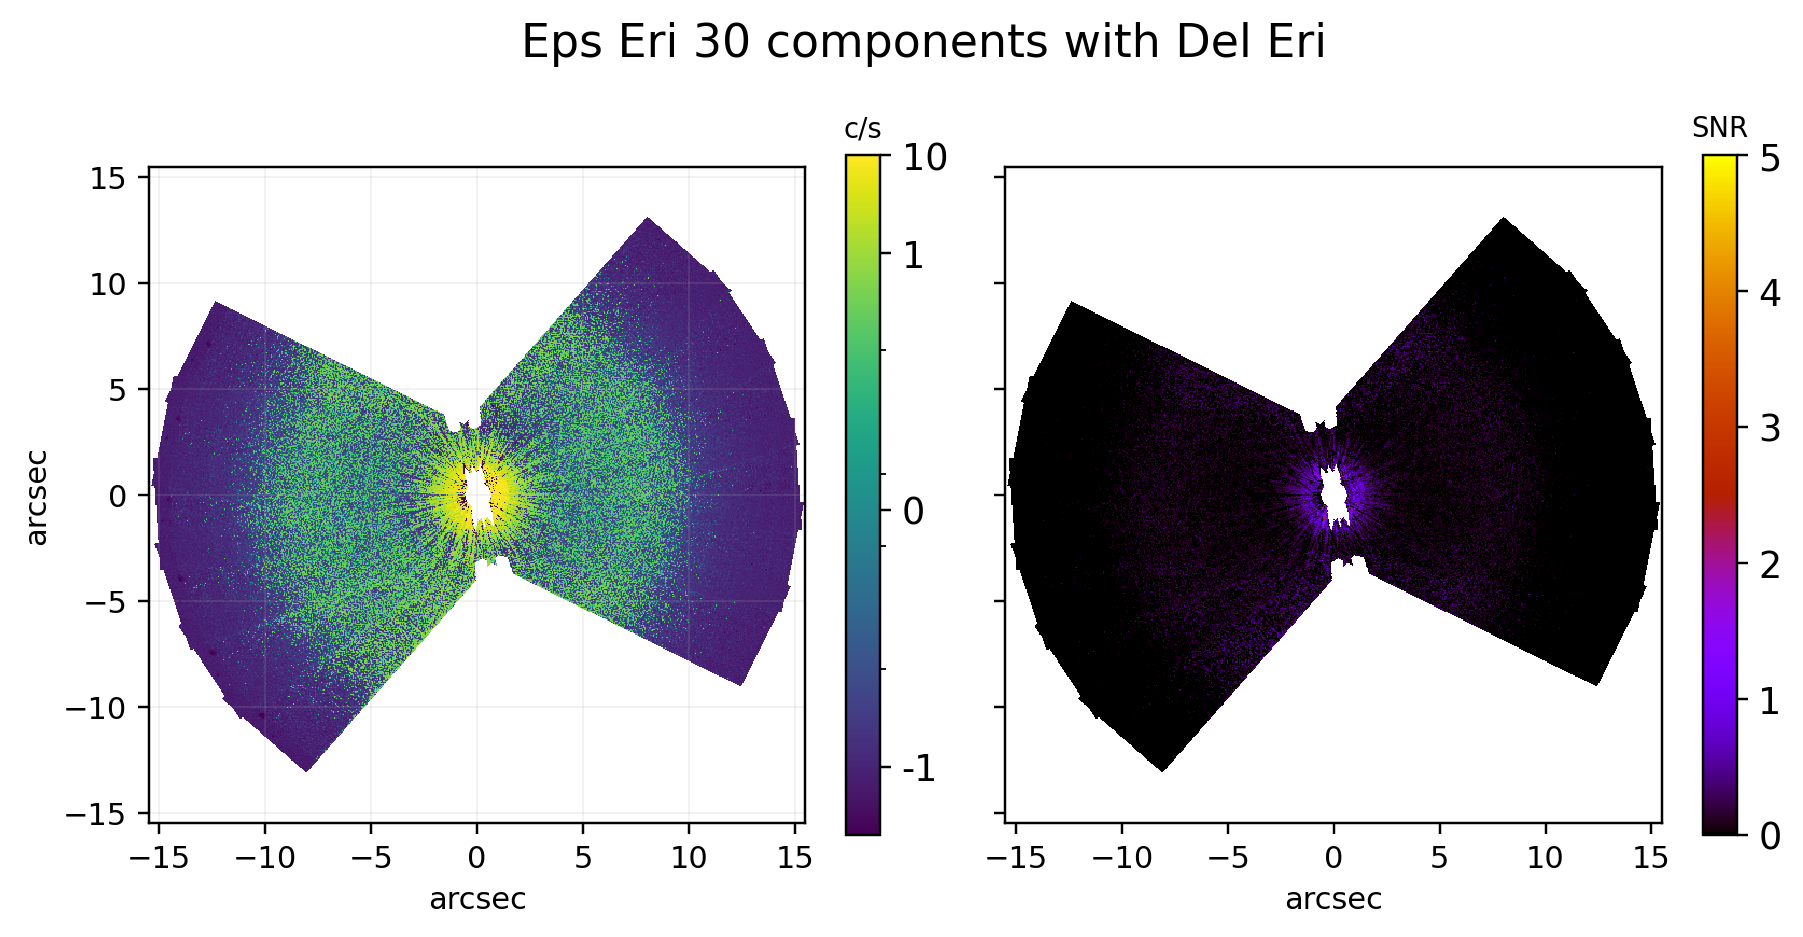

In [23]:
fig = plt.figure(figsize=[8.5,4],dpi=220)
ax=plt.subplot(121)
displ_scale1(c1140,
              #vmin=0,
            grid=True,
            ax=ax,
            #d=31,
            cbar_label="c/s",
            cmap="viridis",
         norm=colors.SymLogNorm(linthresh=0.03, vmin = -5, vmax=10, base=10)
         )
           #vmax=10)
ax.set_xlabel('arcsec')
ax.set_ylabel('arcsec')
fig.suptitle("Eps Eri 30 components with Del Eri", fontsize=15)
plt.tight_layout()
ax1=plt.subplot(122)
displ_scale2(c1140/stdev,vmin=0,#vmax=2,
            grid=False,
            ax=ax1,
            #d=3.2,
            cbar_label="SNR",
            cmap=plt.cm.gnuplot,
            norm='linear',
            vmax=5)
ax1.set_xlabel('arcsec')
ax1.set_yticklabels("")

In [24]:
import os
import poppy
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
from astropy import convolution as conv
from matplotlib.colors import LinearSegmentedColormap,SymLogNorm, LogNorm
import matplotlib as mpl
import importlib

PIXELSCL=0.05071*u.arcsecond
stis_resel=(0.05071*u.arcsecond)**2
norm=SymLogNorm(6e-9)#,vmin=-1e-3,vmax=1e-3)
zero_color="white"
semi_sym_cm = LinearSegmentedColormap.from_list('my cmap', ['black',zero_color,'purple'])
mpl.rcParams['hatch.linewidth'] = 0.2  # previous pdf hatch linewidth

d=3.212#pc

gain1 = 4.087*u.electron/u.count #per email, header says 4 
counts_PSF1        = 9.4e8*u.electron/gain1/u.second
peakpixel1=counts_PSF1
gain2 = 4*u.electron/u.count #per email, header says 4 
counts_PSF2        = 9.27e8*u.electron/gain2/u.second
peakpixel2=counts_PSF2

In [25]:
def zeros_to_nan_profile(profile):
    profile[1][np.where(profile[1]==0)]=np.nan
    return profile

In [26]:
def radial_profile(hdulist_or_filename=None, ext=0, ee=False, center=None, stddev=False, mad=False, binsize=None, 
                   maxradius=None, normalize='None', pa_range=None, slice=0):
    """ Compute a radial profile of the image.

    This computes a discrete radial profile evaluated on the provided binsize. For a version
    interpolated onto a continuous curve, see measure_radial().

    Code taken pretty much directly from pydatatut.pdf

    Parameters
    ----------
    hdulist_or_filename : string
        FITS HDUList object or path to a FITS file.
        NaN values in the FITS data array are treated as masked and ignored in computing bin statistics.
    ext : int
        Extension in FITS file
    ee : bool
        Also return encircled energy (EE) curve in addition to radial profile?
    center : tuple of floats
        Coordinates (x,y) of PSF center, in pixel units. Default is image center.
    binsize : float
        size of step for profile. Default is pixel size.
    stddev : bool
        Compute standard deviation in each radial bin, not average?
    normalize : string
        set to 'peak' to normalize peak intensity =1, or to 'total' to normalize total flux=1.
        Default is no normalization (i.e. retain whatever normalization was used in computing the PSF itself)
    maxradius : float, optional
        Maximum radius to compute radial profile to. If not set, will be computed for all radii within the image.
    pa_range : list of floats, optional
        Optional specification for [min, max] position angles to be included in the radial profile.
        I.e. calculate that profile only for some wedge, not the full image. Specify the PA in degrees
        counterclockwise from +Y axis=0. Note that you can specify ranges across zero using negative numbers,
        such as pa_range=[-10,10].  The allowed PA range runs from -180 to 180 degrees.
    slice: integer, optional
        Slice into a datacube, for use on cubes computed by calc_datacube. Default 0 if a
        cube is provided with no slice specified.

    Returns
    --------
    results : tuple
        Tuple containing (radius, profile) or (radius, profile, EE) depending on what is requested.
        The radius gives the center radius of each bin, while the EE is given inside the whole bin
        so you should use (radius+binsize/2) for the radius of the EE curve if you want to be
        as precise as possible.
    """
    if isinstance(hdulist_or_filename, str):
        hdu_list = fits.open(hdulist_or_filename)
    elif isinstance(hdulist_or_filename, fits.HDUList):
        hdu_list = hdulist_or_filename
    else:
        raise ValueError("input must be a filename or HDUlist")

    if hdu_list[ext].header['NAXIS'] == 3:
        # data cube, so pick out just one slice
        image = hdu_list[ext].data[slice].copy()  # don't change normalization of actual input array, work with a copy!
    else:
        image = hdu_list[ext].data.copy()  # don't change normalization of actual input array, work with a copy!

    if normalize.lower() == 'peak':
        _log.debug("Calculating profile with PSF normalized to peak = 1")
        image /= image.max()
    elif normalize.lower() == 'total':
        _log.debug("Calculating profile with PSF normalized to total = 1")
        image /= image.sum()

    pixelscale = hdu_list[ext].header['PIXELSCL']

    if binsize is None:
        binsize = pixelscale

    y, x = np.indices(image.shape, dtype=float)
    if center is None:
        # get exact center of image
        # center = (image.shape[1]/2, image.shape[0]/2)
        center = tuple((a - 1) / 2.0 for a in image.shape[::-1])

    x -= center[0]
    y -= center[1]

    r = np.sqrt(x ** 2 + y ** 2) * pixelscale / binsize  # radius in bin size steps

    if pa_range is None:
        # Use full image
        ind = np.argsort(r.flat)
        sr = r.flat[ind]  # sorted r
        sim = image.flat[ind]  # sorted image

    else:
        # Apply the PA range restriction
        pa = np.rad2deg(np.arctan2(-x, y))  # Note the (-x,y) convention is needed for astronomical PA convention
        mask = (pa >= pa_range[0]) & (pa <= pa_range[1])
        ind = np.argsort(r[mask].flat)
        sr = r[mask].flat[ind]
        sim = image[mask].flat[ind]

    ri = sr.astype(int)  # sorted r as int
    deltar = ri[1:] - ri[:-1]  # assume all radii represented (more work if not)
    rind = np.where(deltar)[0]
    nr = rind[1:] - rind[:-1]  # number in radius bin
    csim = np.nan_to_num(sim).cumsum(dtype=float)  # cumulative sum to figure out sums for each bin
    # np.nancumsum is implemented in >1.12
    tbin = csim[rind[1:]] - csim[rind[:-1]]  # sum for image values in radius bins
    radialprofile = tbin / nr

    # pre-pend the initial element that the above code misses.
    radialprofile2 = np.empty(len(radialprofile) + 1)
    if rind[0] != 0:
        radialprofile2[0] = csim[rind[0]] / (
                rind[0] + 1)  # if there are multiple elements in the center bin, average them
    else:
        radialprofile2[0] = csim[0]  # otherwise if there's just one then just take it.
    radialprofile2[1:] = radialprofile

    # Compute radius values corresponding to the measured points in the radial profile.
    # including handling the case where the innermost pixel may be more
    # than one pixel from the center. This can happen if pa_range is not None, since for
    # small ranges < 45 deg or so the innermost pixel that's valid in the mask may be
    # more than one pixel from the center. It can also happen if we are computing a
    # radial profile centered on an offset source outside of the FOV.
    rr = np.arange(ri.min(), ri.min() + len(
        radialprofile2)) * binsize + binsize * 0.5  # these should be centered in the bins, so add a half.

    if maxradius is not None:
        crop = rr < maxradius
        rr = rr[crop]
        radialprofile2 = radialprofile2[crop]

    if stddev:
        stddevs = np.zeros_like(radialprofile2)
        r_pix = r * binsize
        for i, radius in enumerate(rr):
            if i == 0:
                wg = np.where(r < radius + binsize / 2)
            else:
                wg = np.where((r_pix >= (radius - binsize / 2)) & (r_pix < (radius + binsize / 2)))
                # wg = np.where( (r >= rr[i-1]) &  (r <rr[i] )))
            stddevs[i] = np.nanstd(image[wg])
        return rr, stddevs
    
    if mad:
        mads = np.zeros_like(radialprofile2)
        r_pix = r * binsize
        for i, radius in enumerate(rr):
            if i == 0:
                wg = np.where(r < radius + binsize / 2)
            else:
                wg = np.where((r_pix >= (radius - binsize / 2)) & (r_pix < (radius + binsize / 2)))
            mads[i] = np.nanmedian(np.absolute(image[wg]-np.nanmedian(image[wg])))
        return rr, mads

    if not ee:
        return rr, radialprofile2
    else:
        ee = csim[rind]
        return rr, radialprofile2, ee

In [27]:
nmf_10 = fits.open("epseri30allclean.fits")
nmf_10[0].header["PIXELSCL"]=PIXELSCL.value
nmf_10_mad = zeros_to_nan_profile(radial_profile(nmf_10,mad=True))*u.count

/opt/anaconda3/envs/np_veclib/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/w0/w0glfprn2b7c2dkswb2qrm040000gn/T/ipykernel_56726/565772543.py:149: RuntimeWarning: All-NaN slice encountered
  mads[i] = np.nanmedian(np.absolute(image[wg]-np.nanmedian(image[wg])))


In [28]:
#hdu = fits.PrimaryHDU(c1140)
#hdu.header["PIXELSCL"]=PIXELSCL.value
#nmf_30 = fits.HDUList(hdus=hdu)
nmf_30 = fits.open("epsEri_all_mds3_meds3.fits")
nmf_30[0].header["PIXELSCL"]=PIXELSCL.value
nmf_30_mad = zeros_to_nan_profile(radial_profile(nmf_30,mad=True))*u.count

/var/folders/w0/w0glfprn2b7c2dkswb2qrm040000gn/T/ipykernel_56726/4285024222.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axAU.set_xticklabels(["%.03g"%tick for tick in AU_ticks])


Text(0, 0.5, 'mJy/as$^2$')

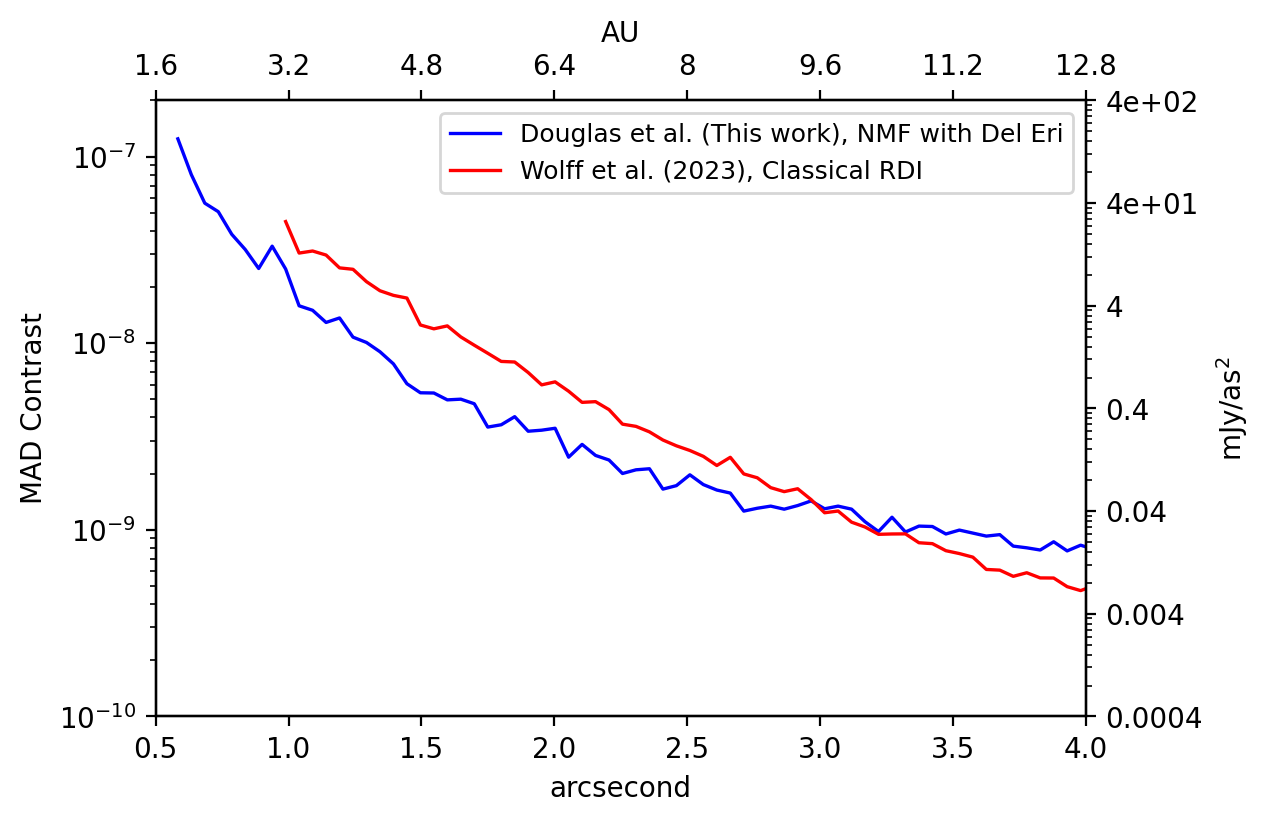

In [36]:
plt.figure(figsize=[6,4],dpi=200)

ax=plt.subplot(111)

ax.plot(nmf_10_mad[0],nmf_10_mad[1]/peakpixel1,'-',label='Douglas et al. (This work), NMF with Del Eri',color="blue",linewidth=1.2)
ax.plot(nmf_30_mad[0],nmf_30_mad[1]/peakpixel2,'-',label='Wolff et al. (2023), Classical RDI',color="red",linewidth=1.2)

ax.set_yscale('log')
#ax.set_xscale('log')
plt.legend(loc="upper right",fontsize=9)
#ax.set_yticks([1e-9,5e-9,1e-8,5e-8,1e-7,5e-7,1e-6])
#ax.set_xticks([0.1,1,6])
plt.xlabel("arcsecond")
#plt.ylabel("%i$\sigma$ contrast per pixel"%sigma)
plt.ylabel("MAD Contrast")
ax.set_xlim([0.5,4])
ax.set_ylim([1e-10,2e-7])#Default [1e-9,1e-6] for the rest to work 

ax2 = ax.twinx()
axAU = ax.twiny()
d=3.2#pc
AU_ticks=ax.get_xticks()*d 
ax2.set_yscale('log')
#axAU.set_yscale('log')
#axAU.set_xticks([0.32,3.2,32])

axAU.set_xlim(ax.get_xlim())
#axAU.set_xticks(np.array(ax.get_xticks()))
axAU.set_xticklabels(["%.03g"%tick for tick in AU_ticks])
axAU.set_xlabel(r"AU")

Jy_per_count_sec_pix=0.1765*u.millijansky*(u.arcsec**(-2))


ax2.set_ylim(np.array(ax.get_ylim()))
ax2.set_yticks(ax.get_yticks())

surf_B = -(np.log10((ax.get_yticks()))*2.5) #contrast Surface brightness
surf_B =Jy_per_count_sec_pix.value*peakpixel1.value*ax.get_yticks() #

ax2.set_yticklabels(["%.01g"%v for v in surf_B])

ax2.set_ylabel(r"$L_\star/as^2$ [mags]")
ax2.set_ylabel(r"mJy/as$^2$")